In [30]:
# Package imports

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import pandas as pd
import seaborn as sns

# ML related imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Other
import csv

In [166]:
# Defines all parameters needed for the run

# Generate non-boundary points and labels
x_min, x_max = -2, 0.5
y_min, y_max = -1, 1
resolution = 0.001  # Adjust this value as needed
max_iter = 100

# Training parameters
batch_size = 64
train_ratio = 0.8
num_epochs = 2000
class_weights = torch.tensor([1.0, 20]) # 20 here is because samples_per_epoch/max1s is 20.
samples_per_epoch = 10000 # The number of samples generated per epoch
max1s = 500 # The maximum number of additional 1s which will be added to aid the class imbalance problem

# Generating the network 
input_size = 2  # Since each point is a complex number (2 values)
hidden_size = 1024 # Hidden size within the network. Somewhat a stand in for parameter number
num_classes = 2  # 0 for non-boundary points, 1 for boundary points
lr = 0.001 # Learning rate

In [143]:
# Uses a greedy algorithm to find the Mandelbrot set boundary. Actually useful

# Calculating the elements within the set
def mandelbrot(c, max_iter):
    z = 0
    for i in range(max_iter):
        z = z * z + c
        if abs(z) > 2:
            return i
    return max_iter

In [144]:
# Generates the infinite data used later on by the training loop

def mandelbrot_data_generator(max_iter, resolution, num_samples):
    #Variables
    # max_iter = the number of iterations considered. Used to calcualte whether a point is in the set or not
    # resolution = the size of pixels being considered
    # num_samples = the number of labelled datapoints to be returned by a given training run

    x_min, x_max = -2, 0.5
    y_min, y_max = -1, 1

    width_vals = np.arange(x_min, x_max, resolution)
    height_vals = np.arange(y_min, y_max, resolution)

    points = []
    labels = []

    for i in range(num_samples):
        cx = np.random.choice(width_vals)
        cy = np.random.choice(height_vals)
        c = complex(cx, cy)
        points.append(c)

        if mandelbrot(c, max_iter) == max_iter - 1:
            labels.append(1)
        else:
            labels.append(0)
            
    points = np.array([complex(x) for x in points])
    
    real_parts = np.real(points)
    imag_parts = np.imag(points)
    
    # Defining the boundary points and labels for later training. Boundary points get the label 1
    points = np.column_stack((real_parts, imag_parts))
    #points = torch.tensor(points) # The tensor step is performed later. At this points it should remain an np array

    return points, labels

In [145]:
# Loading the data into a form which can be used to actual training

def data_loader(points, labels, batch_size): # note that because this is infinite data, train and test splits no longer make sense

    # Creating the dataset from points and labels lists
    dataset = TensorDataset(torch.tensor(points), torch.tensor(labels))
    # Creating a loader
    train_loader = DataLoader(dataset, batch_size, shuffle=True)

    return train_loader

In [146]:
# Defining and creating the neural network

# Define a deeper and more sophisticated architecture
class NetBN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetBN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)


    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the neural network
model = NetBN(input_size, hidden_size, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(model.parameters(), lr)

In [167]:
# Training run. Actually training the neural network. Note that this also involves data generation for an infinite data framework


# Initialise the training loss tracker
training_loss = []
avg_training_loss = []
# For adding 1s when they are found
points1 = []
labels1 = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    num_batches = 0
    batch_total_loss = 0

    points, labels = mandelbrot_data_generator(max_iter, resolution, samples_per_epoch)

    # This section of code finds 1s, stores their points and labels, and adds them to the dataset. 
    # This is to address the class imbalance problem faced. As a result, these points appear many times in the dataset.
    # Find 1s which have just been generated, and add them to points1
    for index in range(len(points)):
        if labels[index] == 1:
            points1.append(points[index])
            labels1.append(1)
    # Find if the number of 1s being added is currently over the max1s limit. Remove old points (to allow new ones into the set)
    diff = len(points1) - max1s
    if diff > 0:
        points1 = points1[diff:-1]
        labels1 = labels1[diff:-1]
    # Add these additional 1s into the training set
    print(f"Number of points labelled 1 : ", len(points1))
    if len(points1) != 0: # This if statement is to solve a concatentate bug with an empty array
        points = np.concatenate((points, np.array(points1)))
        labels = np.concatenate((labels, np.array(labels1)))
        print(f"Proportion of 1s in the labels : {len(np.where(labels==1)[0]) / len(np.where(labels==0)[0]):.6f}")

    # loading the processed data as normal. Note that the data_loader function shuffles the input, so we do not have to do that here
    train_loader = data_loader(points, labels, batch_size)
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device)
        labels.long() #required for the loss function calculation. BCE uses long
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels.long()) #the .long() command was only required ater introducing the points1 additions
        loss.backward()
        optimizer.step()

        training_loss.append(loss.item())

        num_batches += 1
        batch_total_loss += loss.item()
        running_loss += loss.item()
        #printing the proportion of 1s currently in the dataset. Relevant for early stages of training
        if i % len(train_loader) == len(train_loader) - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item()/print_freq:.4f}")
        running_loss = 0
    avg_training_loss.append(batch_total_loss/num_batches)

print("Training finished.")

  0%|          | 0/2000 [00:00<?, ?it/s]

Number of points labelled 1 :  0


  0%|          | 1/2000 [00:05<3:07:03,  5.61s/it]

Epoch [1/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  0


  0%|          | 2/2000 [00:10<2:58:05,  5.35s/it]

Epoch [2/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  1
Proportion of 1s in the labels : 0.000200


  0%|          | 3/2000 [00:15<2:47:21,  5.03s/it]

Epoch [3/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  3
Proportion of 1s in the labels : 0.000500


  0%|          | 4/2000 [00:20<2:52:27,  5.18s/it]

Epoch [4/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  4
Proportion of 1s in the labels : 0.000500


  0%|          | 5/2000 [00:25<2:51:14,  5.15s/it]

Epoch [5/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  4
Proportion of 1s in the labels : 0.000400


  0%|          | 6/2000 [00:30<2:43:10,  4.91s/it]

Epoch [6/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  5
Proportion of 1s in the labels : 0.000600


  0%|          | 7/2000 [00:34<2:38:24,  4.77s/it]

Epoch [7/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  6
Proportion of 1s in the labels : 0.000700


  0%|          | 8/2000 [00:40<2:43:17,  4.92s/it]

Epoch [8/2000], Batch [157/157], Loss: 0.0001
Number of points labelled 1 :  6
Proportion of 1s in the labels : 0.000600


  0%|          | 9/2000 [00:44<2:38:15,  4.77s/it]

Epoch [9/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000800


  0%|          | 10/2000 [00:49<2:35:56,  4.70s/it]

Epoch [10/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 11/2000 [00:54<2:40:08,  4.83s/it]

Epoch [11/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 12/2000 [00:58<2:37:56,  4.77s/it]

Epoch [12/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 13/2000 [01:03<2:34:23,  4.66s/it]

Epoch [13/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 14/2000 [01:07<2:34:36,  4.67s/it]

Epoch [14/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 15/2000 [01:12<2:38:09,  4.78s/it]

Epoch [15/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  7
Proportion of 1s in the labels : 0.000700


  1%|          | 16/2000 [01:17<2:33:50,  4.65s/it]

Epoch [16/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  8
Proportion of 1s in the labels : 0.000900


  1%|          | 17/2000 [01:21<2:30:38,  4.56s/it]

Epoch [17/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  10
Proportion of 1s in the labels : 0.001200


  1%|          | 18/2000 [01:26<2:37:48,  4.78s/it]

Epoch [18/2000], Batch [157/157], Loss: 0.0001
Number of points labelled 1 :  11
Proportion of 1s in the labels : 0.001200


  1%|          | 19/2000 [01:31<2:34:41,  4.69s/it]

Epoch [19/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  11
Proportion of 1s in the labels : 0.001100


  1%|          | 20/2000 [01:35<2:32:19,  4.62s/it]

Epoch [20/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  12
Proportion of 1s in the labels : 0.001300


  1%|          | 21/2000 [01:40<2:36:55,  4.76s/it]

Epoch [21/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  14
Proportion of 1s in the labels : 0.001600


  1%|          | 22/2000 [01:45<2:37:38,  4.78s/it]

Epoch [22/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  15
Proportion of 1s in the labels : 0.001600


  1%|          | 23/2000 [01:50<2:33:50,  4.67s/it]

Epoch [23/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  17
Proportion of 1s in the labels : 0.001900


  1%|          | 24/2000 [01:54<2:30:58,  4.58s/it]

Epoch [24/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  19
Proportion of 1s in the labels : 0.002100


  1%|▏         | 25/2000 [02:00<2:39:39,  4.85s/it]

Epoch [25/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  21
Proportion of 1s in the labels : 0.002300


  1%|▏         | 26/2000 [02:04<2:35:41,  4.73s/it]

Epoch [26/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  21
Proportion of 1s in the labels : 0.002100


  1%|▏         | 27/2000 [02:09<2:33:01,  4.65s/it]

Epoch [27/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  21
Proportion of 1s in the labels : 0.002100


  1%|▏         | 28/2000 [02:14<2:39:52,  4.86s/it]

Epoch [28/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  22
Proportion of 1s in the labels : 0.002300


  1%|▏         | 29/2000 [02:18<2:37:33,  4.80s/it]

Epoch [29/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  22
Proportion of 1s in the labels : 0.002200


  2%|▏         | 30/2000 [02:23<2:33:56,  4.69s/it]

Epoch [30/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  24
Proportion of 1s in the labels : 0.002601


  2%|▏         | 31/2000 [02:28<2:35:10,  4.73s/it]

Epoch [31/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  24
Proportion of 1s in the labels : 0.002400


  2%|▏         | 32/2000 [02:33<2:37:49,  4.81s/it]

Epoch [32/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  24
Proportion of 1s in the labels : 0.002400


  2%|▏         | 33/2000 [02:37<2:33:53,  4.69s/it]

Epoch [33/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  25
Proportion of 1s in the labels : 0.002600


  2%|▏         | 34/2000 [02:42<2:30:58,  4.61s/it]

Epoch [34/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  27
Proportion of 1s in the labels : 0.002901


  2%|▏         | 35/2000 [02:47<2:38:44,  4.85s/it]

Epoch [35/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  29
Proportion of 1s in the labels : 0.003101


  2%|▏         | 36/2000 [02:51<2:34:28,  4.72s/it]

Epoch [36/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  30
Proportion of 1s in the labels : 0.003100


  2%|▏         | 37/2000 [02:56<2:31:08,  4.62s/it]

Epoch [37/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  32
Proportion of 1s in the labels : 0.003401


  2%|▏         | 38/2000 [03:01<2:38:07,  4.84s/it]

Epoch [38/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  32
Proportion of 1s in the labels : 0.003200


  2%|▏         | 39/2000 [03:06<2:39:42,  4.89s/it]

Epoch [39/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  33
Proportion of 1s in the labels : 0.003400


  2%|▏         | 40/2000 [03:11<2:35:52,  4.77s/it]

Epoch [40/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  33
Proportion of 1s in the labels : 0.003300


  2%|▏         | 41/2000 [03:15<2:35:18,  4.76s/it]

Epoch [41/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  33
Proportion of 1s in the labels : 0.003300


  2%|▏         | 42/2000 [03:21<2:38:57,  4.87s/it]

Epoch [42/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  34
Proportion of 1s in the labels : 0.003500


  2%|▏         | 43/2000 [03:25<2:34:38,  4.74s/it]

Epoch [43/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  34
Proportion of 1s in the labels : 0.003400


  2%|▏         | 44/2000 [03:29<2:32:14,  4.67s/it]

Epoch [44/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  34
Proportion of 1s in the labels : 0.003400


  2%|▏         | 45/2000 [03:35<2:41:09,  4.95s/it]

Epoch [45/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  36
Proportion of 1s in the labels : 0.003801


  2%|▏         | 46/2000 [03:40<2:38:52,  4.88s/it]

Epoch [46/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  36
Proportion of 1s in the labels : 0.003600


  2%|▏         | 47/2000 [03:44<2:34:49,  4.76s/it]

Epoch [47/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  38
Proportion of 1s in the labels : 0.004001


  2%|▏         | 48/2000 [03:49<2:38:47,  4.88s/it]

Epoch [48/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  40
Proportion of 1s in the labels : 0.004201


  2%|▏         | 49/2000 [03:54<2:37:58,  4.86s/it]

Epoch [49/2000], Batch [157/157], Loss: 0.0001
Number of points labelled 1 :  41
Proportion of 1s in the labels : 0.004200


  2%|▎         | 50/2000 [03:59<2:34:26,  4.75s/it]

Epoch [50/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  42
Proportion of 1s in the labels : 0.004300


  3%|▎         | 51/2000 [04:04<2:35:12,  4.78s/it]

Epoch [51/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  42
Proportion of 1s in the labels : 0.004200


  3%|▎         | 52/2000 [04:09<2:38:38,  4.89s/it]

Epoch [52/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  42
Proportion of 1s in the labels : 0.004200


  3%|▎         | 53/2000 [04:13<2:34:50,  4.77s/it]

Epoch [53/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  42
Proportion of 1s in the labels : 0.004200


  3%|▎         | 54/2000 [04:18<2:31:50,  4.68s/it]

Epoch [54/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  42
Proportion of 1s in the labels : 0.004200


  3%|▎         | 55/2000 [04:23<2:40:35,  4.95s/it]

Epoch [55/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  43
Proportion of 1s in the labels : 0.004400


  3%|▎         | 56/2000 [04:28<2:36:27,  4.83s/it]

Epoch [56/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  44
Proportion of 1s in the labels : 0.004500


  3%|▎         | 57/2000 [04:32<2:33:03,  4.73s/it]

Epoch [57/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  46
Proportion of 1s in the labels : 0.004801


  3%|▎         | 58/2000 [04:37<2:37:37,  4.87s/it]

Epoch [58/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  47
Proportion of 1s in the labels : 0.004800


  3%|▎         | 59/2000 [04:42<2:37:04,  4.86s/it]

Epoch [59/2000], Batch [157/157], Loss: 0.0000
Number of points labelled 1 :  50
Proportion of 1s in the labels : 0.005302


  3%|▎         | 60/2000 [04:47<2:33:54,  4.76s/it]

Epoch [60/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  51
Proportion of 1s in the labels : 0.005201


  3%|▎         | 61/2000 [04:52<2:34:54,  4.79s/it]

Epoch [61/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  55
Proportion of 1s in the labels : 0.005902


  3%|▎         | 62/2000 [04:57<2:38:39,  4.91s/it]

Epoch [62/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  55
Proportion of 1s in the labels : 0.005500


  3%|▎         | 63/2000 [05:01<2:34:57,  4.80s/it]

Epoch [63/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  56
Proportion of 1s in the labels : 0.005701


  3%|▎         | 64/2000 [05:06<2:31:41,  4.70s/it]

Epoch [64/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  59
Proportion of 1s in the labels : 0.006202


  3%|▎         | 65/2000 [05:12<2:40:12,  4.97s/it]

Epoch [65/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  59
Proportion of 1s in the labels : 0.005900


  3%|▎         | 66/2000 [05:16<2:35:28,  4.82s/it]

Epoch [66/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  59
Proportion of 1s in the labels : 0.005900


  3%|▎         | 67/2000 [05:21<2:32:48,  4.74s/it]

Epoch [67/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  60
Proportion of 1s in the labels : 0.006101


  3%|▎         | 68/2000 [05:26<2:37:49,  4.90s/it]

Epoch [68/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  60
Proportion of 1s in the labels : 0.006000


  3%|▎         | 69/2000 [05:31<2:36:10,  4.85s/it]

Epoch [69/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  61
Proportion of 1s in the labels : 0.006201


  4%|▎         | 70/2000 [05:35<2:33:03,  4.76s/it]

Epoch [70/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  63
Proportion of 1s in the labels : 0.006501


  4%|▎         | 71/2000 [05:40<2:34:23,  4.80s/it]

Epoch [71/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  64
Proportion of 1s in the labels : 0.006501


  4%|▎         | 72/2000 [05:45<2:39:00,  4.95s/it]

Epoch [72/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  66
Proportion of 1s in the labels : 0.006801


  4%|▎         | 73/2000 [05:50<2:35:07,  4.83s/it]

Epoch [73/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  66
Proportion of 1s in the labels : 0.006600


  4%|▎         | 74/2000 [05:54<2:32:33,  4.75s/it]

Epoch [74/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  66
Proportion of 1s in the labels : 0.006600


  4%|▍         | 75/2000 [06:00<2:39:04,  4.96s/it]

Epoch [75/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  69
Proportion of 1s in the labels : 0.007202


  4%|▍         | 76/2000 [06:04<2:34:57,  4.83s/it]

Epoch [76/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  70
Proportion of 1s in the labels : 0.007101


  4%|▍         | 77/2000 [06:09<2:31:43,  4.73s/it]

Epoch [77/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  71
Proportion of 1s in the labels : 0.007201


  4%|▍         | 78/2000 [06:14<2:36:29,  4.89s/it]

Epoch [78/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  71
Proportion of 1s in the labels : 0.007100


  4%|▍         | 79/2000 [06:19<2:34:50,  4.84s/it]

Epoch [79/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  72
Proportion of 1s in the labels : 0.007301


  4%|▍         | 80/2000 [06:23<2:31:24,  4.73s/it]

Epoch [80/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  72
Proportion of 1s in the labels : 0.007200


  4%|▍         | 81/2000 [06:28<2:33:28,  4.80s/it]

Epoch [81/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  74
Proportion of 1s in the labels : 0.007602


  4%|▍         | 82/2000 [06:33<2:35:51,  4.88s/it]

Epoch [82/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  75
Proportion of 1s in the labels : 0.007601


  4%|▍         | 83/2000 [06:38<2:32:04,  4.76s/it]

Epoch [83/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  75
Proportion of 1s in the labels : 0.007500


  4%|▍         | 84/2000 [06:42<2:30:39,  4.72s/it]

Epoch [84/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  75
Proportion of 1s in the labels : 0.007500


  4%|▍         | 85/2000 [06:48<2:40:30,  5.03s/it]

Epoch [85/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  75
Proportion of 1s in the labels : 0.007500


  4%|▍         | 86/2000 [06:53<2:35:53,  4.89s/it]

Epoch [86/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  77
Proportion of 1s in the labels : 0.007902


  4%|▍         | 87/2000 [06:57<2:32:09,  4.77s/it]

Epoch [87/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  77
Proportion of 1s in the labels : 0.007700


  4%|▍         | 88/2000 [07:03<2:39:52,  5.02s/it]

Epoch [88/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  78
Proportion of 1s in the labels : 0.007901


  4%|▍         | 89/2000 [07:08<2:39:21,  5.00s/it]

Epoch [89/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  80
Proportion of 1s in the labels : 0.008202


  4%|▍         | 90/2000 [07:12<2:34:40,  4.86s/it]

Epoch [90/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  81
Proportion of 1s in the labels : 0.008201


  5%|▍         | 91/2000 [07:18<2:38:03,  4.97s/it]

Epoch [91/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  81
Proportion of 1s in the labels : 0.008100


  5%|▍         | 92/2000 [07:22<2:36:44,  4.93s/it]

Epoch [92/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  82
Proportion of 1s in the labels : 0.008301


  5%|▍         | 93/2000 [07:27<2:32:46,  4.81s/it]

Epoch [93/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  82
Proportion of 1s in the labels : 0.008200


  5%|▍         | 94/2000 [07:32<2:33:09,  4.82s/it]

Epoch [94/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  82
Proportion of 1s in the labels : 0.008200


  5%|▍         | 95/2000 [07:37<2:36:34,  4.93s/it]

Epoch [95/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  84
Proportion of 1s in the labels : 0.008602


  5%|▍         | 96/2000 [07:42<2:33:03,  4.82s/it]

Epoch [96/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  84
Proportion of 1s in the labels : 0.008400


  5%|▍         | 97/2000 [07:46<2:30:15,  4.74s/it]

Epoch [97/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  84
Proportion of 1s in the labels : 0.008400


  5%|▍         | 98/2000 [07:52<2:38:07,  4.99s/it]

Epoch [98/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  87
Proportion of 1s in the labels : 0.009003


  5%|▍         | 99/2000 [07:56<2:34:04,  4.86s/it]

Epoch [99/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  88
Proportion of 1s in the labels : 0.008901


  5%|▌         | 100/2000 [08:01<2:31:03,  4.77s/it]

Epoch [100/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  89
Proportion of 1s in the labels : 0.009001


  5%|▌         | 101/2000 [08:06<2:35:54,  4.93s/it]

Epoch [101/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  91
Proportion of 1s in the labels : 0.009302


  5%|▌         | 102/2000 [08:11<2:34:59,  4.90s/it]

Epoch [102/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  92
Proportion of 1s in the labels : 0.009301


  5%|▌         | 103/2000 [08:15<2:31:28,  4.79s/it]

Epoch [103/2000], Batch [158/158], Loss: 0.0001
Number of points labelled 1 :  93
Proportion of 1s in the labels : 0.009401


  5%|▌         | 104/2000 [08:21<2:33:54,  4.87s/it]

Epoch [104/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  94
Proportion of 1s in the labels : 0.009501


  5%|▌         | 105/2000 [08:26<2:35:52,  4.94s/it]

Epoch [105/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  95
Proportion of 1s in the labels : 0.009601


  5%|▌         | 106/2000 [08:30<2:34:34,  4.90s/it]

Epoch [106/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  95
Proportion of 1s in the labels : 0.009500


  5%|▌         | 107/2000 [08:35<2:33:37,  4.87s/it]

Epoch [107/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  96
Proportion of 1s in the labels : 0.009701


  5%|▌         | 108/2000 [08:41<2:37:58,  5.01s/it]

Epoch [108/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  96
Proportion of 1s in the labels : 0.009600


  5%|▌         | 109/2000 [08:45<2:34:03,  4.89s/it]

Epoch [109/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  97
Proportion of 1s in the labels : 0.009801


  6%|▌         | 110/2000 [08:50<2:31:37,  4.81s/it]

Epoch [110/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009901


  6%|▌         | 111/2000 [08:55<2:39:58,  5.08s/it]

Epoch [111/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009800


  6%|▌         | 112/2000 [09:00<2:36:00,  4.96s/it]

Epoch [112/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009800


  6%|▌         | 113/2000 [09:05<2:38:25,  5.04s/it]

Epoch [113/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009800


  6%|▌         | 114/2000 [09:11<2:44:29,  5.23s/it]

Epoch [114/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009800


  6%|▌         | 115/2000 [09:16<2:39:06,  5.06s/it]

Epoch [115/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  98
Proportion of 1s in the labels : 0.009800


  6%|▌         | 116/2000 [09:21<2:36:06,  4.97s/it]

Epoch [116/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  100
Proportion of 1s in the labels : 0.010202


  6%|▌         | 117/2000 [09:26<2:39:47,  5.09s/it]

Epoch [117/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  100
Proportion of 1s in the labels : 0.010000


  6%|▌         | 118/2000 [09:31<2:39:21,  5.08s/it]

Epoch [118/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  101
Proportion of 1s in the labels : 0.010201


  6%|▌         | 119/2000 [09:36<2:35:54,  4.97s/it]

Epoch [119/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  101
Proportion of 1s in the labels : 0.010100


  6%|▌         | 120/2000 [09:41<2:38:28,  5.06s/it]

Epoch [120/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  101
Proportion of 1s in the labels : 0.010100


  6%|▌         | 121/2000 [09:46<2:40:14,  5.12s/it]

Epoch [121/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  104
Proportion of 1s in the labels : 0.010703


  6%|▌         | 122/2000 [09:51<2:37:13,  5.02s/it]

Epoch [122/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  105
Proportion of 1s in the labels : 0.010601


  6%|▌         | 123/2000 [09:56<2:39:18,  5.09s/it]

Epoch [123/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  106
Proportion of 1s in the labels : 0.010701


  6%|▌         | 124/2000 [10:02<2:43:06,  5.22s/it]

Epoch [124/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  107
Proportion of 1s in the labels : 0.010801


  6%|▋         | 125/2000 [10:07<2:39:56,  5.12s/it]

Epoch [125/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  109
Proportion of 1s in the labels : 0.011102


  6%|▋         | 126/2000 [10:12<2:40:40,  5.14s/it]

Epoch [126/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  110
Proportion of 1s in the labels : 0.011101


  6%|▋         | 127/2000 [10:17<2:45:13,  5.29s/it]

Epoch [127/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  111
Proportion of 1s in the labels : 0.011201


  6%|▋         | 128/2000 [10:22<2:41:58,  5.19s/it]

Epoch [128/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  111
Proportion of 1s in the labels : 0.011100


  6%|▋         | 129/2000 [10:28<2:43:15,  5.24s/it]

Epoch [129/2000], Batch [158/158], Loss: 0.0000
Number of points labelled 1 :  113
Proportion of 1s in the labels : 0.011502


  6%|▋         | 130/2000 [10:34<2:48:21,  5.40s/it]

Epoch [130/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  114
Proportion of 1s in the labels : 0.011501


  7%|▋         | 131/2000 [10:39<2:45:20,  5.31s/it]

Epoch [131/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  116
Proportion of 1s in the labels : 0.011802


  7%|▋         | 132/2000 [10:44<2:47:05,  5.37s/it]

Epoch [132/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  116
Proportion of 1s in the labels : 0.011600


  7%|▋         | 133/2000 [10:50<2:51:24,  5.51s/it]

Epoch [133/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  117
Proportion of 1s in the labels : 0.011801


  7%|▋         | 134/2000 [10:55<2:48:38,  5.42s/it]

Epoch [134/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  118
Proportion of 1s in the labels : 0.011901


  7%|▋         | 135/2000 [11:01<2:51:02,  5.50s/it]

Epoch [135/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  119
Proportion of 1s in the labels : 0.012001


  7%|▋         | 136/2000 [11:07<2:53:46,  5.59s/it]

Epoch [136/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  119
Proportion of 1s in the labels : 0.011900


  7%|▋         | 137/2000 [11:12<2:51:18,  5.52s/it]

Epoch [137/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  119
Proportion of 1s in the labels : 0.011900


  7%|▋         | 138/2000 [11:18<2:56:13,  5.68s/it]

Epoch [138/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  121
Proportion of 1s in the labels : 0.012302


  7%|▋         | 139/2000 [11:24<2:56:51,  5.70s/it]

Epoch [139/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  122
Proportion of 1s in the labels : 0.012301


  7%|▋         | 140/2000 [11:29<2:55:05,  5.65s/it]

Epoch [140/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  122
Proportion of 1s in the labels : 0.012200


  7%|▋         | 141/2000 [11:36<3:03:26,  5.92s/it]

Epoch [141/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  125
Proportion of 1s in the labels : 0.012804


  7%|▋         | 142/2000 [11:42<3:00:43,  5.84s/it]

Epoch [142/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  126
Proportion of 1s in the labels : 0.012701


  7%|▋         | 143/2000 [11:47<3:00:30,  5.83s/it]

Epoch [143/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  126
Proportion of 1s in the labels : 0.012600


  7%|▋         | 144/2000 [11:54<3:06:49,  6.04s/it]

Epoch [144/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  127
Proportion of 1s in the labels : 0.012801


  7%|▋         | 145/2000 [12:00<3:05:56,  6.01s/it]

Epoch [145/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  127
Proportion of 1s in the labels : 0.012700


  7%|▋         | 146/2000 [12:06<3:11:01,  6.18s/it]

Epoch [146/2000], Batch [159/159], Loss: 0.0001
Number of points labelled 1 :  129
Proportion of 1s in the labels : 0.013103


  7%|▋         | 147/2000 [12:13<3:10:22,  6.16s/it]

Epoch [147/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  131
Proportion of 1s in the labels : 0.013303


  7%|▋         | 148/2000 [12:19<3:08:48,  6.12s/it]

Epoch [148/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  133
Proportion of 1s in the labels : 0.013503


  7%|▋         | 149/2000 [12:25<3:16:01,  6.35s/it]

Epoch [149/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  134
Proportion of 1s in the labels : 0.013501


  8%|▊         | 150/2000 [12:32<3:13:00,  6.26s/it]

Epoch [150/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  135
Proportion of 1s in the labels : 0.013601


  8%|▊         | 151/2000 [12:38<3:17:20,  6.40s/it]

Epoch [151/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  135
Proportion of 1s in the labels : 0.013500


  8%|▊         | 152/2000 [12:45<3:16:57,  6.39s/it]

Epoch [152/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  135
Proportion of 1s in the labels : 0.013500


  8%|▊         | 153/2000 [12:51<3:14:47,  6.33s/it]

Epoch [153/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  135
Proportion of 1s in the labels : 0.013500


  8%|▊         | 154/2000 [12:58<3:22:02,  6.57s/it]

Epoch [154/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  137
Proportion of 1s in the labels : 0.013903


  8%|▊         | 155/2000 [13:04<3:19:13,  6.48s/it]

Epoch [155/2000], Batch [159/159], Loss: 0.0001
Number of points labelled 1 :  138
Proportion of 1s in the labels : 0.013901


  8%|▊         | 156/2000 [13:11<3:25:03,  6.67s/it]

Epoch [156/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  139
Proportion of 1s in the labels : 0.014001


  8%|▊         | 157/2000 [13:18<3:22:48,  6.60s/it]

Epoch [157/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  140
Proportion of 1s in the labels : 0.014101


  8%|▊         | 158/2000 [13:24<3:23:02,  6.61s/it]

Epoch [158/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  140
Proportion of 1s in the labels : 0.014000


  8%|▊         | 159/2000 [13:32<3:28:32,  6.80s/it]

Epoch [159/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  141
Proportion of 1s in the labels : 0.014201


  8%|▊         | 160/2000 [13:38<3:24:59,  6.68s/it]

Epoch [160/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  142
Proportion of 1s in the labels : 0.014301


  8%|▊         | 161/2000 [13:46<3:33:13,  6.96s/it]

Epoch [161/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  147
Proportion of 1s in the labels : 0.015208


  8%|▊         | 162/2000 [13:52<3:28:48,  6.82s/it]

Epoch [162/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  147
Proportion of 1s in the labels : 0.014700


  8%|▊         | 163/2000 [13:59<3:33:21,  6.97s/it]

Epoch [163/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  147
Proportion of 1s in the labels : 0.014700


  8%|▊         | 164/2000 [14:10<4:05:54,  8.04s/it]

Epoch [164/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  148
Proportion of 1s in the labels : 0.014901


  8%|▊         | 165/2000 [14:21<4:37:12,  9.06s/it]

Epoch [165/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  149
Proportion of 1s in the labels : 0.015002


  8%|▊         | 166/2000 [14:31<4:40:50,  9.19s/it]

Epoch [166/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  149
Proportion of 1s in the labels : 0.014900


  8%|▊         | 167/2000 [14:38<4:19:00,  8.48s/it]

Epoch [167/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  149
Proportion of 1s in the labels : 0.014900


  8%|▊         | 168/2000 [14:45<4:05:23,  8.04s/it]

Epoch [168/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  151
Proportion of 1s in the labels : 0.015303


  8%|▊         | 169/2000 [14:52<3:58:07,  7.80s/it]

Epoch [169/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  152
Proportion of 1s in the labels : 0.015302


  8%|▊         | 170/2000 [14:59<3:47:57,  7.47s/it]

Epoch [170/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  153
Proportion of 1s in the labels : 0.015402


  9%|▊         | 171/2000 [15:06<3:49:49,  7.54s/it]

Epoch [171/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  153
Proportion of 1s in the labels : 0.015300


  9%|▊         | 172/2000 [15:13<3:42:14,  7.29s/it]

Epoch [172/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  153
Proportion of 1s in the labels : 0.015300


  9%|▊         | 173/2000 [15:21<3:46:02,  7.42s/it]

Epoch [173/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015703


  9%|▊         | 174/2000 [15:28<3:40:08,  7.23s/it]

Epoch [174/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015500


  9%|▉         | 175/2000 [15:35<3:43:25,  7.35s/it]

Epoch [175/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015500


  9%|▉         | 176/2000 [15:42<3:40:04,  7.24s/it]

Epoch [176/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015500


  9%|▉         | 177/2000 [15:50<3:40:52,  7.27s/it]

Epoch [177/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015500


  9%|▉         | 178/2000 [15:57<3:41:42,  7.30s/it]

Epoch [178/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  155
Proportion of 1s in the labels : 0.015500


  9%|▉         | 179/2000 [16:04<3:40:16,  7.26s/it]

Epoch [179/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  157
Proportion of 1s in the labels : 0.015903


  9%|▉         | 180/2000 [16:12<3:43:38,  7.37s/it]

Epoch [180/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  161
Proportion of 1s in the labels : 0.016507


  9%|▉         | 181/2000 [16:19<3:39:26,  7.24s/it]

Epoch [181/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  161
Proportion of 1s in the labels : 0.016100


  9%|▉         | 182/2000 [16:27<3:45:15,  7.43s/it]

Epoch [182/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  162
Proportion of 1s in the labels : 0.016302


  9%|▉         | 183/2000 [16:34<3:41:14,  7.31s/it]

Epoch [183/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  165
Proportion of 1s in the labels : 0.016805


  9%|▉         | 184/2000 [16:42<3:48:15,  7.54s/it]

Epoch [184/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  166
Proportion of 1s in the labels : 0.016702


  9%|▉         | 185/2000 [16:49<3:42:49,  7.37s/it]

Epoch [185/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  167
Proportion of 1s in the labels : 0.016802


  9%|▉         | 186/2000 [16:57<3:48:13,  7.55s/it]

Epoch [186/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  169
Proportion of 1s in the labels : 0.017103


  9%|▉         | 187/2000 [17:04<3:43:56,  7.41s/it]

Epoch [187/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  169
Proportion of 1s in the labels : 0.016900


  9%|▉         | 188/2000 [17:11<3:46:48,  7.51s/it]

Epoch [188/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  169
Proportion of 1s in the labels : 0.016900


  9%|▉         | 189/2000 [17:19<3:44:23,  7.43s/it]

Epoch [189/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  169
Proportion of 1s in the labels : 0.016900


 10%|▉         | 190/2000 [17:26<3:45:32,  7.48s/it]

Epoch [190/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  171
Proportion of 1s in the labels : 0.017303


 10%|▉         | 191/2000 [17:34<3:45:22,  7.48s/it]

Epoch [191/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  174
Proportion of 1s in the labels : 0.017705


 10%|▉         | 192/2000 [17:41<3:44:57,  7.47s/it]

Epoch [192/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  174
Proportion of 1s in the labels : 0.017400


 10%|▉         | 193/2000 [17:49<3:46:25,  7.52s/it]

Epoch [193/2000], Batch [159/159], Loss: 0.0000
Number of points labelled 1 :  177
Proportion of 1s in the labels : 0.018005


 10%|▉         | 194/2000 [17:56<3:45:08,  7.48s/it]

Epoch [194/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  177
Proportion of 1s in the labels : 0.017700


 10%|▉         | 195/2000 [18:04<3:48:35,  7.60s/it]

Epoch [195/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  178
Proportion of 1s in the labels : 0.017902


 10%|▉         | 196/2000 [18:11<3:44:55,  7.48s/it]

Epoch [196/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  178
Proportion of 1s in the labels : 0.017800


 10%|▉         | 197/2000 [18:19<3:49:51,  7.65s/it]

Epoch [197/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  179
Proportion of 1s in the labels : 0.018002


 10%|▉         | 198/2000 [18:26<3:44:59,  7.49s/it]

Epoch [198/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  180
Proportion of 1s in the labels : 0.018102


 10%|▉         | 199/2000 [18:35<3:53:43,  7.79s/it]

Epoch [199/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  180
Proportion of 1s in the labels : 0.018000


 10%|█         | 200/2000 [18:42<3:48:23,  7.61s/it]

Epoch [200/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  182
Proportion of 1s in the labels : 0.018404


 10%|█         | 201/2000 [18:50<3:54:30,  7.82s/it]

Epoch [201/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  184
Proportion of 1s in the labels : 0.018604


 10%|█         | 202/2000 [18:58<3:49:00,  7.64s/it]

Epoch [202/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  184
Proportion of 1s in the labels : 0.018400


 10%|█         | 203/2000 [19:06<3:55:10,  7.85s/it]

Epoch [203/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  184
Proportion of 1s in the labels : 0.018400


 10%|█         | 204/2000 [19:13<3:49:05,  7.65s/it]

Epoch [204/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  185
Proportion of 1s in the labels : 0.018602


 10%|█         | 205/2000 [19:22<3:55:08,  7.86s/it]

Epoch [205/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  188
Proportion of 1s in the labels : 0.019106


 10%|█         | 206/2000 [19:29<3:48:51,  7.65s/it]

Epoch [206/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  188
Proportion of 1s in the labels : 0.018800


 10%|█         | 207/2000 [19:37<3:52:12,  7.77s/it]

Epoch [207/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  188
Proportion of 1s in the labels : 0.018800


 10%|█         | 208/2000 [19:44<3:47:55,  7.63s/it]

Epoch [208/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  189
Proportion of 1s in the labels : 0.019002


 10%|█         | 209/2000 [19:52<3:51:01,  7.74s/it]

Epoch [209/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  190
Proportion of 1s in the labels : 0.019102


 10%|█         | 210/2000 [20:00<3:48:22,  7.65s/it]

Epoch [210/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  190
Proportion of 1s in the labels : 0.019000


 11%|█         | 211/2000 [20:07<3:50:57,  7.75s/it]

Epoch [211/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  190
Proportion of 1s in the labels : 0.019000


 11%|█         | 212/2000 [20:15<3:48:23,  7.66s/it]

Epoch [212/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  191
Proportion of 1s in the labels : 0.019202


 11%|█         | 213/2000 [20:23<3:49:06,  7.69s/it]

Epoch [213/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  192
Proportion of 1s in the labels : 0.019302


 11%|█         | 214/2000 [20:30<3:48:22,  7.67s/it]

Epoch [214/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  193
Proportion of 1s in the labels : 0.019402


 11%|█         | 215/2000 [20:38<3:48:42,  7.69s/it]

Epoch [215/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  193
Proportion of 1s in the labels : 0.019300


 11%|█         | 216/2000 [20:46<3:48:18,  7.68s/it]

Epoch [216/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  194
Proportion of 1s in the labels : 0.019502


 11%|█         | 217/2000 [20:53<3:47:33,  7.66s/it]

Epoch [217/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  196
Proportion of 1s in the labels : 0.019804


 11%|█         | 218/2000 [21:01<3:49:12,  7.72s/it]

Epoch [218/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  197
Proportion of 1s in the labels : 0.019802


 11%|█         | 219/2000 [21:09<3:47:30,  7.66s/it]

Epoch [219/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  200
Proportion of 1s in the labels : 0.020306


 11%|█         | 220/2000 [21:17<3:49:15,  7.73s/it]

Epoch [220/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  201
Proportion of 1s in the labels : 0.020202


 11%|█         | 221/2000 [21:24<3:46:07,  7.63s/it]

Epoch [221/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  202
Proportion of 1s in the labels : 0.020302


 11%|█         | 222/2000 [21:32<3:49:32,  7.75s/it]

Epoch [222/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  203
Proportion of 1s in the labels : 0.020402


 11%|█         | 223/2000 [21:39<3:45:30,  7.61s/it]

Epoch [223/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  204
Proportion of 1s in the labels : 0.020502


 11%|█         | 224/2000 [21:48<3:53:01,  7.87s/it]

Epoch [224/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  205
Proportion of 1s in the labels : 0.020602


 11%|█▏        | 225/2000 [21:55<3:48:55,  7.74s/it]

Epoch [225/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  206
Proportion of 1s in the labels : 0.020702


 11%|█▏        | 226/2000 [22:03<3:53:15,  7.89s/it]

Epoch [226/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  207
Proportion of 1s in the labels : 0.020802


 11%|█▏        | 227/2000 [22:11<3:51:13,  7.82s/it]

Epoch [227/2000], Batch [160/160], Loss: 0.0001
Number of points labelled 1 :  207
Proportion of 1s in the labels : 0.020700


 11%|█▏        | 228/2000 [22:19<3:54:29,  7.94s/it]

Epoch [228/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  208
Proportion of 1s in the labels : 0.020902


 11%|█▏        | 229/2000 [22:27<3:48:09,  7.73s/it]

Epoch [229/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  209
Proportion of 1s in the labels : 0.021002


 12%|█▏        | 230/2000 [22:37<4:11:53,  8.54s/it]

Epoch [230/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  210
Proportion of 1s in the labels : 0.021102


 12%|█▏        | 231/2000 [22:46<4:17:41,  8.74s/it]

Epoch [231/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  210
Proportion of 1s in the labels : 0.021000


 12%|█▏        | 232/2000 [22:54<4:08:34,  8.44s/it]

Epoch [232/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  210
Proportion of 1s in the labels : 0.021000


 12%|█▏        | 233/2000 [23:02<4:07:53,  8.42s/it]

Epoch [233/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  210
Proportion of 1s in the labels : 0.021000


 12%|█▏        | 234/2000 [23:10<4:02:22,  8.23s/it]

Epoch [234/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  212
Proportion of 1s in the labels : 0.021404


 12%|█▏        | 235/2000 [23:18<3:59:29,  8.14s/it]

Epoch [235/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  212
Proportion of 1s in the labels : 0.021200


 12%|█▏        | 236/2000 [23:26<4:00:50,  8.19s/it]

Epoch [236/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  213
Proportion of 1s in the labels : 0.021402


 12%|█▏        | 237/2000 [23:35<4:02:45,  8.26s/it]

Epoch [237/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  215
Proportion of 1s in the labels : 0.021704


 12%|█▏        | 238/2000 [23:43<4:02:24,  8.25s/it]

Epoch [238/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  219
Proportion of 1s in the labels : 0.022309


 12%|█▏        | 239/2000 [23:52<4:04:49,  8.34s/it]

Epoch [239/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  221
Proportion of 1s in the labels : 0.022304


 12%|█▏        | 240/2000 [24:00<4:03:02,  8.29s/it]

Epoch [240/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  221
Proportion of 1s in the labels : 0.022100


 12%|█▏        | 241/2000 [24:09<4:11:56,  8.59s/it]

Epoch [241/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  221
Proportion of 1s in the labels : 0.022100


 12%|█▏        | 242/2000 [24:16<4:01:04,  8.23s/it]

Epoch [242/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  223
Proportion of 1s in the labels : 0.022505


 12%|█▏        | 243/2000 [24:25<4:01:56,  8.26s/it]

Epoch [243/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  223
Proportion of 1s in the labels : 0.022300


 12%|█▏        | 244/2000 [24:32<3:54:26,  8.01s/it]

Epoch [244/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  223
Proportion of 1s in the labels : 0.022300


 12%|█▏        | 245/2000 [24:40<3:55:36,  8.05s/it]

Epoch [245/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  225
Proportion of 1s in the labels : 0.022705


 12%|█▏        | 246/2000 [24:48<3:51:06,  7.91s/it]

Epoch [246/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  226
Proportion of 1s in the labels : 0.022702


 12%|█▏        | 247/2000 [24:56<3:53:29,  7.99s/it]

Epoch [247/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  228
Proportion of 1s in the labels : 0.023005


 12%|█▏        | 248/2000 [25:04<3:49:24,  7.86s/it]

Epoch [248/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  233
Proportion of 1s in the labels : 0.023812


 12%|█▏        | 249/2000 [25:12<3:51:37,  7.94s/it]

Epoch [249/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  234
Proportion of 1s in the labels : 0.023502


 12%|█▎        | 250/2000 [25:19<3:48:36,  7.84s/it]

Epoch [250/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  235
Proportion of 1s in the labels : 0.023602


 13%|█▎        | 251/2000 [25:27<3:49:58,  7.89s/it]

Epoch [251/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  235
Proportion of 1s in the labels : 0.023500


 13%|█▎        | 252/2000 [25:35<3:47:57,  7.82s/it]

Epoch [252/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  236
Proportion of 1s in the labels : 0.023702


 13%|█▎        | 253/2000 [25:43<3:49:52,  7.89s/it]

Epoch [253/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  238
Proportion of 1s in the labels : 0.024005


 13%|█▎        | 254/2000 [25:51<3:48:06,  7.84s/it]

Epoch [254/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  238
Proportion of 1s in the labels : 0.023800


 13%|█▎        | 255/2000 [25:59<3:48:47,  7.87s/it]

Epoch [255/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  238
Proportion of 1s in the labels : 0.023800


 13%|█▎        | 256/2000 [26:07<3:48:57,  7.88s/it]

Epoch [256/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  238
Proportion of 1s in the labels : 0.023800


 13%|█▎        | 257/2000 [26:15<3:49:14,  7.89s/it]

Epoch [257/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  239
Proportion of 1s in the labels : 0.024002


 13%|█▎        | 258/2000 [26:22<3:49:15,  7.90s/it]

Epoch [258/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  240
Proportion of 1s in the labels : 0.024102


 13%|█▎        | 259/2000 [26:30<3:49:04,  7.89s/it]

Epoch [259/2000], Batch [160/160], Loss: 0.0000
Number of points labelled 1 :  243
Proportion of 1s in the labels : 0.024607


 13%|█▎        | 260/2000 [26:38<3:49:00,  7.90s/it]

Epoch [260/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  245
Proportion of 1s in the labels : 0.024705


 13%|█▎        | 261/2000 [26:46<3:49:13,  7.91s/it]

Epoch [261/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  247
Proportion of 1s in the labels : 0.024905


 13%|█▎        | 262/2000 [26:54<3:49:43,  7.93s/it]

Epoch [262/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  248
Proportion of 1s in the labels : 0.024902


 13%|█▎        | 263/2000 [27:02<3:49:51,  7.94s/it]

Epoch [263/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  248
Proportion of 1s in the labels : 0.024800


 13%|█▎        | 264/2000 [27:10<3:49:44,  7.94s/it]

Epoch [264/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  249
Proportion of 1s in the labels : 0.025003


 13%|█▎        | 265/2000 [27:19<3:56:33,  8.18s/it]

Epoch [265/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  249
Proportion of 1s in the labels : 0.024900


 13%|█▎        | 266/2000 [27:27<3:54:20,  8.11s/it]

Epoch [266/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  249
Proportion of 1s in the labels : 0.024900


 13%|█▎        | 267/2000 [27:35<3:58:24,  8.25s/it]

Epoch [267/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  251
Proportion of 1s in the labels : 0.025305


 13%|█▎        | 268/2000 [27:43<3:54:58,  8.14s/it]

Epoch [268/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  252
Proportion of 1s in the labels : 0.025303


 13%|█▎        | 269/2000 [27:51<3:53:59,  8.11s/it]

Epoch [269/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  254
Proportion of 1s in the labels : 0.025605


 14%|█▎        | 270/2000 [27:59<3:51:40,  8.03s/it]

Epoch [270/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  255
Proportion of 1s in the labels : 0.025603


 14%|█▎        | 271/2000 [28:07<3:53:45,  8.11s/it]

Epoch [271/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  255
Proportion of 1s in the labels : 0.025500


 14%|█▎        | 272/2000 [28:15<3:50:57,  8.02s/it]

Epoch [272/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  256
Proportion of 1s in the labels : 0.025703


 14%|█▎        | 273/2000 [28:23<3:51:20,  8.04s/it]

Epoch [273/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  259
Proportion of 1s in the labels : 0.026208


 14%|█▎        | 274/2000 [28:31<3:51:23,  8.04s/it]

Epoch [274/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  259
Proportion of 1s in the labels : 0.025900


 14%|█▍        | 275/2000 [28:40<3:52:18,  8.08s/it]

Epoch [275/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  261
Proportion of 1s in the labels : 0.026305


 14%|█▍        | 276/2000 [28:47<3:49:36,  7.99s/it]

Epoch [276/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  262
Proportion of 1s in the labels : 0.026303


 14%|█▍        | 277/2000 [28:55<3:50:37,  8.03s/it]

Epoch [277/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  262
Proportion of 1s in the labels : 0.026200


 14%|█▍        | 278/2000 [29:03<3:49:34,  8.00s/it]

Epoch [278/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  263
Proportion of 1s in the labels : 0.026403


 14%|█▍        | 279/2000 [29:12<3:50:56,  8.05s/it]

Epoch [279/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  264
Proportion of 1s in the labels : 0.026503


 14%|█▍        | 280/2000 [29:19<3:48:54,  7.99s/it]

Epoch [280/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  265
Proportion of 1s in the labels : 0.026603


 14%|█▍        | 281/2000 [29:27<3:49:56,  8.03s/it]

Epoch [281/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  265
Proportion of 1s in the labels : 0.026500


 14%|█▍        | 282/2000 [29:35<3:48:23,  7.98s/it]

Epoch [282/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  265
Proportion of 1s in the labels : 0.026500


 14%|█▍        | 283/2000 [29:44<3:49:46,  8.03s/it]

Epoch [283/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  266
Proportion of 1s in the labels : 0.026703


 14%|█▍        | 284/2000 [29:51<3:47:53,  7.97s/it]

Epoch [284/2000], Batch [161/161], Loss: 0.0001
Number of points labelled 1 :  267
Proportion of 1s in the labels : 0.026803


 14%|█▍        | 285/2000 [29:59<3:49:14,  8.02s/it]

Epoch [285/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  268
Proportion of 1s in the labels : 0.026903


 14%|█▍        | 286/2000 [30:07<3:48:09,  7.99s/it]

Epoch [286/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  268
Proportion of 1s in the labels : 0.026800


 14%|█▍        | 287/2000 [30:16<3:49:42,  8.05s/it]

Epoch [287/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  270
Proportion of 1s in the labels : 0.027205


 14%|█▍        | 288/2000 [30:23<3:47:36,  7.98s/it]

Epoch [288/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  270
Proportion of 1s in the labels : 0.027000


 14%|█▍        | 289/2000 [30:32<3:49:44,  8.06s/it]

Epoch [289/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  271
Proportion of 1s in the labels : 0.027203


 14%|█▍        | 290/2000 [30:39<3:47:45,  7.99s/it]

Epoch [290/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  272
Proportion of 1s in the labels : 0.027303


 15%|█▍        | 291/2000 [30:48<3:49:37,  8.06s/it]

Epoch [291/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  272
Proportion of 1s in the labels : 0.027200


 15%|█▍        | 292/2000 [30:56<3:47:53,  8.01s/it]

Epoch [292/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  274
Proportion of 1s in the labels : 0.027606


 15%|█▍        | 293/2000 [31:04<3:50:12,  8.09s/it]

Epoch [293/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  274
Proportion of 1s in the labels : 0.027400


 15%|█▍        | 294/2000 [31:12<3:47:21,  8.00s/it]

Epoch [294/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  275
Proportion of 1s in the labels : 0.027603


 15%|█▍        | 295/2000 [31:20<3:50:27,  8.11s/it]

Epoch [295/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  275
Proportion of 1s in the labels : 0.027500


 15%|█▍        | 296/2000 [31:28<3:47:27,  8.01s/it]

Epoch [296/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  278
Proportion of 1s in the labels : 0.028108


 15%|█▍        | 297/2000 [31:36<3:53:00,  8.21s/it]

Epoch [297/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  279
Proportion of 1s in the labels : 0.028003


 15%|█▍        | 298/2000 [31:44<3:48:01,  8.04s/it]

Epoch [298/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  279
Proportion of 1s in the labels : 0.027900


 15%|█▍        | 299/2000 [31:52<3:50:11,  8.12s/it]

Epoch [299/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  279
Proportion of 1s in the labels : 0.027900


 15%|█▌        | 300/2000 [32:00<3:47:15,  8.02s/it]

Epoch [300/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  279
Proportion of 1s in the labels : 0.027900


 15%|█▌        | 301/2000 [32:09<3:49:59,  8.12s/it]

Epoch [301/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  280
Proportion of 1s in the labels : 0.028103


 15%|█▌        | 302/2000 [32:16<3:47:11,  8.03s/it]

Epoch [302/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  280
Proportion of 1s in the labels : 0.028000


 15%|█▌        | 303/2000 [32:25<3:50:17,  8.14s/it]

Epoch [303/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  280
Proportion of 1s in the labels : 0.028000


 15%|█▌        | 304/2000 [32:33<3:47:01,  8.03s/it]

Epoch [304/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  281
Proportion of 1s in the labels : 0.028203


 15%|█▌        | 305/2000 [32:41<3:49:56,  8.14s/it]

Epoch [305/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  283
Proportion of 1s in the labels : 0.028506


 15%|█▌        | 306/2000 [32:49<3:47:08,  8.05s/it]

Epoch [306/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  285
Proportion of 1s in the labels : 0.028706


 15%|█▌        | 307/2000 [32:57<3:50:21,  8.16s/it]

Epoch [307/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  285
Proportion of 1s in the labels : 0.028500


 15%|█▌        | 308/2000 [33:05<3:47:12,  8.06s/it]

Epoch [308/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  288
Proportion of 1s in the labels : 0.029109


 15%|█▌        | 309/2000 [33:14<3:51:02,  8.20s/it]

Epoch [309/2000], Batch [161/161], Loss: 0.0001
Number of points labelled 1 :  289
Proportion of 1s in the labels : 0.029003


 16%|█▌        | 310/2000 [33:21<3:46:11,  8.03s/it]

Epoch [310/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  290
Proportion of 1s in the labels : 0.029103


 16%|█▌        | 311/2000 [33:30<3:52:46,  8.27s/it]

Epoch [311/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  292
Proportion of 1s in the labels : 0.029406


 16%|█▌        | 312/2000 [33:38<3:46:54,  8.07s/it]

Epoch [312/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  292
Proportion of 1s in the labels : 0.029200


 16%|█▌        | 313/2000 [33:46<3:51:46,  8.24s/it]

Epoch [313/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  294
Proportion of 1s in the labels : 0.029606


 16%|█▌        | 314/2000 [33:54<3:46:42,  8.07s/it]

Epoch [314/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  295
Proportion of 1s in the labels : 0.029603


 16%|█▌        | 315/2000 [34:03<3:52:40,  8.29s/it]

Epoch [315/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  296
Proportion of 1s in the labels : 0.029703


 16%|█▌        | 316/2000 [34:10<3:47:15,  8.10s/it]

Epoch [316/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  298
Proportion of 1s in the labels : 0.030006


 16%|█▌        | 317/2000 [34:19<3:52:54,  8.30s/it]

Epoch [317/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  299
Proportion of 1s in the labels : 0.030003


 16%|█▌        | 318/2000 [34:27<3:47:05,  8.10s/it]

Epoch [318/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  300
Proportion of 1s in the labels : 0.030103


 16%|█▌        | 319/2000 [34:36<3:53:04,  8.32s/it]

Epoch [319/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  300
Proportion of 1s in the labels : 0.030000


 16%|█▌        | 320/2000 [34:43<3:48:04,  8.15s/it]

Epoch [320/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  302
Proportion of 1s in the labels : 0.030406


 16%|█▌        | 321/2000 [34:52<3:52:31,  8.31s/it]

Epoch [321/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  302
Proportion of 1s in the labels : 0.030200


 16%|█▌        | 322/2000 [35:00<3:47:54,  8.15s/it]

Epoch [322/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  303
Proportion of 1s in the labels : 0.030403


 16%|█▌        | 323/2000 [35:08<3:52:10,  8.31s/it]

Epoch [323/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  303
Proportion of 1s in the labels : 0.030300


 16%|█▌        | 324/2000 [35:16<3:48:08,  8.17s/it]

Epoch [324/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  303
Proportion of 1s in the labels : 0.030300


 16%|█▋        | 325/2000 [35:25<3:51:41,  8.30s/it]

Epoch [325/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  303
Proportion of 1s in the labels : 0.030300


 16%|█▋        | 326/2000 [35:33<3:48:33,  8.19s/it]

Epoch [326/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  304
Proportion of 1s in the labels : 0.030503


 16%|█▋        | 327/2000 [35:41<3:50:55,  8.28s/it]

Epoch [327/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  304
Proportion of 1s in the labels : 0.030400


 16%|█▋        | 328/2000 [35:49<3:48:55,  8.22s/it]

Epoch [328/2000], Batch [161/161], Loss: 0.0000
Number of points labelled 1 :  306
Proportion of 1s in the labels : 0.030806


 16%|█▋        | 329/2000 [35:58<3:50:23,  8.27s/it]

Epoch [329/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  306
Proportion of 1s in the labels : 0.030600


 16%|█▋        | 330/2000 [36:06<3:50:08,  8.27s/it]

Epoch [330/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  307
Proportion of 1s in the labels : 0.030803


 17%|█▋        | 331/2000 [36:14<3:50:53,  8.30s/it]

Epoch [331/2000], Batch [162/162], Loss: 0.0001
Number of points labelled 1 :  308
Proportion of 1s in the labels : 0.030903


 17%|█▋        | 332/2000 [36:23<3:55:08,  8.46s/it]

Epoch [332/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  309
Proportion of 1s in the labels : 0.031003


 17%|█▋        | 333/2000 [36:33<4:03:21,  8.76s/it]

Epoch [333/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  310
Proportion of 1s in the labels : 0.031103


 17%|█▋        | 334/2000 [36:42<4:07:14,  8.90s/it]

Epoch [334/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  311
Proportion of 1s in the labels : 0.031203


 17%|█▋        | 335/2000 [36:50<4:01:49,  8.71s/it]

Epoch [335/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  313
Proportion of 1s in the labels : 0.031506


 17%|█▋        | 336/2000 [37:00<4:08:25,  8.96s/it]

Epoch [336/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  315
Proportion of 1s in the labels : 0.031706


 17%|█▋        | 337/2000 [37:08<4:03:51,  8.80s/it]

Epoch [337/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  316
Proportion of 1s in the labels : 0.031703


 17%|█▋        | 338/2000 [37:17<4:04:13,  8.82s/it]

Epoch [338/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  318
Proportion of 1s in the labels : 0.032006


 17%|█▋        | 339/2000 [37:27<4:15:12,  9.22s/it]

Epoch [339/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  318
Proportion of 1s in the labels : 0.031800


 17%|█▋        | 340/2000 [37:38<4:31:23,  9.81s/it]

Epoch [340/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  319
Proportion of 1s in the labels : 0.032003


 17%|█▋        | 341/2000 [37:49<4:37:24, 10.03s/it]

Epoch [341/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  319
Proportion of 1s in the labels : 0.031900


 17%|█▋        | 342/2000 [37:57<4:20:35,  9.43s/it]

Epoch [342/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  320
Proportion of 1s in the labels : 0.032103


 17%|█▋        | 343/2000 [38:06<4:15:50,  9.26s/it]

Epoch [343/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  322
Proportion of 1s in the labels : 0.032406


 17%|█▋        | 344/2000 [38:15<4:11:32,  9.11s/it]

Epoch [344/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  322
Proportion of 1s in the labels : 0.032200


 17%|█▋        | 345/2000 [38:23<4:07:26,  8.97s/it]

Epoch [345/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  322
Proportion of 1s in the labels : 0.032200


 17%|█▋        | 346/2000 [38:33<4:15:44,  9.28s/it]

Epoch [346/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  323
Proportion of 1s in the labels : 0.032403


 17%|█▋        | 347/2000 [38:43<4:20:32,  9.46s/it]

Epoch [347/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  323
Proportion of 1s in the labels : 0.032300


 17%|█▋        | 348/2000 [38:56<4:50:34, 10.55s/it]

Epoch [348/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  325
Proportion of 1s in the labels : 0.032707


 17%|█▋        | 349/2000 [39:10<5:12:58, 11.37s/it]

Epoch [349/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  325
Proportion of 1s in the labels : 0.032500


 18%|█▊        | 350/2000 [39:21<5:11:24, 11.32s/it]

Epoch [350/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  325
Proportion of 1s in the labels : 0.032500


 18%|█▊        | 351/2000 [39:29<4:45:47, 10.40s/it]

Epoch [351/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  326
Proportion of 1s in the labels : 0.032703


 18%|█▊        | 352/2000 [39:38<4:33:52,  9.97s/it]

Epoch [352/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  326
Proportion of 1s in the labels : 0.032600


 18%|█▊        | 353/2000 [39:46<4:17:25,  9.38s/it]

Epoch [353/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  326
Proportion of 1s in the labels : 0.032600


 18%|█▊        | 354/2000 [39:55<4:15:19,  9.31s/it]

Epoch [354/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  326
Proportion of 1s in the labels : 0.032600


 18%|█▊        | 355/2000 [40:03<4:05:21,  8.95s/it]

Epoch [355/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  328
Proportion of 1s in the labels : 0.033007


 18%|█▊        | 356/2000 [40:13<4:14:50,  9.30s/it]

Epoch [356/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  329
Proportion of 1s in the labels : 0.033003


 18%|█▊        | 357/2000 [40:22<4:09:25,  9.11s/it]

Epoch [357/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  331
Proportion of 1s in the labels : 0.033307


 18%|█▊        | 358/2000 [40:31<4:09:15,  9.11s/it]

Epoch [358/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  332
Proportion of 1s in the labels : 0.033303


 18%|█▊        | 359/2000 [40:40<4:07:20,  9.04s/it]

Epoch [359/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  332
Proportion of 1s in the labels : 0.033200


 18%|█▊        | 360/2000 [40:48<4:01:42,  8.84s/it]

Epoch [360/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  333
Proportion of 1s in the labels : 0.033403


 18%|█▊        | 361/2000 [40:57<4:02:05,  8.86s/it]

Epoch [361/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  334
Proportion of 1s in the labels : 0.033503


 18%|█▊        | 362/2000 [41:05<3:56:35,  8.67s/it]

Epoch [362/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  334
Proportion of 1s in the labels : 0.033400


 18%|█▊        | 363/2000 [41:15<4:02:31,  8.89s/it]

Epoch [363/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  336
Proportion of 1s in the labels : 0.033807


 18%|█▊        | 364/2000 [41:23<3:56:50,  8.69s/it]

Epoch [364/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  336
Proportion of 1s in the labels : 0.033600


 18%|█▊        | 365/2000 [41:32<4:00:15,  8.82s/it]

Epoch [365/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  338
Proportion of 1s in the labels : 0.034007


 18%|█▊        | 366/2000 [41:40<3:55:00,  8.63s/it]

Epoch [366/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  341
Proportion of 1s in the labels : 0.034410


 18%|█▊        | 367/2000 [41:50<3:59:03,  8.78s/it]

Epoch [367/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  343
Proportion of 1s in the labels : 0.034507


 18%|█▊        | 368/2000 [41:58<3:56:07,  8.68s/it]

Epoch [368/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  345
Proportion of 1s in the labels : 0.034707


 18%|█▊        | 369/2000 [42:07<3:55:39,  8.67s/it]

Epoch [369/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  347
Proportion of 1s in the labels : 0.034907


 18%|█▊        | 370/2000 [42:15<3:54:53,  8.65s/it]

Epoch [370/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  352
Proportion of 1s in the labels : 0.035718


 19%|█▊        | 371/2000 [42:24<3:54:02,  8.62s/it]

Epoch [371/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  352
Proportion of 1s in the labels : 0.035200


 19%|█▊        | 372/2000 [42:33<3:57:51,  8.77s/it]

Epoch [372/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  352
Proportion of 1s in the labels : 0.035200


 19%|█▊        | 373/2000 [42:41<3:51:08,  8.52s/it]

Epoch [373/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  352
Proportion of 1s in the labels : 0.035200


 19%|█▊        | 374/2000 [42:50<3:51:57,  8.56s/it]

Epoch [374/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  354
Proportion of 1s in the labels : 0.035607


 19%|█▉        | 375/2000 [42:57<3:46:39,  8.37s/it]

Epoch [375/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  354
Proportion of 1s in the labels : 0.035400


 19%|█▉        | 376/2000 [43:06<3:49:24,  8.48s/it]

Epoch [376/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  355
Proportion of 1s in the labels : 0.035604


 19%|█▉        | 377/2000 [43:14<3:44:07,  8.29s/it]

Epoch [377/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  356
Proportion of 1s in the labels : 0.035704


 19%|█▉        | 378/2000 [43:23<3:48:53,  8.47s/it]

Epoch [378/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  357
Proportion of 1s in the labels : 0.035804


 19%|█▉        | 379/2000 [43:35<4:17:47,  9.54s/it]

Epoch [379/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  357
Proportion of 1s in the labels : 0.035700


 19%|█▉        | 380/2000 [43:44<4:11:48,  9.33s/it]

Epoch [380/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  359
Proportion of 1s in the labels : 0.036107


 19%|█▉        | 381/2000 [43:53<4:08:32,  9.21s/it]

Epoch [381/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  359
Proportion of 1s in the labels : 0.035900


 19%|█▉        | 382/2000 [44:01<4:01:29,  8.96s/it]

Epoch [382/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  360
Proportion of 1s in the labels : 0.036104


 19%|█▉        | 383/2000 [44:10<4:02:27,  9.00s/it]

Epoch [383/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  361
Proportion of 1s in the labels : 0.036204


 19%|█▉        | 384/2000 [44:18<3:56:13,  8.77s/it]

Epoch [384/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  361
Proportion of 1s in the labels : 0.036100


 19%|█▉        | 385/2000 [44:28<4:04:08,  9.07s/it]

Epoch [385/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  362
Proportion of 1s in the labels : 0.036304


 19%|█▉        | 386/2000 [44:36<3:55:43,  8.76s/it]

Epoch [386/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  362
Proportion of 1s in the labels : 0.036200


 19%|█▉        | 387/2000 [44:45<3:55:32,  8.76s/it]

Epoch [387/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  363
Proportion of 1s in the labels : 0.036404


 19%|█▉        | 388/2000 [44:53<3:49:59,  8.56s/it]

Epoch [388/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  365
Proportion of 1s in the labels : 0.036707


 19%|█▉        | 389/2000 [45:02<3:51:02,  8.61s/it]

Epoch [389/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  365
Proportion of 1s in the labels : 0.036500


 20%|█▉        | 390/2000 [45:10<3:47:50,  8.49s/it]

Epoch [390/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  367
Proportion of 1s in the labels : 0.036907


 20%|█▉        | 391/2000 [45:18<3:47:34,  8.49s/it]

Epoch [391/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  368
Proportion of 1s in the labels : 0.036904


 20%|█▉        | 392/2000 [45:27<3:45:44,  8.42s/it]

Epoch [392/2000], Batch [162/162], Loss: 0.0000
Number of points labelled 1 :  370
Proportion of 1s in the labels : 0.037207


 20%|█▉        | 393/2000 [45:35<3:45:52,  8.43s/it]

Epoch [393/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  370
Proportion of 1s in the labels : 0.037000


 20%|█▉        | 394/2000 [45:44<3:46:12,  8.45s/it]

Epoch [394/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  371
Proportion of 1s in the labels : 0.037204


 20%|█▉        | 395/2000 [45:52<3:45:51,  8.44s/it]

Epoch [395/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  372
Proportion of 1s in the labels : 0.037304


 20%|█▉        | 396/2000 [46:01<3:46:54,  8.49s/it]

Epoch [396/2000], Batch [163/163], Loss: 0.0001
Number of points labelled 1 :  372
Proportion of 1s in the labels : 0.037200


 20%|█▉        | 397/2000 [46:09<3:44:23,  8.40s/it]

Epoch [397/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  372
Proportion of 1s in the labels : 0.037200


 20%|█▉        | 398/2000 [46:18<3:47:48,  8.53s/it]

Epoch [398/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  374
Proportion of 1s in the labels : 0.037608


 20%|█▉        | 399/2000 [46:26<3:45:38,  8.46s/it]

Epoch [399/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  374
Proportion of 1s in the labels : 0.037400


 20%|██        | 400/2000 [46:35<3:50:24,  8.64s/it]

Epoch [400/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  375
Proportion of 1s in the labels : 0.037604


 20%|██        | 401/2000 [46:43<3:44:16,  8.42s/it]

Epoch [401/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  375
Proportion of 1s in the labels : 0.037500


 20%|██        | 402/2000 [46:52<3:49:32,  8.62s/it]

Epoch [402/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  375
Proportion of 1s in the labels : 0.037500


 20%|██        | 403/2000 [47:00<3:44:55,  8.45s/it]

Epoch [403/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  377
Proportion of 1s in the labels : 0.037908


 20%|██        | 404/2000 [47:09<3:48:02,  8.57s/it]

Epoch [404/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  377
Proportion of 1s in the labels : 0.037700


 20%|██        | 405/2000 [47:17<3:44:27,  8.44s/it]

Epoch [405/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  379
Proportion of 1s in the labels : 0.038108


 20%|██        | 406/2000 [47:26<3:46:49,  8.54s/it]

Epoch [406/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  381
Proportion of 1s in the labels : 0.038308


 20%|██        | 407/2000 [47:34<3:44:59,  8.47s/it]

Epoch [407/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  384
Proportion of 1s in the labels : 0.038712


 20%|██        | 408/2000 [47:43<3:45:54,  8.51s/it]

Epoch [408/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  384
Proportion of 1s in the labels : 0.038400


 20%|██        | 409/2000 [47:51<3:45:20,  8.50s/it]

Epoch [409/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  386
Proportion of 1s in the labels : 0.038808


 20%|██        | 410/2000 [48:01<3:56:25,  8.92s/it]

Epoch [410/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  387
Proportion of 1s in the labels : 0.038804


 21%|██        | 411/2000 [48:10<3:56:10,  8.92s/it]

Epoch [411/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  387
Proportion of 1s in the labels : 0.038700


 21%|██        | 412/2000 [48:19<3:52:07,  8.77s/it]

Epoch [412/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  388
Proportion of 1s in the labels : 0.038904


 21%|██        | 413/2000 [48:28<3:57:49,  8.99s/it]

Epoch [413/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  388
Proportion of 1s in the labels : 0.038800


 21%|██        | 414/2000 [48:36<3:51:43,  8.77s/it]

Epoch [414/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  390
Proportion of 1s in the labels : 0.039208


 21%|██        | 415/2000 [48:45<3:52:26,  8.80s/it]

Epoch [415/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  391
Proportion of 1s in the labels : 0.039204


 21%|██        | 416/2000 [48:53<3:48:24,  8.65s/it]

Epoch [416/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  393
Proportion of 1s in the labels : 0.039508


 21%|██        | 417/2000 [49:03<3:53:52,  8.86s/it]

Epoch [417/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  393
Proportion of 1s in the labels : 0.039300


 21%|██        | 418/2000 [49:12<3:58:08,  9.03s/it]

Epoch [418/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  394
Proportion of 1s in the labels : 0.039504


 21%|██        | 419/2000 [49:21<3:52:17,  8.82s/it]

Epoch [419/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  394
Proportion of 1s in the labels : 0.039400


 21%|██        | 420/2000 [49:29<3:51:33,  8.79s/it]

Epoch [420/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  395
Proportion of 1s in the labels : 0.039604


 21%|██        | 421/2000 [49:38<3:46:55,  8.62s/it]

Epoch [421/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  395
Proportion of 1s in the labels : 0.039500


 21%|██        | 422/2000 [49:46<3:49:03,  8.71s/it]

Epoch [422/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  396
Proportion of 1s in the labels : 0.039704


 21%|██        | 423/2000 [49:54<3:43:29,  8.50s/it]

Epoch [423/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  397
Proportion of 1s in the labels : 0.039804


 21%|██        | 424/2000 [50:04<3:48:23,  8.70s/it]

Epoch [424/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  397
Proportion of 1s in the labels : 0.039700


 21%|██▏       | 425/2000 [50:12<3:44:56,  8.57s/it]

Epoch [425/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  399
Proportion of 1s in the labels : 0.040108


 21%|██▏       | 426/2000 [50:21<3:48:15,  8.70s/it]

Epoch [426/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  401
Proportion of 1s in the labels : 0.040308


 21%|██▏       | 427/2000 [50:29<3:43:46,  8.54s/it]

Epoch [427/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  404
Proportion of 1s in the labels : 0.040712


 21%|██▏       | 428/2000 [50:38<3:45:43,  8.62s/it]

Epoch [428/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  406
Proportion of 1s in the labels : 0.040808


 21%|██▏       | 429/2000 [50:46<3:42:54,  8.51s/it]

Epoch [429/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  407
Proportion of 1s in the labels : 0.040804


 22%|██▏       | 430/2000 [50:55<3:44:06,  8.56s/it]

Epoch [430/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  408
Proportion of 1s in the labels : 0.040904


 22%|██▏       | 431/2000 [51:03<3:43:17,  8.54s/it]

Epoch [431/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  409
Proportion of 1s in the labels : 0.041004


 22%|██▏       | 432/2000 [51:12<3:42:56,  8.53s/it]

Epoch [432/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  410
Proportion of 1s in the labels : 0.041104


 22%|██▏       | 433/2000 [51:20<3:43:24,  8.55s/it]

Epoch [433/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  412
Proportion of 1s in the labels : 0.041408


 22%|██▏       | 434/2000 [51:29<3:41:28,  8.49s/it]

Epoch [434/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  412
Proportion of 1s in the labels : 0.041200


 22%|██▏       | 435/2000 [51:37<3:43:07,  8.55s/it]

Epoch [435/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  412
Proportion of 1s in the labels : 0.041200


 22%|██▏       | 436/2000 [51:46<3:40:37,  8.46s/it]

Epoch [436/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  414
Proportion of 1s in the labels : 0.041608


 22%|██▏       | 437/2000 [51:55<3:44:30,  8.62s/it]

Epoch [437/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  415
Proportion of 1s in the labels : 0.041604


 22%|██▏       | 438/2000 [52:03<3:40:21,  8.46s/it]

Epoch [438/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  415
Proportion of 1s in the labels : 0.041500


 22%|██▏       | 439/2000 [52:12<3:45:22,  8.66s/it]

Epoch [439/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  417
Proportion of 1s in the labels : 0.041908


 22%|██▏       | 440/2000 [52:20<3:40:38,  8.49s/it]

Epoch [440/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  419
Proportion of 1s in the labels : 0.042108


 22%|██▏       | 441/2000 [52:29<3:45:21,  8.67s/it]

Epoch [441/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  419
Proportion of 1s in the labels : 0.041900


 22%|██▏       | 442/2000 [52:37<3:41:12,  8.52s/it]

Epoch [442/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  419
Proportion of 1s in the labels : 0.041900


 22%|██▏       | 443/2000 [52:46<3:43:11,  8.60s/it]

Epoch [443/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  420
Proportion of 1s in the labels : 0.042104


 22%|██▏       | 444/2000 [52:54<3:40:54,  8.52s/it]

Epoch [444/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  421
Proportion of 1s in the labels : 0.042204


 22%|██▏       | 445/2000 [53:03<3:42:11,  8.57s/it]

Epoch [445/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  422
Proportion of 1s in the labels : 0.042304


 22%|██▏       | 446/2000 [53:12<3:41:43,  8.56s/it]

Epoch [446/2000], Batch [163/163], Loss: 0.0001
Number of points labelled 1 :  422
Proportion of 1s in the labels : 0.042200


 22%|██▏       | 447/2000 [53:20<3:44:01,  8.66s/it]

Epoch [447/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042609


 22%|██▏       | 448/2000 [53:29<3:44:17,  8.67s/it]

Epoch [448/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042400


 22%|██▏       | 449/2000 [53:38<3:41:35,  8.57s/it]

Epoch [449/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042400


 22%|██▎       | 450/2000 [53:46<3:43:48,  8.66s/it]

Epoch [450/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042400


 23%|██▎       | 451/2000 [53:56<3:48:56,  8.87s/it]

Epoch [451/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042400


 23%|██▎       | 452/2000 [54:08<4:11:25,  9.75s/it]

Epoch [452/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  424
Proportion of 1s in the labels : 0.042400


 23%|██▎       | 453/2000 [54:22<4:43:53, 11.01s/it]

Epoch [453/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  425
Proportion of 1s in the labels : 0.042604


 23%|██▎       | 454/2000 [54:35<5:06:09, 11.88s/it]

Epoch [454/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042704


 23%|██▎       | 455/2000 [54:46<4:55:41, 11.48s/it]

Epoch [455/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 456/2000 [54:55<4:37:29, 10.78s/it]

Epoch [456/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 457/2000 [55:04<4:21:49, 10.18s/it]

Epoch [457/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 458/2000 [55:12<4:08:14,  9.66s/it]

Epoch [458/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 459/2000 [55:21<4:00:53,  9.38s/it]

Epoch [459/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 460/2000 [55:29<3:52:21,  9.05s/it]

Epoch [460/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  426
Proportion of 1s in the labels : 0.042600


 23%|██▎       | 461/2000 [55:38<3:50:50,  9.00s/it]

Epoch [461/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  427
Proportion of 1s in the labels : 0.042804


 23%|██▎       | 462/2000 [55:46<3:44:05,  8.74s/it]

Epoch [462/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  429
Proportion of 1s in the labels : 0.043109


 23%|██▎       | 463/2000 [55:56<3:47:24,  8.88s/it]

Epoch [463/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  431
Proportion of 1s in the labels : 0.043309


 23%|██▎       | 464/2000 [56:04<3:41:13,  8.64s/it]

Epoch [464/2000], Batch [163/163], Loss: 0.0000
Number of points labelled 1 :  433
Proportion of 1s in the labels : 0.043509


 23%|██▎       | 465/2000 [56:13<3:45:10,  8.80s/it]

Epoch [465/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  433
Proportion of 1s in the labels : 0.043300


 23%|██▎       | 466/2000 [56:21<3:40:51,  8.64s/it]

Epoch [466/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  433
Proportion of 1s in the labels : 0.043300


 23%|██▎       | 467/2000 [56:30<3:43:18,  8.74s/it]

Epoch [467/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  434
Proportion of 1s in the labels : 0.043504


 23%|██▎       | 468/2000 [56:39<3:42:24,  8.71s/it]

Epoch [468/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  435
Proportion of 1s in the labels : 0.043604


 23%|██▎       | 469/2000 [56:47<3:42:07,  8.70s/it]

Epoch [469/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  437
Proportion of 1s in the labels : 0.043909


 24%|██▎       | 470/2000 [56:56<3:42:08,  8.71s/it]

Epoch [470/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  438
Proportion of 1s in the labels : 0.043904


 24%|██▎       | 471/2000 [57:05<3:40:18,  8.65s/it]

Epoch [471/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  439
Proportion of 1s in the labels : 0.044004


 24%|██▎       | 472/2000 [57:14<3:42:56,  8.75s/it]

Epoch [472/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  440
Proportion of 1s in the labels : 0.044104


 24%|██▎       | 473/2000 [57:22<3:39:00,  8.61s/it]

Epoch [473/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  441
Proportion of 1s in the labels : 0.044204


 24%|██▎       | 474/2000 [57:31<3:41:56,  8.73s/it]

Epoch [474/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  442
Proportion of 1s in the labels : 0.044304


 24%|██▍       | 475/2000 [57:39<3:36:57,  8.54s/it]

Epoch [475/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  444
Proportion of 1s in the labels : 0.044609


 24%|██▍       | 476/2000 [57:48<3:41:41,  8.73s/it]

Epoch [476/2000], Batch [164/164], Loss: 0.0001
Number of points labelled 1 :  444
Proportion of 1s in the labels : 0.044400


 24%|██▍       | 477/2000 [57:56<3:35:56,  8.51s/it]

Epoch [477/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  444
Proportion of 1s in the labels : 0.044400


 24%|██▍       | 478/2000 [58:06<3:46:51,  8.94s/it]

Epoch [478/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  446
Proportion of 1s in the labels : 0.044809


 24%|██▍       | 479/2000 [58:15<3:43:54,  8.83s/it]

Epoch [479/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  446
Proportion of 1s in the labels : 0.044600


 24%|██▍       | 480/2000 [58:23<3:42:25,  8.78s/it]

Epoch [480/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  447
Proportion of 1s in the labels : 0.044804


 24%|██▍       | 481/2000 [58:32<3:41:52,  8.76s/it]

Epoch [481/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  450
Proportion of 1s in the labels : 0.045314


 24%|██▍       | 482/2000 [58:41<3:46:15,  8.94s/it]

Epoch [482/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  454
Proportion of 1s in the labels : 0.045818


 24%|██▍       | 483/2000 [58:51<3:47:37,  9.00s/it]

Epoch [483/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  455
Proportion of 1s in the labels : 0.045605


 24%|██▍       | 484/2000 [58:59<3:40:40,  8.73s/it]

Epoch [484/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  455
Proportion of 1s in the labels : 0.045500


 24%|██▍       | 485/2000 [59:08<3:45:03,  8.91s/it]

Epoch [485/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  455
Proportion of 1s in the labels : 0.045500


 24%|██▍       | 486/2000 [59:16<3:38:01,  8.64s/it]

Epoch [486/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  456
Proportion of 1s in the labels : 0.045705


 24%|██▍       | 487/2000 [59:25<3:41:17,  8.78s/it]

Epoch [487/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  458
Proportion of 1s in the labels : 0.046009


 24%|██▍       | 488/2000 [59:33<3:37:06,  8.62s/it]

Epoch [488/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  458
Proportion of 1s in the labels : 0.045800


 24%|██▍       | 489/2000 [59:42<3:38:55,  8.69s/it]

Epoch [489/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  460
Proportion of 1s in the labels : 0.046209


 24%|██▍       | 490/2000 [59:51<3:36:36,  8.61s/it]

Epoch [490/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  460
Proportion of 1s in the labels : 0.046000


 25%|██▍       | 491/2000 [59:59<3:37:06,  8.63s/it]

Epoch [491/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  461
Proportion of 1s in the labels : 0.046205


 25%|██▍       | 492/2000 [1:00:08<3:36:55,  8.63s/it]

Epoch [492/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  462
Proportion of 1s in the labels : 0.046305


 25%|██▍       | 493/2000 [1:00:16<3:35:36,  8.58s/it]

Epoch [493/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  462
Proportion of 1s in the labels : 0.046200


 25%|██▍       | 494/2000 [1:00:25<3:38:32,  8.71s/it]

Epoch [494/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  463
Proportion of 1s in the labels : 0.046405


 25%|██▍       | 495/2000 [1:00:34<3:36:16,  8.62s/it]

Epoch [495/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  463
Proportion of 1s in the labels : 0.046300


 25%|██▍       | 496/2000 [1:00:43<3:39:17,  8.75s/it]

Epoch [496/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  463
Proportion of 1s in the labels : 0.046300


 25%|██▍       | 497/2000 [1:00:51<3:33:57,  8.54s/it]

Epoch [497/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  463
Proportion of 1s in the labels : 0.046300


 25%|██▍       | 498/2000 [1:01:00<3:39:05,  8.75s/it]

Epoch [498/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  464
Proportion of 1s in the labels : 0.046505


 25%|██▍       | 499/2000 [1:01:08<3:33:43,  8.54s/it]

Epoch [499/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  464
Proportion of 1s in the labels : 0.046400


 25%|██▌       | 500/2000 [1:01:17<3:37:12,  8.69s/it]

Epoch [500/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  464
Proportion of 1s in the labels : 0.046400


 25%|██▌       | 501/2000 [1:01:26<3:33:35,  8.55s/it]

Epoch [501/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  467
Proportion of 1s in the labels : 0.047014


 25%|██▌       | 502/2000 [1:01:34<3:35:53,  8.65s/it]

Epoch [502/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  467
Proportion of 1s in the labels : 0.046700


 25%|██▌       | 503/2000 [1:01:43<3:34:17,  8.59s/it]

Epoch [503/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  467
Proportion of 1s in the labels : 0.046700


 25%|██▌       | 504/2000 [1:01:51<3:34:35,  8.61s/it]

Epoch [504/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  468
Proportion of 1s in the labels : 0.046905


 25%|██▌       | 505/2000 [1:02:00<3:34:20,  8.60s/it]

Epoch [505/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  469
Proportion of 1s in the labels : 0.047005


 25%|██▌       | 506/2000 [1:02:09<3:33:37,  8.58s/it]

Epoch [506/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  470
Proportion of 1s in the labels : 0.047105


 25%|██▌       | 507/2000 [1:02:17<3:34:56,  8.64s/it]

Epoch [507/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  471
Proportion of 1s in the labels : 0.047205


 25%|██▌       | 508/2000 [1:02:26<3:32:50,  8.56s/it]

Epoch [508/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  471
Proportion of 1s in the labels : 0.047100


 25%|██▌       | 509/2000 [1:02:35<3:35:55,  8.69s/it]

Epoch [509/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  471
Proportion of 1s in the labels : 0.047100


 26%|██▌       | 510/2000 [1:02:43<3:31:56,  8.53s/it]

Epoch [510/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  472
Proportion of 1s in the labels : 0.047305


 26%|██▌       | 511/2000 [1:02:53<3:40:07,  8.87s/it]

Epoch [511/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  472
Proportion of 1s in the labels : 0.047200


 26%|██▌       | 512/2000 [1:03:02<3:41:35,  8.94s/it]

Epoch [512/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  472
Proportion of 1s in the labels : 0.047200


 26%|██▌       | 513/2000 [1:03:11<3:45:32,  9.10s/it]

Epoch [513/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  473
Proportion of 1s in the labels : 0.047405


 26%|██▌       | 514/2000 [1:03:21<3:47:56,  9.20s/it]

Epoch [514/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  473
Proportion of 1s in the labels : 0.047300


 26%|██▌       | 515/2000 [1:03:29<3:45:21,  9.11s/it]

Epoch [515/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  473
Proportion of 1s in the labels : 0.047300


 26%|██▌       | 516/2000 [1:03:39<3:51:03,  9.34s/it]

Epoch [516/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  473
Proportion of 1s in the labels : 0.047300


 26%|██▌       | 517/2000 [1:03:48<3:44:24,  9.08s/it]

Epoch [517/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  476
Proportion of 1s in the labels : 0.047914


 26%|██▌       | 518/2000 [1:03:58<3:50:38,  9.34s/it]

Epoch [518/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  476
Proportion of 1s in the labels : 0.047600


 26%|██▌       | 519/2000 [1:04:07<3:48:18,  9.25s/it]

Epoch [519/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  477
Proportion of 1s in the labels : 0.047805


 26%|██▌       | 520/2000 [1:04:16<3:47:55,  9.24s/it]

Epoch [520/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  478
Proportion of 1s in the labels : 0.047905


 26%|██▌       | 521/2000 [1:04:26<3:49:46,  9.32s/it]

Epoch [521/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  478
Proportion of 1s in the labels : 0.047800


 26%|██▌       | 522/2000 [1:04:34<3:42:59,  9.05s/it]

Epoch [522/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  479
Proportion of 1s in the labels : 0.048005


 26%|██▌       | 523/2000 [1:04:44<3:49:17,  9.31s/it]

Epoch [523/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  480
Proportion of 1s in the labels : 0.048105


 26%|██▌       | 524/2000 [1:04:53<3:45:16,  9.16s/it]

Epoch [524/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  480
Proportion of 1s in the labels : 0.048000


 26%|██▋       | 525/2000 [1:05:02<3:48:05,  9.28s/it]

Epoch [525/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  481
Proportion of 1s in the labels : 0.048205


 26%|██▋       | 526/2000 [1:05:11<3:45:42,  9.19s/it]

Epoch [526/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  482
Proportion of 1s in the labels : 0.048305


 26%|██▋       | 527/2000 [1:05:20<3:45:28,  9.18s/it]

Epoch [527/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  483
Proportion of 1s in the labels : 0.048405


 26%|██▋       | 528/2000 [1:05:30<3:47:05,  9.26s/it]

Epoch [528/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  483
Proportion of 1s in the labels : 0.048300


 26%|██▋       | 529/2000 [1:05:41<3:57:34,  9.69s/it]

Epoch [529/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  484
Proportion of 1s in the labels : 0.048505


 26%|██▋       | 530/2000 [1:05:54<4:23:15, 10.75s/it]

Epoch [530/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  485
Proportion of 1s in the labels : 0.048605


 27%|██▋       | 531/2000 [1:06:04<4:20:20, 10.63s/it]

Epoch [531/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  485
Proportion of 1s in the labels : 0.048500


 27%|██▋       | 532/2000 [1:06:14<4:11:41, 10.29s/it]

Epoch [532/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  485
Proportion of 1s in the labels : 0.048500


 27%|██▋       | 533/2000 [1:06:24<4:13:31, 10.37s/it]

Epoch [533/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  485
Proportion of 1s in the labels : 0.048500


 27%|██▋       | 534/2000 [1:06:34<4:07:54, 10.15s/it]

Epoch [534/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  486
Proportion of 1s in the labels : 0.048705


 27%|██▋       | 535/2000 [1:06:43<4:00:45,  9.86s/it]

Epoch [535/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  486
Proportion of 1s in the labels : 0.048600


 27%|██▋       | 536/2000 [1:06:53<4:02:39,  9.95s/it]

Epoch [536/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  487
Proportion of 1s in the labels : 0.048805


 27%|██▋       | 537/2000 [1:07:02<3:57:07,  9.72s/it]

Epoch [537/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  488
Proportion of 1s in the labels : 0.048905


 27%|██▋       | 538/2000 [1:07:12<3:57:12,  9.74s/it]

Epoch [538/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  492
Proportion of 1s in the labels : 0.049620


 27%|██▋       | 539/2000 [1:07:21<3:49:54,  9.44s/it]

Epoch [539/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  492
Proportion of 1s in the labels : 0.049200


 27%|██▋       | 540/2000 [1:07:30<3:47:14,  9.34s/it]

Epoch [540/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  494
Proportion of 1s in the labels : 0.049610


 27%|██▋       | 541/2000 [1:07:41<3:59:12,  9.84s/it]

Epoch [541/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  494
Proportion of 1s in the labels : 0.049400


 27%|██▋       | 542/2000 [1:07:51<4:03:23, 10.02s/it]

Epoch [542/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  494
Proportion of 1s in the labels : 0.049400


 27%|██▋       | 543/2000 [1:08:04<4:22:53, 10.83s/it]

Epoch [543/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  495
Proportion of 1s in the labels : 0.049605


 27%|██▋       | 544/2000 [1:08:13<4:12:13, 10.39s/it]

Epoch [544/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  496
Proportion of 1s in the labels : 0.049705


 27%|██▋       | 545/2000 [1:08:22<4:01:14,  9.95s/it]

Epoch [545/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  496
Proportion of 1s in the labels : 0.049600


 27%|██▋       | 546/2000 [1:08:32<3:56:20,  9.75s/it]

Epoch [546/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  496
Proportion of 1s in the labels : 0.049600


 27%|██▋       | 547/2000 [1:08:41<3:56:28,  9.77s/it]

Epoch [547/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  496
Proportion of 1s in the labels : 0.049600


 27%|██▋       | 548/2000 [1:08:51<3:53:44,  9.66s/it]

Epoch [548/2000], Batch [164/164], Loss: 0.0000
Number of points labelled 1 :  497
Proportion of 1s in the labels : 0.049805


 27%|██▋       | 549/2000 [1:09:01<3:54:19,  9.69s/it]

Epoch [549/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 28%|██▊       | 550/2000 [1:09:11<3:57:59,  9.85s/it]

Epoch [550/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 28%|██▊       | 551/2000 [1:09:21<3:56:59,  9.81s/it]

Epoch [551/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 28%|██▊       | 552/2000 [1:09:30<3:55:50,  9.77s/it]

Epoch [552/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 28%|██▊       | 553/2000 [1:09:39<3:46:33,  9.39s/it]

Epoch [553/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 28%|██▊       | 554/2000 [1:09:48<3:47:33,  9.44s/it]

Epoch [554/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 28%|██▊       | 555/2000 [1:09:57<3:40:32,  9.16s/it]

Epoch [555/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 28%|██▊       | 556/2000 [1:10:06<3:42:48,  9.26s/it]

Epoch [556/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 28%|██▊       | 557/2000 [1:10:19<4:06:38, 10.26s/it]

Epoch [557/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 28%|██▊       | 558/2000 [1:10:29<4:07:12, 10.29s/it]

Epoch [558/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 28%|██▊       | 559/2000 [1:10:39<3:59:58,  9.99s/it]

Epoch [559/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 28%|██▊       | 560/2000 [1:10:49<3:59:46,  9.99s/it]

Epoch [560/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 28%|██▊       | 561/2000 [1:10:58<3:56:48,  9.87s/it]

Epoch [561/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 28%|██▊       | 562/2000 [1:11:11<4:20:37, 10.87s/it]

Epoch [562/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 28%|██▊       | 563/2000 [1:11:24<4:36:35, 11.55s/it]

Epoch [563/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 28%|██▊       | 564/2000 [1:11:34<4:18:52, 10.82s/it]

Epoch [564/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 28%|██▊       | 565/2000 [1:11:43<4:11:12, 10.50s/it]

Epoch [565/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 28%|██▊       | 566/2000 [1:11:54<4:08:48, 10.41s/it]

Epoch [566/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 28%|██▊       | 567/2000 [1:12:03<3:59:35, 10.03s/it]

Epoch [567/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 28%|██▊       | 568/2000 [1:12:12<3:54:11,  9.81s/it]

Epoch [568/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 28%|██▊       | 569/2000 [1:12:20<3:44:25,  9.41s/it]

Epoch [569/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 28%|██▊       | 570/2000 [1:12:30<3:41:57,  9.31s/it]

Epoch [570/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 29%|██▊       | 571/2000 [1:12:42<4:04:06, 10.25s/it]

Epoch [571/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 29%|██▊       | 572/2000 [1:12:52<4:02:38, 10.19s/it]

Epoch [572/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 29%|██▊       | 573/2000 [1:13:02<4:00:11, 10.10s/it]

Epoch [573/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 29%|██▊       | 574/2000 [1:13:11<3:53:05,  9.81s/it]

Epoch [574/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 29%|██▉       | 575/2000 [1:13:20<3:48:35,  9.62s/it]

Epoch [575/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 29%|██▉       | 576/2000 [1:13:30<3:48:02,  9.61s/it]

Epoch [576/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 29%|██▉       | 577/2000 [1:13:39<3:42:57,  9.40s/it]

Epoch [577/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 29%|██▉       | 578/2000 [1:13:49<3:46:04,  9.54s/it]

Epoch [578/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 29%|██▉       | 579/2000 [1:13:57<3:36:35,  9.15s/it]

Epoch [579/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 29%|██▉       | 580/2000 [1:14:06<3:36:13,  9.14s/it]

Epoch [580/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 29%|██▉       | 581/2000 [1:14:14<3:31:52,  8.96s/it]

Epoch [581/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 29%|██▉       | 582/2000 [1:14:23<3:30:35,  8.91s/it]

Epoch [582/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 29%|██▉       | 583/2000 [1:14:32<3:28:16,  8.82s/it]

Epoch [583/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 29%|██▉       | 584/2000 [1:14:40<3:26:27,  8.75s/it]

Epoch [584/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 29%|██▉       | 585/2000 [1:14:50<3:28:49,  8.85s/it]

Epoch [585/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 29%|██▉       | 586/2000 [1:14:58<3:24:34,  8.68s/it]

Epoch [586/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 29%|██▉       | 587/2000 [1:15:07<3:27:07,  8.79s/it]

Epoch [587/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 29%|██▉       | 588/2000 [1:15:16<3:27:07,  8.80s/it]

Epoch [588/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 29%|██▉       | 589/2000 [1:15:25<3:30:21,  8.95s/it]

Epoch [589/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|██▉       | 590/2000 [1:15:37<3:50:23,  9.80s/it]

Epoch [590/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|██▉       | 591/2000 [1:15:46<3:47:40,  9.70s/it]

Epoch [591/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 30%|██▉       | 592/2000 [1:15:56<3:47:25,  9.69s/it]

Epoch [592/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 30%|██▉       | 593/2000 [1:16:06<3:48:24,  9.74s/it]

Epoch [593/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 30%|██▉       | 594/2000 [1:16:16<3:48:30,  9.75s/it]

Epoch [594/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 30%|██▉       | 595/2000 [1:16:25<3:45:21,  9.62s/it]

Epoch [595/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 30%|██▉       | 596/2000 [1:16:34<3:41:08,  9.45s/it]

Epoch [596/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|██▉       | 597/2000 [1:16:45<3:50:47,  9.87s/it]

Epoch [597/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 30%|██▉       | 598/2000 [1:16:57<4:04:28, 10.46s/it]

Epoch [598/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|██▉       | 599/2000 [1:17:08<4:09:48, 10.70s/it]

Epoch [599/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 30%|███       | 600/2000 [1:17:20<4:22:31, 11.25s/it]

Epoch [600/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|███       | 601/2000 [1:17:32<4:23:46, 11.31s/it]

Epoch [601/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 30%|███       | 602/2000 [1:17:41<4:06:27, 10.58s/it]

Epoch [602/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|███       | 603/2000 [1:17:50<3:57:55, 10.22s/it]

Epoch [603/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 30%|███       | 604/2000 [1:18:00<3:53:20, 10.03s/it]

Epoch [604/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 30%|███       | 605/2000 [1:18:08<3:43:13,  9.60s/it]

Epoch [605/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 30%|███       | 606/2000 [1:18:17<3:38:53,  9.42s/it]

Epoch [606/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|███       | 607/2000 [1:18:27<3:42:16,  9.57s/it]

Epoch [607/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|███       | 608/2000 [1:18:37<3:45:52,  9.74s/it]

Epoch [608/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 30%|███       | 609/2000 [1:18:46<3:39:38,  9.47s/it]

Epoch [609/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 30%|███       | 610/2000 [1:18:56<3:40:22,  9.51s/it]

Epoch [610/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 31%|███       | 611/2000 [1:19:06<3:41:24,  9.56s/it]

Epoch [611/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 612/2000 [1:19:14<3:35:38,  9.32s/it]

Epoch [612/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 31%|███       | 613/2000 [1:19:24<3:37:11,  9.40s/it]

Epoch [613/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 31%|███       | 614/2000 [1:19:33<3:34:31,  9.29s/it]

Epoch [614/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 31%|███       | 615/2000 [1:19:44<3:47:44,  9.87s/it]

Epoch [615/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 31%|███       | 616/2000 [1:19:55<3:52:48, 10.09s/it]

Epoch [616/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 31%|███       | 617/2000 [1:20:03<3:43:24,  9.69s/it]

Epoch [617/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 31%|███       | 618/2000 [1:20:13<3:40:15,  9.56s/it]

Epoch [618/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 619/2000 [1:20:21<3:30:58,  9.17s/it]

Epoch [619/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 620/2000 [1:20:30<3:30:18,  9.14s/it]

Epoch [620/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 621/2000 [1:20:40<3:33:52,  9.31s/it]

Epoch [621/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 622/2000 [1:20:49<3:32:32,  9.25s/it]

Epoch [622/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███       | 623/2000 [1:20:59<3:36:54,  9.45s/it]

Epoch [623/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 31%|███       | 624/2000 [1:21:08<3:33:49,  9.32s/it]

Epoch [624/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 31%|███▏      | 625/2000 [1:21:20<3:52:37, 10.15s/it]

Epoch [625/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 31%|███▏      | 626/2000 [1:21:29<3:43:00,  9.74s/it]

Epoch [626/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 31%|███▏      | 627/2000 [1:21:37<3:34:26,  9.37s/it]

Epoch [627/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 31%|███▏      | 628/2000 [1:21:48<3:41:56,  9.71s/it]

Epoch [628/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 31%|███▏      | 629/2000 [1:21:58<3:46:29,  9.91s/it]

Epoch [629/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▏      | 630/2000 [1:22:10<3:58:11, 10.43s/it]

Epoch [630/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▏      | 631/2000 [1:22:19<3:53:26, 10.23s/it]

Epoch [631/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▏      | 632/2000 [1:22:28<3:44:40,  9.85s/it]

Epoch [632/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▏      | 633/2000 [1:22:41<4:05:38, 10.78s/it]

Epoch [633/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 32%|███▏      | 634/2000 [1:22:55<4:22:13, 11.52s/it]

Epoch [634/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 32%|███▏      | 635/2000 [1:23:03<4:01:37, 10.62s/it]

Epoch [635/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 32%|███▏      | 636/2000 [1:23:13<3:58:11, 10.48s/it]

Epoch [636/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 32%|███▏      | 637/2000 [1:23:24<3:56:46, 10.42s/it]

Epoch [637/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 32%|███▏      | 638/2000 [1:23:33<3:51:40, 10.21s/it]

Epoch [638/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 32%|███▏      | 639/2000 [1:23:43<3:47:12, 10.02s/it]

Epoch [639/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 32%|███▏      | 640/2000 [1:23:52<3:38:36,  9.64s/it]

Epoch [640/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▏      | 641/2000 [1:24:01<3:37:45,  9.61s/it]

Epoch [641/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 32%|███▏      | 642/2000 [1:24:11<3:36:12,  9.55s/it]

Epoch [642/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 32%|███▏      | 643/2000 [1:24:20<3:33:29,  9.44s/it]

Epoch [643/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 32%|███▏      | 644/2000 [1:24:30<3:39:21,  9.71s/it]

Epoch [644/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 32%|███▏      | 645/2000 [1:24:42<3:57:11, 10.50s/it]

Epoch [645/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 32%|███▏      | 646/2000 [1:24:53<3:54:34, 10.39s/it]

Epoch [646/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 32%|███▏      | 647/2000 [1:25:03<3:54:36, 10.40s/it]

Epoch [647/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 32%|███▏      | 648/2000 [1:25:14<3:56:22, 10.49s/it]

Epoch [648/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 32%|███▏      | 649/2000 [1:25:22<3:43:10,  9.91s/it]

Epoch [649/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 32%|███▎      | 650/2000 [1:25:35<4:01:29, 10.73s/it]

Epoch [650/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 33%|███▎      | 651/2000 [1:25:45<3:57:53, 10.58s/it]

Epoch [651/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 33%|███▎      | 652/2000 [1:25:55<3:53:23, 10.39s/it]

Epoch [652/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 33%|███▎      | 653/2000 [1:26:05<3:51:22, 10.31s/it]

Epoch [653/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 33%|███▎      | 654/2000 [1:26:14<3:43:35,  9.97s/it]

Epoch [654/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 33%|███▎      | 655/2000 [1:26:24<3:38:24,  9.74s/it]

Epoch [655/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 33%|███▎      | 656/2000 [1:26:32<3:32:13,  9.47s/it]

Epoch [656/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 33%|███▎      | 657/2000 [1:26:41<3:29:03,  9.34s/it]

Epoch [657/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 33%|███▎      | 658/2000 [1:26:51<3:30:42,  9.42s/it]

Epoch [658/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 33%|███▎      | 659/2000 [1:27:00<3:26:13,  9.23s/it]

Epoch [659/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 33%|███▎      | 660/2000 [1:27:10<3:30:17,  9.42s/it]

Epoch [660/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 33%|███▎      | 661/2000 [1:27:19<3:26:39,  9.26s/it]

Epoch [661/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 33%|███▎      | 662/2000 [1:27:28<3:29:07,  9.38s/it]

Epoch [662/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 33%|███▎      | 663/2000 [1:27:37<3:26:06,  9.25s/it]

Epoch [663/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 33%|███▎      | 664/2000 [1:27:46<3:23:23,  9.13s/it]

Epoch [664/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 33%|███▎      | 665/2000 [1:27:56<3:28:06,  9.35s/it]

Epoch [665/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 33%|███▎      | 666/2000 [1:28:05<3:25:32,  9.24s/it]

Epoch [666/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 33%|███▎      | 667/2000 [1:28:15<3:27:32,  9.34s/it]

Epoch [667/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 33%|███▎      | 668/2000 [1:28:23<3:22:53,  9.14s/it]

Epoch [668/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 33%|███▎      | 669/2000 [1:28:33<3:27:32,  9.36s/it]

Epoch [669/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▎      | 670/2000 [1:28:43<3:32:38,  9.59s/it]

Epoch [670/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 34%|███▎      | 671/2000 [1:28:52<3:29:38,  9.46s/it]

Epoch [671/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 34%|███▎      | 672/2000 [1:29:03<3:35:08,  9.72s/it]

Epoch [672/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 34%|███▎      | 673/2000 [1:29:12<3:31:46,  9.58s/it]

Epoch [673/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 34%|███▎      | 674/2000 [1:29:21<3:31:36,  9.58s/it]

Epoch [674/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 675/2000 [1:29:31<3:30:38,  9.54s/it]

Epoch [675/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 34%|███▍      | 676/2000 [1:29:40<3:25:05,  9.29s/it]

Epoch [676/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▍      | 677/2000 [1:29:49<3:27:56,  9.43s/it]

Epoch [677/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 34%|███▍      | 678/2000 [1:29:58<3:24:45,  9.29s/it]

Epoch [678/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 34%|███▍      | 679/2000 [1:30:08<3:26:42,  9.39s/it]

Epoch [679/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 680/2000 [1:30:18<3:29:01,  9.50s/it]

Epoch [680/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 34%|███▍      | 681/2000 [1:30:27<3:27:34,  9.44s/it]

Epoch [681/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 34%|███▍      | 682/2000 [1:30:37<3:30:36,  9.59s/it]

Epoch [682/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 683/2000 [1:30:46<3:29:35,  9.55s/it]

Epoch [683/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▍      | 684/2000 [1:30:56<3:29:02,  9.53s/it]

Epoch [684/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 685/2000 [1:31:06<3:29:59,  9.58s/it]

Epoch [685/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▍      | 686/2000 [1:31:15<3:27:33,  9.48s/it]

Epoch [686/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 687/2000 [1:31:25<3:32:32,  9.71s/it]

Epoch [687/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▍      | 688/2000 [1:31:34<3:24:51,  9.37s/it]

Epoch [688/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 34%|███▍      | 689/2000 [1:31:43<3:22:13,  9.25s/it]

Epoch [689/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 34%|███▍      | 690/2000 [1:31:51<3:15:47,  8.97s/it]

Epoch [690/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▍      | 691/2000 [1:32:00<3:15:02,  8.94s/it]

Epoch [691/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▍      | 692/2000 [1:32:08<3:12:01,  8.81s/it]

Epoch [692/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▍      | 693/2000 [1:32:17<3:10:40,  8.75s/it]

Epoch [693/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▍      | 694/2000 [1:32:26<3:09:29,  8.71s/it]

Epoch [694/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▍      | 695/2000 [1:32:34<3:07:48,  8.63s/it]

Epoch [695/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 35%|███▍      | 696/2000 [1:32:43<3:09:13,  8.71s/it]

Epoch [696/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▍      | 697/2000 [1:32:51<3:05:48,  8.56s/it]

Epoch [697/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 35%|███▍      | 698/2000 [1:33:00<3:09:04,  8.71s/it]

Epoch [698/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 35%|███▍      | 699/2000 [1:33:08<3:04:29,  8.51s/it]

Epoch [699/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▌      | 700/2000 [1:33:17<3:08:27,  8.70s/it]

Epoch [700/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▌      | 701/2000 [1:33:25<3:03:47,  8.49s/it]

Epoch [701/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 35%|███▌      | 702/2000 [1:33:34<3:07:34,  8.67s/it]

Epoch [702/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▌      | 703/2000 [1:33:43<3:06:50,  8.64s/it]

Epoch [703/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▌      | 704/2000 [1:33:52<3:07:17,  8.67s/it]

Epoch [704/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 35%|███▌      | 705/2000 [1:34:00<3:06:20,  8.63s/it]

Epoch [705/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▌      | 706/2000 [1:34:09<3:05:38,  8.61s/it]

Epoch [706/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▌      | 707/2000 [1:34:18<3:05:31,  8.61s/it]

Epoch [707/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 35%|███▌      | 708/2000 [1:34:26<3:04:34,  8.57s/it]

Epoch [708/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 35%|███▌      | 709/2000 [1:34:35<3:06:17,  8.66s/it]

Epoch [709/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 36%|███▌      | 710/2000 [1:34:43<3:03:49,  8.55s/it]

Epoch [710/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▌      | 711/2000 [1:34:52<3:06:23,  8.68s/it]

Epoch [711/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▌      | 712/2000 [1:35:00<3:01:59,  8.48s/it]

Epoch [712/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 36%|███▌      | 713/2000 [1:35:09<3:06:07,  8.68s/it]

Epoch [713/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▌      | 714/2000 [1:35:17<3:01:56,  8.49s/it]

Epoch [714/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▌      | 715/2000 [1:35:26<3:05:10,  8.65s/it]

Epoch [715/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▌      | 716/2000 [1:35:35<3:03:11,  8.56s/it]

Epoch [716/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 36%|███▌      | 717/2000 [1:35:45<3:13:17,  9.04s/it]

Epoch [717/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▌      | 718/2000 [1:35:54<3:12:05,  8.99s/it]

Epoch [718/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▌      | 719/2000 [1:36:02<3:10:18,  8.91s/it]

Epoch [719/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▌      | 720/2000 [1:36:12<3:12:48,  9.04s/it]

Epoch [720/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 36%|███▌      | 721/2000 [1:36:20<3:06:08,  8.73s/it]

Epoch [721/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 36%|███▌      | 722/2000 [1:36:29<3:10:47,  8.96s/it]

Epoch [722/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 36%|███▌      | 723/2000 [1:36:37<3:04:44,  8.68s/it]

Epoch [723/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▌      | 724/2000 [1:36:46<3:06:37,  8.78s/it]

Epoch [724/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▋      | 725/2000 [1:36:54<3:02:32,  8.59s/it]

Epoch [725/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 36%|███▋      | 726/2000 [1:37:03<3:04:13,  8.68s/it]

Epoch [726/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 36%|███▋      | 727/2000 [1:37:12<3:02:16,  8.59s/it]

Epoch [727/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 36%|███▋      | 728/2000 [1:37:20<3:02:29,  8.61s/it]

Epoch [728/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▋      | 729/2000 [1:37:29<3:01:51,  8.59s/it]

Epoch [729/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 36%|███▋      | 730/2000 [1:37:37<3:00:59,  8.55s/it]

Epoch [730/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 37%|███▋      | 731/2000 [1:37:46<3:01:25,  8.58s/it]

Epoch [731/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 37%|███▋      | 732/2000 [1:37:54<3:00:05,  8.52s/it]

Epoch [732/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 37%|███▋      | 733/2000 [1:38:03<3:02:59,  8.67s/it]

Epoch [733/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 37%|███▋      | 734/2000 [1:38:11<2:58:50,  8.48s/it]

Epoch [734/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 37%|███▋      | 735/2000 [1:38:20<3:02:13,  8.64s/it]

Epoch [735/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 37%|███▋      | 736/2000 [1:38:29<2:58:18,  8.46s/it]

Epoch [736/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 37%|███▋      | 737/2000 [1:38:38<3:03:02,  8.70s/it]

Epoch [737/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 37%|███▋      | 738/2000 [1:38:46<2:58:48,  8.50s/it]

Epoch [738/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 37%|███▋      | 739/2000 [1:38:55<3:01:19,  8.63s/it]

Epoch [739/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 37%|███▋      | 740/2000 [1:39:04<3:03:20,  8.73s/it]

Epoch [740/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 37%|███▋      | 741/2000 [1:39:17<3:33:19, 10.17s/it]

Epoch [741/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 37%|███▋      | 742/2000 [1:39:31<3:54:31, 11.19s/it]

Epoch [742/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 37%|███▋      | 743/2000 [1:39:40<3:40:07, 10.51s/it]

Epoch [743/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 37%|███▋      | 744/2000 [1:39:48<3:24:35,  9.77s/it]

Epoch [744/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 37%|███▋      | 745/2000 [1:39:57<3:20:34,  9.59s/it]

Epoch [745/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 37%|███▋      | 746/2000 [1:40:05<3:11:25,  9.16s/it]

Epoch [746/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 37%|███▋      | 747/2000 [1:40:14<3:10:57,  9.14s/it]

Epoch [747/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 37%|███▋      | 748/2000 [1:40:22<3:04:25,  8.84s/it]

Epoch [748/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 37%|███▋      | 749/2000 [1:40:31<3:04:24,  8.84s/it]

Epoch [749/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 38%|███▊      | 750/2000 [1:40:40<3:01:31,  8.71s/it]

Epoch [750/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 751/2000 [1:40:48<3:00:38,  8.68s/it]

Epoch [751/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 752/2000 [1:40:57<2:58:54,  8.60s/it]

Epoch [752/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 38%|███▊      | 753/2000 [1:41:05<2:59:53,  8.66s/it]

Epoch [753/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 38%|███▊      | 754/2000 [1:41:14<2:59:50,  8.66s/it]

Epoch [754/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 38%|███▊      | 755/2000 [1:41:22<2:57:38,  8.56s/it]

Epoch [755/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 756/2000 [1:41:31<2:58:29,  8.61s/it]

Epoch [756/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 38%|███▊      | 757/2000 [1:41:39<2:55:43,  8.48s/it]

Epoch [757/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 38%|███▊      | 758/2000 [1:41:48<2:58:54,  8.64s/it]

Epoch [758/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 38%|███▊      | 759/2000 [1:41:56<2:54:52,  8.45s/it]

Epoch [759/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 38%|███▊      | 760/2000 [1:42:06<2:59:28,  8.68s/it]

Epoch [760/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 38%|███▊      | 761/2000 [1:42:14<2:56:26,  8.54s/it]

Epoch [761/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 38%|███▊      | 762/2000 [1:42:23<2:59:11,  8.68s/it]

Epoch [762/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 763/2000 [1:42:31<2:56:39,  8.57s/it]

Epoch [763/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 764/2000 [1:42:40<2:57:32,  8.62s/it]

Epoch [764/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 38%|███▊      | 765/2000 [1:42:48<2:56:34,  8.58s/it]

Epoch [765/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 38%|███▊      | 766/2000 [1:42:57<2:55:57,  8.56s/it]

Epoch [766/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 38%|███▊      | 767/2000 [1:43:05<2:55:46,  8.55s/it]

Epoch [767/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 38%|███▊      | 768/2000 [1:43:14<2:55:00,  8.52s/it]

Epoch [768/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 38%|███▊      | 769/2000 [1:43:23<2:56:16,  8.59s/it]

Epoch [769/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 38%|███▊      | 770/2000 [1:43:31<2:54:59,  8.54s/it]

Epoch [770/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 39%|███▊      | 771/2000 [1:43:40<2:56:56,  8.64s/it]

Epoch [771/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 39%|███▊      | 772/2000 [1:43:48<2:53:56,  8.50s/it]

Epoch [772/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 39%|███▊      | 773/2000 [1:43:57<2:57:15,  8.67s/it]

Epoch [773/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 39%|███▊      | 774/2000 [1:44:05<2:54:21,  8.53s/it]

Epoch [774/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 39%|███▉      | 775/2000 [1:44:14<2:57:22,  8.69s/it]

Epoch [775/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 39%|███▉      | 776/2000 [1:44:22<2:53:42,  8.51s/it]

Epoch [776/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 39%|███▉      | 777/2000 [1:44:31<2:55:46,  8.62s/it]

Epoch [777/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 39%|███▉      | 778/2000 [1:44:40<2:53:38,  8.53s/it]

Epoch [778/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 39%|███▉      | 779/2000 [1:44:48<2:54:12,  8.56s/it]

Epoch [779/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 39%|███▉      | 780/2000 [1:44:57<2:53:13,  8.52s/it]

Epoch [780/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 39%|███▉      | 781/2000 [1:45:05<2:53:26,  8.54s/it]

Epoch [781/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 39%|███▉      | 782/2000 [1:45:14<2:53:16,  8.54s/it]

Epoch [782/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 39%|███▉      | 783/2000 [1:45:22<2:52:38,  8.51s/it]

Epoch [783/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 39%|███▉      | 784/2000 [1:45:31<2:53:40,  8.57s/it]

Epoch [784/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 39%|███▉      | 785/2000 [1:45:39<2:51:40,  8.48s/it]

Epoch [785/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 39%|███▉      | 786/2000 [1:45:48<2:55:28,  8.67s/it]

Epoch [786/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 39%|███▉      | 787/2000 [1:45:56<2:51:04,  8.46s/it]

Epoch [787/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 39%|███▉      | 788/2000 [1:46:05<2:55:08,  8.67s/it]

Epoch [788/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 39%|███▉      | 789/2000 [1:46:14<2:51:18,  8.49s/it]

Epoch [789/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 40%|███▉      | 790/2000 [1:46:23<2:55:24,  8.70s/it]

Epoch [790/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 40%|███▉      | 791/2000 [1:46:31<2:52:22,  8.55s/it]

Epoch [791/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 40%|███▉      | 792/2000 [1:46:40<2:53:36,  8.62s/it]

Epoch [792/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 40%|███▉      | 793/2000 [1:46:48<2:51:58,  8.55s/it]

Epoch [793/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|███▉      | 794/2000 [1:46:57<2:52:17,  8.57s/it]

Epoch [794/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|███▉      | 795/2000 [1:47:05<2:52:17,  8.58s/it]

Epoch [795/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|███▉      | 796/2000 [1:47:14<2:51:18,  8.54s/it]

Epoch [796/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|███▉      | 797/2000 [1:47:23<2:52:21,  8.60s/it]

Epoch [797/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|███▉      | 798/2000 [1:47:31<2:50:19,  8.50s/it]

Epoch [798/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 40%|███▉      | 799/2000 [1:47:41<2:59:57,  8.99s/it]

Epoch [799/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 40%|████      | 800/2000 [1:47:50<2:57:30,  8.88s/it]

Epoch [800/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 40%|████      | 801/2000 [1:47:59<3:02:41,  9.14s/it]

Epoch [801/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 40%|████      | 802/2000 [1:48:09<3:03:38,  9.20s/it]

Epoch [802/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 40%|████      | 803/2000 [1:48:18<3:02:23,  9.14s/it]

Epoch [803/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|████      | 804/2000 [1:48:27<3:02:43,  9.17s/it]

Epoch [804/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|████      | 805/2000 [1:48:36<3:04:04,  9.24s/it]

Epoch [805/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 40%|████      | 806/2000 [1:48:46<3:06:36,  9.38s/it]

Epoch [806/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 40%|████      | 807/2000 [1:48:55<3:03:54,  9.25s/it]

Epoch [807/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 40%|████      | 808/2000 [1:49:06<3:13:22,  9.73s/it]

Epoch [808/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 40%|████      | 809/2000 [1:49:15<3:08:24,  9.49s/it]

Epoch [809/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 40%|████      | 810/2000 [1:49:24<3:05:46,  9.37s/it]

Epoch [810/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 41%|████      | 811/2000 [1:49:37<3:25:40, 10.38s/it]

Epoch [811/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 41%|████      | 812/2000 [1:49:46<3:20:05, 10.11s/it]

Epoch [812/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 41%|████      | 813/2000 [1:49:58<3:32:26, 10.74s/it]

Epoch [813/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 41%|████      | 814/2000 [1:50:10<3:35:39, 10.91s/it]

Epoch [814/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████      | 815/2000 [1:50:21<3:36:28, 10.96s/it]

Epoch [815/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████      | 816/2000 [1:50:33<3:46:16, 11.47s/it]

Epoch [816/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████      | 817/2000 [1:50:44<3:39:22, 11.13s/it]

Epoch [817/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████      | 818/2000 [1:50:54<3:33:31, 10.84s/it]

Epoch [818/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 41%|████      | 819/2000 [1:51:03<3:23:23, 10.33s/it]

Epoch [819/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 41%|████      | 820/2000 [1:51:12<3:17:29, 10.04s/it]

Epoch [820/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 41%|████      | 821/2000 [1:51:22<3:16:28, 10.00s/it]

Epoch [821/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 41%|████      | 822/2000 [1:51:32<3:12:51,  9.82s/it]

Epoch [822/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 41%|████      | 823/2000 [1:51:42<3:13:34,  9.87s/it]

Epoch [823/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 41%|████      | 824/2000 [1:51:54<3:28:34, 10.64s/it]

Epoch [824/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 41%|████▏     | 825/2000 [1:52:05<3:31:20, 10.79s/it]

Epoch [825/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 41%|████▏     | 826/2000 [1:52:15<3:23:03, 10.38s/it]

Epoch [826/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████▏     | 827/2000 [1:52:23<3:13:00,  9.87s/it]

Epoch [827/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████▏     | 828/2000 [1:52:33<3:11:05,  9.78s/it]

Epoch [828/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 41%|████▏     | 829/2000 [1:52:43<3:11:20,  9.80s/it]

Epoch [829/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 42%|████▏     | 830/2000 [1:52:52<3:05:59,  9.54s/it]

Epoch [830/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 42%|████▏     | 831/2000 [1:53:02<3:08:53,  9.70s/it]

Epoch [831/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 42%|████▏     | 832/2000 [1:53:10<3:00:50,  9.29s/it]

Epoch [832/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 42%|████▏     | 833/2000 [1:53:23<3:23:07, 10.44s/it]

Epoch [833/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 834/2000 [1:53:33<3:21:17, 10.36s/it]

Epoch [834/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 835/2000 [1:53:44<3:21:48, 10.39s/it]

Epoch [835/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 42%|████▏     | 836/2000 [1:53:54<3:20:31, 10.34s/it]

Epoch [836/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 42%|████▏     | 837/2000 [1:54:05<3:25:20, 10.59s/it]

Epoch [837/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 838/2000 [1:54:16<3:24:05, 10.54s/it]

Epoch [838/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 42%|████▏     | 839/2000 [1:54:25<3:17:27, 10.20s/it]

Epoch [839/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 42%|████▏     | 840/2000 [1:54:34<3:11:09,  9.89s/it]

Epoch [840/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 42%|████▏     | 841/2000 [1:54:43<3:05:44,  9.62s/it]

Epoch [841/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 842/2000 [1:54:53<3:09:15,  9.81s/it]

Epoch [842/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 843/2000 [1:55:02<3:00:03,  9.34s/it]

Epoch [843/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 42%|████▏     | 844/2000 [1:55:11<2:58:55,  9.29s/it]

Epoch [844/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 42%|████▏     | 845/2000 [1:55:19<2:53:13,  9.00s/it]

Epoch [845/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 42%|████▏     | 846/2000 [1:55:28<2:52:35,  8.97s/it]

Epoch [846/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 42%|████▏     | 847/2000 [1:55:37<2:50:10,  8.86s/it]

Epoch [847/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 42%|████▏     | 848/2000 [1:55:45<2:49:33,  8.83s/it]

Epoch [848/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 42%|████▏     | 849/2000 [1:55:54<2:49:37,  8.84s/it]

Epoch [849/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 42%|████▎     | 850/2000 [1:56:03<2:47:20,  8.73s/it]

Epoch [850/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 43%|████▎     | 851/2000 [1:56:12<2:50:08,  8.88s/it]

Epoch [851/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 852/2000 [1:56:20<2:45:56,  8.67s/it]

Epoch [852/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 43%|████▎     | 853/2000 [1:56:29<2:49:15,  8.85s/it]

Epoch [853/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 43%|████▎     | 854/2000 [1:56:38<2:45:26,  8.66s/it]

Epoch [854/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 43%|████▎     | 855/2000 [1:56:47<2:47:48,  8.79s/it]

Epoch [855/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 43%|████▎     | 856/2000 [1:56:55<2:46:27,  8.73s/it]

Epoch [856/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 43%|████▎     | 857/2000 [1:57:04<2:47:32,  8.80s/it]

Epoch [857/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 43%|████▎     | 858/2000 [1:57:13<2:46:11,  8.73s/it]

Epoch [858/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 43%|████▎     | 859/2000 [1:57:22<2:45:37,  8.71s/it]

Epoch [859/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 43%|████▎     | 860/2000 [1:57:30<2:45:45,  8.72s/it]

Epoch [860/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 861/2000 [1:57:39<2:44:20,  8.66s/it]

Epoch [861/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 862/2000 [1:57:48<2:46:01,  8.75s/it]

Epoch [862/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 863/2000 [1:57:56<2:43:08,  8.61s/it]

Epoch [863/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 864/2000 [1:58:05<2:46:35,  8.80s/it]

Epoch [864/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 43%|████▎     | 865/2000 [1:58:13<2:42:57,  8.61s/it]

Epoch [865/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 43%|████▎     | 866/2000 [1:58:23<2:46:26,  8.81s/it]

Epoch [866/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 43%|████▎     | 867/2000 [1:58:31<2:44:17,  8.70s/it]

Epoch [867/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 43%|████▎     | 868/2000 [1:58:40<2:45:29,  8.77s/it]

Epoch [868/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 43%|████▎     | 869/2000 [1:58:49<2:44:17,  8.72s/it]

Epoch [869/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▎     | 870/2000 [1:58:58<2:45:37,  8.79s/it]

Epoch [870/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 44%|████▎     | 871/2000 [1:59:07<2:49:42,  9.02s/it]

Epoch [871/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 44%|████▎     | 872/2000 [1:59:15<2:45:07,  8.78s/it]

Epoch [872/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 44%|████▎     | 873/2000 [1:59:25<2:46:55,  8.89s/it]

Epoch [873/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 44%|████▎     | 874/2000 [1:59:33<2:42:42,  8.67s/it]

Epoch [874/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 44%|████▍     | 875/2000 [1:59:42<2:47:02,  8.91s/it]

Epoch [875/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 44%|████▍     | 876/2000 [1:59:50<2:42:59,  8.70s/it]

Epoch [876/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 44%|████▍     | 877/2000 [2:00:00<2:45:06,  8.82s/it]

Epoch [877/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 878/2000 [2:00:08<2:43:06,  8.72s/it]

Epoch [878/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 879/2000 [2:00:17<2:43:41,  8.76s/it]

Epoch [879/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 880/2000 [2:00:26<2:43:01,  8.73s/it]

Epoch [880/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 881/2000 [2:00:34<2:42:07,  8.69s/it]

Epoch [881/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 882/2000 [2:00:43<2:42:32,  8.72s/it]

Epoch [882/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 44%|████▍     | 883/2000 [2:00:51<2:40:48,  8.64s/it]

Epoch [883/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 44%|████▍     | 884/2000 [2:01:00<2:42:49,  8.75s/it]

Epoch [884/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 44%|████▍     | 885/2000 [2:01:09<2:40:49,  8.65s/it]

Epoch [885/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 44%|████▍     | 886/2000 [2:01:18<2:44:00,  8.83s/it]

Epoch [886/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 44%|████▍     | 887/2000 [2:01:26<2:40:03,  8.63s/it]

Epoch [887/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 44%|████▍     | 888/2000 [2:01:35<2:42:22,  8.76s/it]

Epoch [888/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 44%|████▍     | 889/2000 [2:01:44<2:41:29,  8.72s/it]

Epoch [889/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 44%|████▍     | 890/2000 [2:01:53<2:41:53,  8.75s/it]

Epoch [890/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▍     | 891/2000 [2:02:02<2:42:50,  8.81s/it]

Epoch [891/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 45%|████▍     | 892/2000 [2:02:10<2:41:06,  8.72s/it]

Epoch [892/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 45%|████▍     | 893/2000 [2:02:20<2:45:23,  8.96s/it]

Epoch [893/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 45%|████▍     | 894/2000 [2:02:28<2:41:30,  8.76s/it]

Epoch [894/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 45%|████▍     | 895/2000 [2:02:37<2:44:17,  8.92s/it]

Epoch [895/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 45%|████▍     | 896/2000 [2:02:45<2:39:52,  8.69s/it]

Epoch [896/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▍     | 897/2000 [2:02:55<2:42:57,  8.86s/it]

Epoch [897/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 45%|████▍     | 898/2000 [2:03:03<2:39:42,  8.70s/it]

Epoch [898/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 45%|████▍     | 899/2000 [2:03:12<2:41:07,  8.78s/it]

Epoch [899/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▌     | 900/2000 [2:03:21<2:39:33,  8.70s/it]

Epoch [900/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 45%|████▌     | 901/2000 [2:03:29<2:39:19,  8.70s/it]

Epoch [901/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 45%|████▌     | 902/2000 [2:03:38<2:39:46,  8.73s/it]

Epoch [902/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▌     | 903/2000 [2:03:47<2:38:42,  8.68s/it]

Epoch [903/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 45%|████▌     | 904/2000 [2:03:56<2:40:00,  8.76s/it]

Epoch [904/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▌     | 905/2000 [2:04:04<2:38:18,  8.67s/it]

Epoch [905/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 45%|████▌     | 906/2000 [2:04:13<2:41:37,  8.86s/it]

Epoch [906/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 45%|████▌     | 907/2000 [2:04:21<2:37:33,  8.65s/it]

Epoch [907/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 45%|████▌     | 908/2000 [2:04:31<2:40:44,  8.83s/it]

Epoch [908/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 45%|████▌     | 909/2000 [2:04:39<2:37:42,  8.67s/it]

Epoch [909/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 910/2000 [2:04:48<2:39:18,  8.77s/it]

Epoch [910/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 46%|████▌     | 911/2000 [2:04:56<2:37:38,  8.69s/it]

Epoch [911/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 46%|████▌     | 912/2000 [2:05:05<2:38:12,  8.72s/it]

Epoch [912/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 46%|████▌     | 913/2000 [2:05:14<2:37:37,  8.70s/it]

Epoch [913/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 914/2000 [2:05:23<2:36:40,  8.66s/it]

Epoch [914/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 915/2000 [2:05:31<2:38:11,  8.75s/it]

Epoch [915/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 916/2000 [2:05:40<2:35:54,  8.63s/it]

Epoch [916/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 46%|████▌     | 917/2000 [2:05:49<2:38:22,  8.77s/it]

Epoch [917/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 918/2000 [2:05:57<2:34:48,  8.58s/it]

Epoch [918/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 46%|████▌     | 919/2000 [2:06:06<2:38:24,  8.79s/it]

Epoch [919/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 46%|████▌     | 920/2000 [2:06:15<2:35:28,  8.64s/it]

Epoch [920/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 46%|████▌     | 921/2000 [2:06:24<2:37:25,  8.75s/it]

Epoch [921/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 46%|████▌     | 922/2000 [2:06:32<2:35:19,  8.65s/it]

Epoch [922/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 923/2000 [2:06:41<2:35:57,  8.69s/it]

Epoch [923/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 46%|████▌     | 924/2000 [2:06:49<2:35:24,  8.67s/it]

Epoch [924/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 46%|████▋     | 925/2000 [2:06:58<2:35:07,  8.66s/it]

Epoch [925/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 46%|████▋     | 926/2000 [2:07:07<2:36:26,  8.74s/it]

Epoch [926/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 46%|████▋     | 927/2000 [2:07:15<2:34:16,  8.63s/it]

Epoch [927/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 46%|████▋     | 928/2000 [2:07:24<2:36:25,  8.76s/it]

Epoch [928/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 46%|████▋     | 929/2000 [2:07:33<2:33:14,  8.59s/it]

Epoch [929/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 46%|████▋     | 930/2000 [2:07:42<2:36:04,  8.75s/it]

Epoch [930/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 47%|████▋     | 931/2000 [2:07:50<2:32:56,  8.58s/it]

Epoch [931/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 47%|████▋     | 932/2000 [2:07:59<2:35:55,  8.76s/it]

Epoch [932/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 47%|████▋     | 933/2000 [2:08:08<2:33:49,  8.65s/it]

Epoch [933/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 47%|████▋     | 934/2000 [2:08:17<2:35:30,  8.75s/it]

Epoch [934/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 47%|████▋     | 935/2000 [2:08:26<2:41:44,  9.11s/it]

Epoch [935/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 47%|████▋     | 936/2000 [2:08:36<2:42:57,  9.19s/it]

Epoch [936/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 47%|████▋     | 937/2000 [2:08:45<2:43:52,  9.25s/it]

Epoch [937/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 47%|████▋     | 938/2000 [2:08:53<2:38:19,  8.95s/it]

Epoch [938/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 47%|████▋     | 939/2000 [2:09:04<2:47:11,  9.45s/it]

Epoch [939/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 47%|████▋     | 940/2000 [2:09:14<2:46:45,  9.44s/it]

Epoch [940/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 47%|████▋     | 941/2000 [2:09:22<2:42:29,  9.21s/it]

Epoch [941/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 47%|████▋     | 942/2000 [2:09:31<2:40:21,  9.09s/it]

Epoch [942/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 47%|████▋     | 943/2000 [2:09:40<2:37:11,  8.92s/it]

Epoch [943/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 47%|████▋     | 944/2000 [2:09:49<2:37:44,  8.96s/it]

Epoch [944/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 47%|████▋     | 945/2000 [2:09:57<2:33:23,  8.72s/it]

Epoch [945/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 47%|████▋     | 946/2000 [2:10:06<2:36:12,  8.89s/it]

Epoch [946/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 47%|████▋     | 947/2000 [2:10:14<2:31:57,  8.66s/it]

Epoch [947/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 47%|████▋     | 948/2000 [2:10:23<2:35:04,  8.84s/it]

Epoch [948/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 47%|████▋     | 949/2000 [2:10:32<2:32:14,  8.69s/it]

Epoch [949/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 48%|████▊     | 950/2000 [2:10:41<2:33:19,  8.76s/it]

Epoch [950/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 48%|████▊     | 951/2000 [2:10:49<2:32:21,  8.71s/it]

Epoch [951/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 952/2000 [2:10:58<2:31:49,  8.69s/it]

Epoch [952/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 953/2000 [2:11:07<2:32:29,  8.74s/it]

Epoch [953/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 48%|████▊     | 954/2000 [2:11:15<2:30:47,  8.65s/it]

Epoch [954/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 48%|████▊     | 955/2000 [2:11:24<2:32:31,  8.76s/it]

Epoch [955/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 956/2000 [2:11:33<2:29:51,  8.61s/it]

Epoch [956/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 48%|████▊     | 957/2000 [2:11:42<2:34:33,  8.89s/it]

Epoch [957/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 958/2000 [2:11:50<2:31:50,  8.74s/it]

Epoch [958/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 48%|████▊     | 959/2000 [2:12:00<2:37:34,  9.08s/it]

Epoch [959/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 48%|████▊     | 960/2000 [2:12:10<2:39:24,  9.20s/it]

Epoch [960/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 961/2000 [2:12:19<2:37:01,  9.07s/it]

Epoch [961/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 962/2000 [2:12:27<2:36:09,  9.03s/it]

Epoch [962/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 963/2000 [2:12:36<2:32:38,  8.83s/it]

Epoch [963/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 48%|████▊     | 964/2000 [2:12:45<2:33:53,  8.91s/it]

Epoch [964/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 48%|████▊     | 965/2000 [2:12:53<2:30:00,  8.70s/it]

Epoch [965/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 48%|████▊     | 966/2000 [2:13:02<2:33:10,  8.89s/it]

Epoch [966/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 48%|████▊     | 967/2000 [2:13:11<2:30:15,  8.73s/it]

Epoch [967/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 48%|████▊     | 968/2000 [2:13:20<2:32:44,  8.88s/it]

Epoch [968/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 48%|████▊     | 969/2000 [2:13:29<2:35:16,  9.04s/it]

Epoch [969/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 48%|████▊     | 970/2000 [2:13:39<2:38:24,  9.23s/it]

Epoch [970/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 49%|████▊     | 971/2000 [2:13:49<2:42:22,  9.47s/it]

Epoch [971/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 49%|████▊     | 972/2000 [2:13:58<2:36:44,  9.15s/it]

Epoch [972/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 49%|████▊     | 973/2000 [2:14:07<2:39:23,  9.31s/it]

Epoch [973/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 49%|████▊     | 974/2000 [2:14:16<2:37:17,  9.20s/it]

Epoch [974/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 49%|████▉     | 975/2000 [2:14:26<2:38:54,  9.30s/it]

Epoch [975/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 49%|████▉     | 976/2000 [2:14:35<2:39:54,  9.37s/it]

Epoch [976/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 49%|████▉     | 977/2000 [2:14:44<2:34:53,  9.08s/it]

Epoch [977/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 49%|████▉     | 978/2000 [2:14:53<2:34:36,  9.08s/it]

Epoch [978/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 49%|████▉     | 979/2000 [2:15:01<2:30:13,  8.83s/it]

Epoch [979/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 49%|████▉     | 980/2000 [2:15:10<2:32:32,  8.97s/it]

Epoch [980/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 49%|████▉     | 981/2000 [2:15:19<2:28:27,  8.74s/it]

Epoch [981/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 49%|████▉     | 982/2000 [2:15:28<2:30:14,  8.86s/it]

Epoch [982/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 49%|████▉     | 983/2000 [2:15:36<2:28:00,  8.73s/it]

Epoch [983/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 49%|████▉     | 984/2000 [2:15:45<2:28:26,  8.77s/it]

Epoch [984/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 49%|████▉     | 985/2000 [2:15:54<2:27:38,  8.73s/it]

Epoch [985/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 49%|████▉     | 986/2000 [2:16:02<2:27:29,  8.73s/it]

Epoch [986/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 49%|████▉     | 987/2000 [2:16:11<2:29:31,  8.86s/it]

Epoch [987/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 49%|████▉     | 988/2000 [2:16:20<2:27:44,  8.76s/it]

Epoch [988/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 49%|████▉     | 989/2000 [2:16:29<2:29:38,  8.88s/it]

Epoch [989/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 50%|████▉     | 990/2000 [2:16:37<2:26:18,  8.69s/it]

Epoch [990/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|████▉     | 991/2000 [2:16:47<2:29:08,  8.87s/it]

Epoch [991/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 50%|████▉     | 992/2000 [2:16:55<2:26:00,  8.69s/it]

Epoch [992/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 50%|████▉     | 993/2000 [2:17:04<2:28:05,  8.82s/it]

Epoch [993/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 50%|████▉     | 994/2000 [2:17:13<2:27:00,  8.77s/it]

Epoch [994/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 50%|████▉     | 995/2000 [2:17:22<2:26:58,  8.77s/it]

Epoch [995/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 50%|████▉     | 996/2000 [2:17:30<2:26:27,  8.75s/it]

Epoch [996/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|████▉     | 997/2000 [2:17:39<2:25:28,  8.70s/it]

Epoch [997/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|████▉     | 998/2000 [2:17:49<2:31:45,  9.09s/it]

Epoch [998/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|████▉     | 999/2000 [2:18:00<2:40:52,  9.64s/it]

Epoch [999/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|█████     | 1000/2000 [2:18:09<2:36:58,  9.42s/it]

Epoch [1000/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 50%|█████     | 1001/2000 [2:18:17<2:32:35,  9.16s/it]

Epoch [1001/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 50%|█████     | 1002/2000 [2:18:26<2:30:27,  9.05s/it]

Epoch [1002/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 50%|█████     | 1003/2000 [2:18:36<2:34:32,  9.30s/it]

Epoch [1003/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|█████     | 1004/2000 [2:18:44<2:30:52,  9.09s/it]

Epoch [1004/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 50%|█████     | 1005/2000 [2:18:54<2:31:54,  9.16s/it]

Epoch [1005/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 50%|█████     | 1006/2000 [2:19:02<2:27:03,  8.88s/it]

Epoch [1006/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|█████     | 1007/2000 [2:19:11<2:28:52,  9.00s/it]

Epoch [1007/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 50%|█████     | 1008/2000 [2:19:20<2:25:52,  8.82s/it]

Epoch [1008/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 50%|█████     | 1009/2000 [2:19:29<2:26:17,  8.86s/it]

Epoch [1009/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 50%|█████     | 1010/2000 [2:19:37<2:24:43,  8.77s/it]

Epoch [1010/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1011/2000 [2:19:46<2:24:35,  8.77s/it]

Epoch [1011/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 51%|█████     | 1012/2000 [2:19:55<2:24:41,  8.79s/it]

Epoch [1012/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 51%|█████     | 1013/2000 [2:20:03<2:23:23,  8.72s/it]

Epoch [1013/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 51%|█████     | 1014/2000 [2:20:12<2:25:18,  8.84s/it]

Epoch [1014/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1015/2000 [2:20:21<2:21:57,  8.65s/it]

Epoch [1015/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 51%|█████     | 1016/2000 [2:20:30<2:24:50,  8.83s/it]

Epoch [1016/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 51%|█████     | 1017/2000 [2:20:38<2:21:31,  8.64s/it]

Epoch [1017/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 51%|█████     | 1018/2000 [2:20:47<2:24:17,  8.82s/it]

Epoch [1018/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1019/2000 [2:20:56<2:21:53,  8.68s/it]

Epoch [1019/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1020/2000 [2:21:05<2:23:07,  8.76s/it]

Epoch [1020/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1021/2000 [2:21:13<2:22:43,  8.75s/it]

Epoch [1021/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 51%|█████     | 1022/2000 [2:21:22<2:22:37,  8.75s/it]

Epoch [1022/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1023/2000 [2:21:31<2:23:02,  8.78s/it]

Epoch [1023/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 51%|█████     | 1024/2000 [2:21:39<2:21:09,  8.68s/it]

Epoch [1024/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 51%|█████▏    | 1025/2000 [2:21:49<2:25:27,  8.95s/it]

Epoch [1025/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 51%|█████▏    | 1026/2000 [2:21:57<2:21:33,  8.72s/it]

Epoch [1026/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 51%|█████▏    | 1027/2000 [2:22:07<2:24:55,  8.94s/it]

Epoch [1027/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 51%|█████▏    | 1028/2000 [2:22:16<2:27:15,  9.09s/it]

Epoch [1028/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 51%|█████▏    | 1029/2000 [2:22:26<2:29:48,  9.26s/it]

Epoch [1029/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 52%|█████▏    | 1030/2000 [2:22:37<2:41:27,  9.99s/it]

Epoch [1030/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 52%|█████▏    | 1031/2000 [2:22:48<2:44:26, 10.18s/it]

Epoch [1031/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 52%|█████▏    | 1032/2000 [2:22:58<2:41:55, 10.04s/it]

Epoch [1032/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 52%|█████▏    | 1033/2000 [2:23:07<2:38:02,  9.81s/it]

Epoch [1033/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 52%|█████▏    | 1034/2000 [2:23:16<2:35:58,  9.69s/it]

Epoch [1034/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 52%|█████▏    | 1035/2000 [2:23:27<2:38:11,  9.84s/it]

Epoch [1035/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 52%|█████▏    | 1036/2000 [2:23:36<2:37:46,  9.82s/it]

Epoch [1036/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 52%|█████▏    | 1037/2000 [2:23:46<2:35:57,  9.72s/it]

Epoch [1037/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 52%|█████▏    | 1038/2000 [2:23:55<2:35:09,  9.68s/it]

Epoch [1038/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 52%|█████▏    | 1039/2000 [2:24:06<2:41:18, 10.07s/it]

Epoch [1039/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 52%|█████▏    | 1040/2000 [2:24:21<3:02:03, 11.38s/it]

Epoch [1040/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 52%|█████▏    | 1041/2000 [2:24:34<3:12:09, 12.02s/it]

Epoch [1041/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 52%|█████▏    | 1042/2000 [2:24:44<3:01:01, 11.34s/it]

Epoch [1042/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 52%|█████▏    | 1043/2000 [2:24:53<2:49:07, 10.60s/it]

Epoch [1043/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 52%|█████▏    | 1044/2000 [2:25:04<2:48:17, 10.56s/it]

Epoch [1044/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 52%|█████▏    | 1045/2000 [2:25:13<2:42:44, 10.22s/it]

Epoch [1045/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 52%|█████▏    | 1046/2000 [2:25:23<2:39:24, 10.03s/it]

Epoch [1046/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 52%|█████▏    | 1047/2000 [2:25:33<2:39:37, 10.05s/it]

Epoch [1047/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 52%|█████▏    | 1048/2000 [2:25:41<2:33:39,  9.68s/it]

Epoch [1048/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 52%|█████▏    | 1049/2000 [2:25:51<2:33:54,  9.71s/it]

Epoch [1049/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 52%|█████▎    | 1050/2000 [2:26:00<2:30:38,  9.51s/it]

Epoch [1050/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 53%|█████▎    | 1051/2000 [2:26:09<2:28:18,  9.38s/it]

Epoch [1051/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1052/2000 [2:26:19<2:30:04,  9.50s/it]

Epoch [1052/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1053/2000 [2:26:28<2:25:17,  9.21s/it]

Epoch [1053/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 53%|█████▎    | 1054/2000 [2:26:37<2:26:29,  9.29s/it]

Epoch [1054/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1055/2000 [2:26:47<2:31:25,  9.61s/it]

Epoch [1055/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 53%|█████▎    | 1056/2000 [2:27:00<2:43:48, 10.41s/it]

Epoch [1056/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 53%|█████▎    | 1057/2000 [2:27:10<2:41:48, 10.30s/it]

Epoch [1057/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1058/2000 [2:27:27<3:15:37, 12.46s/it]

Epoch [1058/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 53%|█████▎    | 1059/2000 [2:27:37<3:04:04, 11.74s/it]

Epoch [1059/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 53%|█████▎    | 1060/2000 [2:27:47<2:52:29, 11.01s/it]

Epoch [1060/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1061/2000 [2:27:56<2:43:39, 10.46s/it]

Epoch [1061/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 53%|█████▎    | 1062/2000 [2:28:05<2:35:52,  9.97s/it]

Epoch [1062/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1063/2000 [2:28:18<2:52:44, 11.06s/it]

Epoch [1063/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 53%|█████▎    | 1064/2000 [2:28:31<2:58:37, 11.45s/it]

Epoch [1064/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 53%|█████▎    | 1065/2000 [2:28:46<3:15:59, 12.58s/it]

Epoch [1065/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1066/2000 [2:28:55<3:01:03, 11.63s/it]

Epoch [1066/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1067/2000 [2:29:05<2:50:59, 11.00s/it]

Epoch [1067/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 53%|█████▎    | 1068/2000 [2:29:14<2:41:42, 10.41s/it]

Epoch [1068/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 53%|█████▎    | 1069/2000 [2:29:23<2:36:12, 10.07s/it]

Epoch [1069/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▎    | 1070/2000 [2:29:32<2:32:52,  9.86s/it]

Epoch [1070/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 54%|█████▎    | 1071/2000 [2:29:41<2:25:54,  9.42s/it]

Epoch [1071/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▎    | 1072/2000 [2:29:50<2:26:32,  9.47s/it]

Epoch [1072/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 54%|█████▎    | 1073/2000 [2:30:00<2:27:00,  9.51s/it]

Epoch [1073/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 54%|█████▎    | 1074/2000 [2:30:10<2:27:41,  9.57s/it]

Epoch [1074/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▍    | 1075/2000 [2:30:19<2:26:27,  9.50s/it]

Epoch [1075/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 54%|█████▍    | 1076/2000 [2:30:29<2:26:15,  9.50s/it]

Epoch [1076/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 54%|█████▍    | 1077/2000 [2:30:39<2:28:08,  9.63s/it]

Epoch [1077/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▍    | 1078/2000 [2:30:49<2:30:09,  9.77s/it]

Epoch [1078/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 54%|█████▍    | 1079/2000 [2:30:58<2:29:29,  9.74s/it]

Epoch [1079/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 54%|█████▍    | 1080/2000 [2:31:08<2:31:14,  9.86s/it]

Epoch [1080/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▍    | 1081/2000 [2:31:18<2:28:17,  9.68s/it]

Epoch [1081/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 54%|█████▍    | 1082/2000 [2:31:27<2:28:02,  9.68s/it]

Epoch [1082/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 54%|█████▍    | 1083/2000 [2:31:38<2:34:01, 10.08s/it]

Epoch [1083/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▍    | 1084/2000 [2:31:47<2:28:20,  9.72s/it]

Epoch [1084/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 54%|█████▍    | 1085/2000 [2:31:57<2:26:11,  9.59s/it]

Epoch [1085/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 54%|█████▍    | 1086/2000 [2:32:05<2:20:59,  9.26s/it]

Epoch [1086/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 54%|█████▍    | 1087/2000 [2:32:15<2:22:30,  9.36s/it]

Epoch [1087/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 54%|█████▍    | 1088/2000 [2:32:23<2:18:47,  9.13s/it]

Epoch [1088/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 54%|█████▍    | 1089/2000 [2:32:33<2:20:40,  9.26s/it]

Epoch [1089/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 55%|█████▍    | 1090/2000 [2:32:42<2:22:00,  9.36s/it]

Epoch [1090/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 55%|█████▍    | 1091/2000 [2:32:52<2:24:39,  9.55s/it]

Epoch [1091/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 55%|█████▍    | 1092/2000 [2:33:03<2:27:37,  9.76s/it]

Epoch [1092/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 55%|█████▍    | 1093/2000 [2:33:12<2:25:40,  9.64s/it]

Epoch [1093/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 55%|█████▍    | 1094/2000 [2:33:22<2:27:17,  9.75s/it]

Epoch [1094/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 55%|█████▍    | 1095/2000 [2:33:32<2:28:05,  9.82s/it]

Epoch [1095/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 55%|█████▍    | 1096/2000 [2:33:42<2:27:24,  9.78s/it]

Epoch [1096/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 55%|█████▍    | 1097/2000 [2:33:52<2:28:29,  9.87s/it]

Epoch [1097/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 55%|█████▍    | 1098/2000 [2:34:01<2:23:21,  9.54s/it]

Epoch [1098/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 55%|█████▍    | 1099/2000 [2:34:10<2:21:41,  9.44s/it]

Epoch [1099/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 55%|█████▌    | 1100/2000 [2:34:19<2:19:19,  9.29s/it]

Epoch [1100/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 55%|█████▌    | 1101/2000 [2:34:27<2:16:16,  9.09s/it]

Epoch [1101/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 55%|█████▌    | 1102/2000 [2:34:37<2:18:03,  9.22s/it]

Epoch [1102/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 55%|█████▌    | 1103/2000 [2:34:46<2:16:41,  9.14s/it]

Epoch [1103/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 55%|█████▌    | 1104/2000 [2:34:55<2:18:33,  9.28s/it]

Epoch [1104/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 55%|█████▌    | 1105/2000 [2:35:05<2:18:37,  9.29s/it]

Epoch [1105/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 55%|█████▌    | 1106/2000 [2:35:14<2:17:54,  9.26s/it]

Epoch [1106/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 55%|█████▌    | 1107/2000 [2:35:23<2:18:50,  9.33s/it]

Epoch [1107/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 55%|█████▌    | 1108/2000 [2:35:33<2:18:40,  9.33s/it]

Epoch [1108/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 55%|█████▌    | 1109/2000 [2:35:42<2:19:50,  9.42s/it]

Epoch [1109/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 56%|█████▌    | 1110/2000 [2:35:50<2:14:10,  9.05s/it]

Epoch [1110/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▌    | 1111/2000 [2:36:00<2:16:24,  9.21s/it]

Epoch [1111/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 56%|█████▌    | 1112/2000 [2:36:10<2:17:32,  9.29s/it]

Epoch [1112/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 56%|█████▌    | 1113/2000 [2:36:19<2:19:24,  9.43s/it]

Epoch [1113/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 56%|█████▌    | 1114/2000 [2:36:29<2:22:22,  9.64s/it]

Epoch [1114/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 56%|█████▌    | 1115/2000 [2:36:38<2:16:48,  9.28s/it]

Epoch [1115/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 56%|█████▌    | 1116/2000 [2:36:52<2:36:53, 10.65s/it]

Epoch [1116/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 56%|█████▌    | 1117/2000 [2:37:01<2:32:00, 10.33s/it]

Epoch [1117/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▌    | 1118/2000 [2:37:10<2:26:09,  9.94s/it]

Epoch [1118/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 56%|█████▌    | 1119/2000 [2:37:20<2:24:32,  9.84s/it]

Epoch [1119/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 56%|█████▌    | 1120/2000 [2:37:29<2:18:46,  9.46s/it]

Epoch [1120/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▌    | 1121/2000 [2:37:38<2:18:49,  9.48s/it]

Epoch [1121/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 56%|█████▌    | 1122/2000 [2:37:48<2:19:12,  9.51s/it]

Epoch [1122/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▌    | 1123/2000 [2:37:56<2:15:42,  9.28s/it]

Epoch [1123/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 56%|█████▌    | 1124/2000 [2:38:06<2:18:59,  9.52s/it]

Epoch [1124/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 56%|█████▋    | 1125/2000 [2:38:19<2:30:34, 10.33s/it]

Epoch [1125/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 56%|█████▋    | 1126/2000 [2:38:32<2:42:21, 11.15s/it]

Epoch [1126/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▋    | 1127/2000 [2:38:43<2:41:44, 11.12s/it]

Epoch [1127/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 56%|█████▋    | 1128/2000 [2:38:52<2:33:10, 10.54s/it]

Epoch [1128/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 56%|█████▋    | 1129/2000 [2:39:01<2:24:52,  9.98s/it]

Epoch [1129/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 56%|█████▋    | 1130/2000 [2:39:11<2:27:28, 10.17s/it]

Epoch [1130/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1131/2000 [2:39:21<2:23:17,  9.89s/it]

Epoch [1131/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1132/2000 [2:39:30<2:23:03,  9.89s/it]

Epoch [1132/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1133/2000 [2:39:40<2:19:51,  9.68s/it]

Epoch [1133/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1134/2000 [2:39:49<2:18:25,  9.59s/it]

Epoch [1134/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▋    | 1135/2000 [2:40:00<2:24:21, 10.01s/it]

Epoch [1135/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▋    | 1136/2000 [2:40:09<2:19:45,  9.71s/it]

Epoch [1136/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1137/2000 [2:40:18<2:17:41,  9.57s/it]

Epoch [1137/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1138/2000 [2:40:28<2:16:49,  9.52s/it]

Epoch [1138/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▋    | 1139/2000 [2:40:37<2:15:35,  9.45s/it]

Epoch [1139/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1140/2000 [2:40:47<2:18:59,  9.70s/it]

Epoch [1140/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 57%|█████▋    | 1141/2000 [2:40:56<2:16:45,  9.55s/it]

Epoch [1141/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 57%|█████▋    | 1142/2000 [2:41:06<2:15:34,  9.48s/it]

Epoch [1142/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1143/2000 [2:41:15<2:12:51,  9.30s/it]

Epoch [1143/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1144/2000 [2:41:24<2:11:54,  9.25s/it]

Epoch [1144/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1145/2000 [2:41:33<2:12:08,  9.27s/it]

Epoch [1145/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▋    | 1146/2000 [2:41:42<2:11:55,  9.27s/it]

Epoch [1146/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▋    | 1147/2000 [2:41:53<2:16:17,  9.59s/it]

Epoch [1147/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 57%|█████▋    | 1148/2000 [2:42:02<2:16:46,  9.63s/it]

Epoch [1148/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 57%|█████▋    | 1149/2000 [2:42:12<2:17:41,  9.71s/it]

Epoch [1149/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 57%|█████▊    | 1150/2000 [2:42:22<2:17:37,  9.71s/it]

Epoch [1150/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1151/2000 [2:42:31<2:13:59,  9.47s/it]

Epoch [1151/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 58%|█████▊    | 1152/2000 [2:42:44<2:27:19, 10.42s/it]

Epoch [1152/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1153/2000 [2:42:53<2:22:15, 10.08s/it]

Epoch [1153/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 58%|█████▊    | 1154/2000 [2:43:03<2:20:58, 10.00s/it]

Epoch [1154/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 58%|█████▊    | 1155/2000 [2:43:13<2:23:23, 10.18s/it]

Epoch [1155/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 58%|█████▊    | 1156/2000 [2:43:23<2:20:54, 10.02s/it]

Epoch [1156/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1157/2000 [2:43:33<2:19:10,  9.91s/it]

Epoch [1157/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 58%|█████▊    | 1158/2000 [2:43:42<2:16:40,  9.74s/it]

Epoch [1158/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 58%|█████▊    | 1159/2000 [2:43:50<2:10:29,  9.31s/it]

Epoch [1159/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 58%|█████▊    | 1160/2000 [2:44:00<2:11:18,  9.38s/it]

Epoch [1160/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 58%|█████▊    | 1161/2000 [2:44:09<2:08:58,  9.22s/it]

Epoch [1161/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1162/2000 [2:44:18<2:09:23,  9.26s/it]

Epoch [1162/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 58%|█████▊    | 1163/2000 [2:44:27<2:09:51,  9.31s/it]

Epoch [1163/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 58%|█████▊    | 1164/2000 [2:44:36<2:08:40,  9.24s/it]

Epoch [1164/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1165/2000 [2:44:46<2:10:53,  9.41s/it]

Epoch [1165/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 58%|█████▊    | 1166/2000 [2:44:55<2:08:23,  9.24s/it]

Epoch [1166/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 58%|█████▊    | 1167/2000 [2:45:05<2:10:12,  9.38s/it]

Epoch [1167/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 58%|█████▊    | 1168/2000 [2:45:14<2:09:07,  9.31s/it]

Epoch [1168/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 58%|█████▊    | 1169/2000 [2:45:23<2:08:34,  9.28s/it]

Epoch [1169/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 58%|█████▊    | 1170/2000 [2:45:32<2:07:30,  9.22s/it]

Epoch [1170/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 59%|█████▊    | 1171/2000 [2:45:41<2:06:30,  9.16s/it]

Epoch [1171/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 59%|█████▊    | 1172/2000 [2:45:51<2:08:56,  9.34s/it]

Epoch [1172/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 59%|█████▊    | 1173/2000 [2:46:00<2:07:29,  9.25s/it]

Epoch [1173/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 59%|█████▊    | 1174/2000 [2:46:10<2:09:02,  9.37s/it]

Epoch [1174/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 59%|█████▉    | 1175/2000 [2:46:23<2:25:08, 10.56s/it]

Epoch [1175/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 59%|█████▉    | 1176/2000 [2:46:33<2:21:39, 10.32s/it]

Epoch [1176/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 59%|█████▉    | 1177/2000 [2:46:42<2:18:55, 10.13s/it]

Epoch [1177/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 59%|█████▉    | 1178/2000 [2:46:52<2:16:30,  9.96s/it]

Epoch [1178/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1179/2000 [2:47:02<2:17:23, 10.04s/it]

Epoch [1179/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1180/2000 [2:47:12<2:15:41,  9.93s/it]

Epoch [1180/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1181/2000 [2:47:21<2:11:39,  9.65s/it]

Epoch [1181/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 59%|█████▉    | 1182/2000 [2:47:30<2:09:51,  9.53s/it]

Epoch [1182/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 59%|█████▉    | 1183/2000 [2:47:39<2:07:43,  9.38s/it]

Epoch [1183/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 59%|█████▉    | 1184/2000 [2:47:48<2:06:47,  9.32s/it]

Epoch [1184/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050425


 59%|█████▉    | 1185/2000 [2:47:58<2:08:30,  9.46s/it]

Epoch [1185/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1186/2000 [2:48:07<2:05:51,  9.28s/it]

Epoch [1186/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1187/2000 [2:48:16<2:06:24,  9.33s/it]

Epoch [1187/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 59%|█████▉    | 1188/2000 [2:48:25<2:03:10,  9.10s/it]

Epoch [1188/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 59%|█████▉    | 1189/2000 [2:48:34<2:03:41,  9.15s/it]

Epoch [1189/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 60%|█████▉    | 1190/2000 [2:48:43<2:02:14,  9.06s/it]

Epoch [1190/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 60%|█████▉    | 1191/2000 [2:48:52<2:00:50,  8.96s/it]

Epoch [1191/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 60%|█████▉    | 1192/2000 [2:49:01<2:00:37,  8.96s/it]

Epoch [1192/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 60%|█████▉    | 1193/2000 [2:49:11<2:04:55,  9.29s/it]

Epoch [1193/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 60%|█████▉    | 1194/2000 [2:49:20<2:05:07,  9.31s/it]

Epoch [1194/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 60%|█████▉    | 1195/2000 [2:49:29<2:03:55,  9.24s/it]

Epoch [1195/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 60%|█████▉    | 1196/2000 [2:49:38<2:02:33,  9.15s/it]

Epoch [1196/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 60%|█████▉    | 1197/2000 [2:49:48<2:03:03,  9.19s/it]

Epoch [1197/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 60%|█████▉    | 1198/2000 [2:49:57<2:02:35,  9.17s/it]

Epoch [1198/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 60%|█████▉    | 1199/2000 [2:50:07<2:05:26,  9.40s/it]

Epoch [1199/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 60%|██████    | 1200/2000 [2:50:16<2:04:14,  9.32s/it]

Epoch [1200/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 60%|██████    | 1201/2000 [2:50:25<2:03:46,  9.30s/it]

Epoch [1201/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 60%|██████    | 1202/2000 [2:50:34<2:03:04,  9.25s/it]

Epoch [1202/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 60%|██████    | 1203/2000 [2:50:43<2:01:30,  9.15s/it]

Epoch [1203/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 60%|██████    | 1204/2000 [2:50:52<2:02:07,  9.21s/it]

Epoch [1204/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 60%|██████    | 1205/2000 [2:51:01<1:58:51,  8.97s/it]

Epoch [1205/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 60%|██████    | 1206/2000 [2:51:10<2:00:50,  9.13s/it]

Epoch [1206/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 60%|██████    | 1207/2000 [2:51:20<2:01:04,  9.16s/it]

Epoch [1207/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 60%|██████    | 1208/2000 [2:51:29<2:02:38,  9.29s/it]

Epoch [1208/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 60%|██████    | 1209/2000 [2:51:39<2:03:13,  9.35s/it]

Epoch [1209/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 60%|██████    | 1210/2000 [2:51:48<2:03:33,  9.38s/it]

Epoch [1210/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1211/2000 [2:51:57<2:03:10,  9.37s/it]

Epoch [1211/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1212/2000 [2:52:06<1:59:44,  9.12s/it]

Epoch [1212/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 61%|██████    | 1213/2000 [2:52:16<2:01:56,  9.30s/it]

Epoch [1213/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1214/2000 [2:52:24<1:58:30,  9.05s/it]

Epoch [1214/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 61%|██████    | 1215/2000 [2:52:33<1:58:38,  9.07s/it]

Epoch [1215/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 61%|██████    | 1216/2000 [2:52:42<1:56:59,  8.95s/it]

Epoch [1216/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 61%|██████    | 1217/2000 [2:52:51<1:56:33,  8.93s/it]

Epoch [1217/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 61%|██████    | 1218/2000 [2:53:00<1:56:30,  8.94s/it]

Epoch [1218/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 61%|██████    | 1219/2000 [2:53:08<1:55:02,  8.84s/it]

Epoch [1219/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 61%|██████    | 1220/2000 [2:53:18<1:56:21,  8.95s/it]

Epoch [1220/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1221/2000 [2:53:26<1:53:38,  8.75s/it]

Epoch [1221/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1222/2000 [2:53:35<1:56:09,  8.96s/it]

Epoch [1222/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1223/2000 [2:53:44<1:54:04,  8.81s/it]

Epoch [1223/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████    | 1224/2000 [2:53:53<1:55:13,  8.91s/it]

Epoch [1224/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 61%|██████▏   | 1225/2000 [2:54:02<1:53:59,  8.82s/it]

Epoch [1225/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 61%|██████▏   | 1226/2000 [2:54:12<2:01:38,  9.43s/it]

Epoch [1226/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 61%|██████▏   | 1227/2000 [2:54:21<1:59:55,  9.31s/it]

Epoch [1227/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 61%|██████▏   | 1228/2000 [2:54:30<1:56:36,  9.06s/it]

Epoch [1228/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 61%|██████▏   | 1229/2000 [2:54:39<1:57:35,  9.15s/it]

Epoch [1229/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1230/2000 [2:54:48<1:54:59,  8.96s/it]

Epoch [1230/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1231/2000 [2:54:57<1:55:26,  9.01s/it]

Epoch [1231/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1232/2000 [2:55:06<1:54:10,  8.92s/it]

Epoch [1232/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1233/2000 [2:55:14<1:53:44,  8.90s/it]

Epoch [1233/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1234/2000 [2:55:23<1:53:01,  8.85s/it]

Epoch [1234/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1235/2000 [2:55:32<1:52:17,  8.81s/it]

Epoch [1235/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1236/2000 [2:55:41<1:53:17,  8.90s/it]

Epoch [1236/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1237/2000 [2:55:49<1:51:14,  8.75s/it]

Epoch [1237/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1238/2000 [2:55:59<1:53:26,  8.93s/it]

Epoch [1238/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 62%|██████▏   | 1239/2000 [2:56:07<1:50:55,  8.75s/it]

Epoch [1239/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 62%|██████▏   | 1240/2000 [2:56:17<1:54:15,  9.02s/it]

Epoch [1240/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 62%|██████▏   | 1241/2000 [2:56:25<1:52:21,  8.88s/it]

Epoch [1241/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 62%|██████▏   | 1242/2000 [2:56:34<1:52:18,  8.89s/it]

Epoch [1242/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 62%|██████▏   | 1243/2000 [2:56:43<1:51:45,  8.86s/it]

Epoch [1243/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1244/2000 [2:56:52<1:52:53,  8.96s/it]

Epoch [1244/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1245/2000 [2:57:01<1:53:49,  9.05s/it]

Epoch [1245/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1246/2000 [2:57:10<1:50:58,  8.83s/it]

Epoch [1246/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▏   | 1247/2000 [2:57:19<1:52:52,  8.99s/it]

Epoch [1247/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 62%|██████▏   | 1248/2000 [2:57:27<1:50:05,  8.78s/it]

Epoch [1248/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 62%|██████▏   | 1249/2000 [2:57:37<1:51:25,  8.90s/it]

Epoch [1249/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 62%|██████▎   | 1250/2000 [2:57:45<1:50:03,  8.80s/it]

Epoch [1250/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 63%|██████▎   | 1251/2000 [2:57:54<1:50:05,  8.82s/it]

Epoch [1251/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 63%|██████▎   | 1252/2000 [2:58:03<1:49:52,  8.81s/it]

Epoch [1252/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 63%|██████▎   | 1253/2000 [2:58:11<1:49:06,  8.76s/it]

Epoch [1253/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 63%|██████▎   | 1254/2000 [2:58:20<1:49:22,  8.80s/it]

Epoch [1254/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 63%|██████▎   | 1255/2000 [2:58:29<1:48:20,  8.73s/it]

Epoch [1255/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 63%|██████▎   | 1256/2000 [2:58:38<1:50:34,  8.92s/it]

Epoch [1256/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 63%|██████▎   | 1257/2000 [2:58:47<1:48:26,  8.76s/it]

Epoch [1257/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 63%|██████▎   | 1258/2000 [2:58:56<1:50:51,  8.96s/it]

Epoch [1258/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 63%|██████▎   | 1259/2000 [2:59:05<1:49:27,  8.86s/it]

Epoch [1259/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 63%|██████▎   | 1260/2000 [2:59:14<1:49:49,  8.91s/it]

Epoch [1260/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 63%|██████▎   | 1261/2000 [2:59:22<1:49:04,  8.86s/it]

Epoch [1261/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 63%|██████▎   | 1262/2000 [2:59:31<1:48:36,  8.83s/it]

Epoch [1262/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 63%|██████▎   | 1263/2000 [2:59:40<1:49:03,  8.88s/it]

Epoch [1263/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 63%|██████▎   | 1264/2000 [2:59:49<1:47:28,  8.76s/it]

Epoch [1264/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 63%|██████▎   | 1265/2000 [2:59:58<1:48:58,  8.90s/it]

Epoch [1265/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 63%|██████▎   | 1266/2000 [3:00:06<1:46:49,  8.73s/it]

Epoch [1266/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 63%|██████▎   | 1267/2000 [3:00:16<1:49:03,  8.93s/it]

Epoch [1267/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 63%|██████▎   | 1268/2000 [3:00:24<1:46:46,  8.75s/it]

Epoch [1268/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 63%|██████▎   | 1269/2000 [3:00:33<1:48:04,  8.87s/it]

Epoch [1269/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 64%|██████▎   | 1270/2000 [3:00:42<1:46:49,  8.78s/it]

Epoch [1270/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 64%|██████▎   | 1271/2000 [3:00:51<1:47:17,  8.83s/it]

Epoch [1271/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 64%|██████▎   | 1272/2000 [3:00:59<1:47:10,  8.83s/it]

Epoch [1272/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 64%|██████▎   | 1273/2000 [3:01:08<1:46:38,  8.80s/it]

Epoch [1273/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 64%|██████▎   | 1274/2000 [3:01:17<1:47:55,  8.92s/it]

Epoch [1274/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1275/2000 [3:01:26<1:45:54,  8.77s/it]

Epoch [1275/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 64%|██████▍   | 1276/2000 [3:01:35<1:47:55,  8.94s/it]

Epoch [1276/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 64%|██████▍   | 1277/2000 [3:01:43<1:45:10,  8.73s/it]

Epoch [1277/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1278/2000 [3:01:53<1:46:42,  8.87s/it]

Epoch [1278/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 64%|██████▍   | 1279/2000 [3:02:01<1:45:42,  8.80s/it]

Epoch [1279/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1280/2000 [3:02:10<1:46:49,  8.90s/it]

Epoch [1280/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 64%|██████▍   | 1281/2000 [3:02:19<1:46:39,  8.90s/it]

Epoch [1281/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1282/2000 [3:02:28<1:45:25,  8.81s/it]

Epoch [1282/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 64%|██████▍   | 1283/2000 [3:02:37<1:45:58,  8.87s/it]

Epoch [1283/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 64%|██████▍   | 1284/2000 [3:02:45<1:44:34,  8.76s/it]

Epoch [1284/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 64%|██████▍   | 1285/2000 [3:02:55<1:46:19,  8.92s/it]

Epoch [1285/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 64%|██████▍   | 1286/2000 [3:03:03<1:43:58,  8.74s/it]

Epoch [1286/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1287/2000 [3:03:12<1:46:00,  8.92s/it]

Epoch [1287/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 64%|██████▍   | 1288/2000 [3:03:21<1:45:04,  8.86s/it]

Epoch [1288/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 64%|██████▍   | 1289/2000 [3:03:30<1:45:52,  8.94s/it]

Epoch [1289/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 64%|██████▍   | 1290/2000 [3:03:39<1:45:32,  8.92s/it]

Epoch [1290/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 65%|██████▍   | 1291/2000 [3:03:48<1:44:35,  8.85s/it]

Epoch [1291/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1292/2000 [3:03:57<1:44:57,  8.89s/it]

Epoch [1292/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1293/2000 [3:04:07<1:50:42,  9.40s/it]

Epoch [1293/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1294/2000 [3:04:21<2:06:33, 10.76s/it]

Epoch [1294/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1295/2000 [3:04:34<2:12:49, 11.30s/it]

Epoch [1295/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 65%|██████▍   | 1296/2000 [3:04:43<2:03:50, 10.55s/it]

Epoch [1296/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1297/2000 [3:04:51<1:57:29, 10.03s/it]

Epoch [1297/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▍   | 1298/2000 [3:05:00<1:53:35,  9.71s/it]

Epoch [1298/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 65%|██████▍   | 1299/2000 [3:05:09<1:49:17,  9.35s/it]

Epoch [1299/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 65%|██████▌   | 1300/2000 [3:05:18<1:48:31,  9.30s/it]

Epoch [1300/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 65%|██████▌   | 1301/2000 [3:05:26<1:44:58,  9.01s/it]

Epoch [1301/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 65%|██████▌   | 1302/2000 [3:05:36<1:46:15,  9.13s/it]

Epoch [1302/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 65%|██████▌   | 1303/2000 [3:05:44<1:43:28,  8.91s/it]

Epoch [1303/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▌   | 1304/2000 [3:05:53<1:43:53,  8.96s/it]

Epoch [1304/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 65%|██████▌   | 1305/2000 [3:06:02<1:42:59,  8.89s/it]

Epoch [1305/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 65%|██████▌   | 1306/2000 [3:06:11<1:42:39,  8.87s/it]

Epoch [1306/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▌   | 1307/2000 [3:06:20<1:42:40,  8.89s/it]

Epoch [1307/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 65%|██████▌   | 1308/2000 [3:06:28<1:41:29,  8.80s/it]

Epoch [1308/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 65%|██████▌   | 1309/2000 [3:06:37<1:42:00,  8.86s/it]

Epoch [1309/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▌   | 1310/2000 [3:06:46<1:40:46,  8.76s/it]

Epoch [1310/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 66%|██████▌   | 1311/2000 [3:06:55<1:42:41,  8.94s/it]

Epoch [1311/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 66%|██████▌   | 1312/2000 [3:07:04<1:40:19,  8.75s/it]

Epoch [1312/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 66%|██████▌   | 1313/2000 [3:07:13<1:41:33,  8.87s/it]

Epoch [1313/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▌   | 1314/2000 [3:07:21<1:40:26,  8.79s/it]

Epoch [1314/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 66%|██████▌   | 1315/2000 [3:07:30<1:40:35,  8.81s/it]

Epoch [1315/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 66%|██████▌   | 1316/2000 [3:07:39<1:40:04,  8.78s/it]

Epoch [1316/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 66%|██████▌   | 1317/2000 [3:07:48<1:39:51,  8.77s/it]

Epoch [1317/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 66%|██████▌   | 1318/2000 [3:07:57<1:40:24,  8.83s/it]

Epoch [1318/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 66%|██████▌   | 1319/2000 [3:08:05<1:39:08,  8.74s/it]

Epoch [1319/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 66%|██████▌   | 1320/2000 [3:08:15<1:41:25,  8.95s/it]

Epoch [1320/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▌   | 1321/2000 [3:08:23<1:38:56,  8.74s/it]

Epoch [1321/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 66%|██████▌   | 1322/2000 [3:08:32<1:41:11,  8.95s/it]

Epoch [1322/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▌   | 1323/2000 [3:08:41<1:40:15,  8.88s/it]

Epoch [1323/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 66%|██████▌   | 1324/2000 [3:08:51<1:42:24,  9.09s/it]

Epoch [1324/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 66%|██████▋   | 1325/2000 [3:08:59<1:41:16,  9.00s/it]

Epoch [1325/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 66%|██████▋   | 1326/2000 [3:09:09<1:42:03,  9.09s/it]

Epoch [1326/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▋   | 1327/2000 [3:09:18<1:41:50,  9.08s/it]

Epoch [1327/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 66%|██████▋   | 1328/2000 [3:09:26<1:39:34,  8.89s/it]

Epoch [1328/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 66%|██████▋   | 1329/2000 [3:09:36<1:40:57,  9.03s/it]

Epoch [1329/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050425


 66%|██████▋   | 1330/2000 [3:09:44<1:38:24,  8.81s/it]

Epoch [1330/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 67%|██████▋   | 1331/2000 [3:09:53<1:39:23,  8.91s/it]

Epoch [1331/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 67%|██████▋   | 1332/2000 [3:10:02<1:38:00,  8.80s/it]

Epoch [1332/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1333/2000 [3:10:10<1:38:12,  8.83s/it]

Epoch [1333/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 67%|██████▋   | 1334/2000 [3:10:19<1:37:50,  8.81s/it]

Epoch [1334/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 67%|██████▋   | 1335/2000 [3:10:28<1:37:42,  8.82s/it]

Epoch [1335/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 67%|██████▋   | 1336/2000 [3:10:37<1:38:18,  8.88s/it]

Epoch [1336/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 67%|██████▋   | 1337/2000 [3:10:46<1:37:28,  8.82s/it]

Epoch [1337/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1338/2000 [3:10:55<1:39:43,  9.04s/it]

Epoch [1338/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1339/2000 [3:11:04<1:38:15,  8.92s/it]

Epoch [1339/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 67%|██████▋   | 1340/2000 [3:11:13<1:38:56,  9.00s/it]

Epoch [1340/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 67%|██████▋   | 1341/2000 [3:11:22<1:37:18,  8.86s/it]

Epoch [1341/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 67%|██████▋   | 1342/2000 [3:11:31<1:37:15,  8.87s/it]

Epoch [1342/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 67%|██████▋   | 1343/2000 [3:11:39<1:36:53,  8.85s/it]

Epoch [1343/2000], Batch [165/165], Loss: 0.0003
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1344/2000 [3:11:48<1:36:21,  8.81s/it]

Epoch [1344/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1345/2000 [3:11:58<1:38:25,  9.02s/it]

Epoch [1345/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 67%|██████▋   | 1346/2000 [3:12:06<1:36:19,  8.84s/it]

Epoch [1346/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 67%|██████▋   | 1347/2000 [3:12:15<1:37:55,  9.00s/it]

Epoch [1347/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 67%|██████▋   | 1348/2000 [3:12:24<1:35:16,  8.77s/it]

Epoch [1348/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 67%|██████▋   | 1349/2000 [3:12:33<1:36:45,  8.92s/it]

Epoch [1349/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1350/2000 [3:12:41<1:35:41,  8.83s/it]

Epoch [1350/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 68%|██████▊   | 1351/2000 [3:12:51<1:36:11,  8.89s/it]

Epoch [1351/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 68%|██████▊   | 1352/2000 [3:12:59<1:35:34,  8.85s/it]

Epoch [1352/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1353/2000 [3:13:08<1:35:13,  8.83s/it]

Epoch [1353/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 68%|██████▊   | 1354/2000 [3:13:17<1:35:44,  8.89s/it]

Epoch [1354/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 68%|██████▊   | 1355/2000 [3:13:26<1:34:02,  8.75s/it]

Epoch [1355/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 68%|██████▊   | 1356/2000 [3:13:35<1:36:14,  8.97s/it]

Epoch [1356/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 68%|██████▊   | 1357/2000 [3:13:43<1:33:57,  8.77s/it]

Epoch [1357/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1358/2000 [3:13:53<1:35:37,  8.94s/it]

Epoch [1358/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 68%|██████▊   | 1359/2000 [3:14:01<1:34:04,  8.81s/it]

Epoch [1359/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 68%|██████▊   | 1360/2000 [3:14:10<1:34:38,  8.87s/it]

Epoch [1360/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 68%|██████▊   | 1361/2000 [3:14:19<1:34:00,  8.83s/it]

Epoch [1361/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 68%|██████▊   | 1362/2000 [3:14:28<1:33:44,  8.82s/it]

Epoch [1362/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1363/2000 [3:14:37<1:33:52,  8.84s/it]

Epoch [1363/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 68%|██████▊   | 1364/2000 [3:14:45<1:32:55,  8.77s/it]

Epoch [1364/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 68%|██████▊   | 1365/2000 [3:14:55<1:35:03,  8.98s/it]

Epoch [1365/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1366/2000 [3:15:03<1:32:52,  8.79s/it]

Epoch [1366/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 68%|██████▊   | 1367/2000 [3:15:12<1:34:37,  8.97s/it]

Epoch [1367/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 68%|██████▊   | 1368/2000 [3:15:21<1:32:48,  8.81s/it]

Epoch [1368/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 68%|██████▊   | 1369/2000 [3:15:30<1:33:30,  8.89s/it]

Epoch [1369/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 68%|██████▊   | 1370/2000 [3:15:39<1:32:43,  8.83s/it]

Epoch [1370/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 69%|██████▊   | 1371/2000 [3:15:47<1:32:28,  8.82s/it]

Epoch [1371/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▊   | 1372/2000 [3:15:56<1:32:33,  8.84s/it]

Epoch [1372/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▊   | 1373/2000 [3:16:05<1:31:49,  8.79s/it]

Epoch [1373/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 69%|██████▊   | 1374/2000 [3:16:14<1:32:35,  8.87s/it]

Epoch [1374/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 69%|██████▉   | 1375/2000 [3:16:22<1:30:53,  8.73s/it]

Epoch [1375/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 69%|██████▉   | 1376/2000 [3:16:32<1:32:45,  8.92s/it]

Epoch [1376/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▉   | 1377/2000 [3:16:40<1:30:46,  8.74s/it]

Epoch [1377/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 69%|██████▉   | 1378/2000 [3:16:49<1:32:17,  8.90s/it]

Epoch [1378/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 69%|██████▉   | 1379/2000 [3:16:58<1:31:32,  8.84s/it]

Epoch [1379/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 69%|██████▉   | 1380/2000 [3:17:07<1:31:38,  8.87s/it]

Epoch [1380/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 69%|██████▉   | 1381/2000 [3:17:16<1:31:39,  8.88s/it]

Epoch [1381/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 69%|██████▉   | 1382/2000 [3:17:25<1:30:37,  8.80s/it]

Epoch [1382/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▉   | 1383/2000 [3:17:34<1:31:19,  8.88s/it]

Epoch [1383/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 69%|██████▉   | 1384/2000 [3:17:42<1:29:44,  8.74s/it]

Epoch [1384/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▉   | 1385/2000 [3:17:51<1:31:31,  8.93s/it]

Epoch [1385/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▉   | 1386/2000 [3:18:00<1:29:28,  8.74s/it]

Epoch [1386/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 69%|██████▉   | 1387/2000 [3:18:09<1:30:47,  8.89s/it]

Epoch [1387/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 69%|██████▉   | 1388/2000 [3:18:17<1:29:24,  8.77s/it]

Epoch [1388/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 69%|██████▉   | 1389/2000 [3:18:26<1:29:57,  8.83s/it]

Epoch [1389/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1390/2000 [3:18:36<1:31:04,  8.96s/it]

Epoch [1390/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1391/2000 [3:18:44<1:29:55,  8.86s/it]

Epoch [1391/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1392/2000 [3:18:53<1:30:42,  8.95s/it]

Epoch [1392/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1393/2000 [3:19:02<1:29:09,  8.81s/it]

Epoch [1393/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 70%|██████▉   | 1394/2000 [3:19:11<1:30:49,  8.99s/it]

Epoch [1394/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|██████▉   | 1395/2000 [3:19:20<1:28:30,  8.78s/it]

Epoch [1395/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|██████▉   | 1396/2000 [3:19:29<1:29:47,  8.92s/it]

Epoch [1396/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 70%|██████▉   | 1397/2000 [3:19:37<1:28:37,  8.82s/it]

Epoch [1397/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1398/2000 [3:19:46<1:29:04,  8.88s/it]

Epoch [1398/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 70%|██████▉   | 1399/2000 [3:19:55<1:28:39,  8.85s/it]

Epoch [1399/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 70%|███████   | 1400/2000 [3:20:04<1:28:23,  8.84s/it]

Epoch [1400/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|███████   | 1401/2000 [3:20:13<1:28:37,  8.88s/it]

Epoch [1401/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|███████   | 1402/2000 [3:20:21<1:27:18,  8.76s/it]

Epoch [1402/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|███████   | 1403/2000 [3:20:31<1:28:56,  8.94s/it]

Epoch [1403/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|███████   | 1404/2000 [3:20:39<1:26:41,  8.73s/it]

Epoch [1404/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 70%|███████   | 1405/2000 [3:20:49<1:28:57,  8.97s/it]

Epoch [1405/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 70%|███████   | 1406/2000 [3:20:57<1:27:11,  8.81s/it]

Epoch [1406/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 70%|███████   | 1407/2000 [3:21:06<1:27:57,  8.90s/it]

Epoch [1407/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 70%|███████   | 1408/2000 [3:21:15<1:28:02,  8.92s/it]

Epoch [1408/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 70%|███████   | 1409/2000 [3:21:24<1:28:12,  8.96s/it]

Epoch [1409/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 70%|███████   | 1410/2000 [3:21:33<1:28:52,  9.04s/it]

Epoch [1410/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████   | 1411/2000 [3:21:42<1:27:24,  8.90s/it]

Epoch [1411/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████   | 1412/2000 [3:21:52<1:29:47,  9.16s/it]

Epoch [1412/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 71%|███████   | 1413/2000 [3:22:00<1:27:34,  8.95s/it]

Epoch [1413/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████   | 1414/2000 [3:22:09<1:28:09,  9.03s/it]

Epoch [1414/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████   | 1415/2000 [3:22:18<1:26:50,  8.91s/it]

Epoch [1415/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████   | 1416/2000 [3:22:27<1:26:49,  8.92s/it]

Epoch [1416/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████   | 1417/2000 [3:22:37<1:31:14,  9.39s/it]

Epoch [1417/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 71%|███████   | 1418/2000 [3:22:49<1:38:16, 10.13s/it]

Epoch [1418/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████   | 1419/2000 [3:22:59<1:35:16,  9.84s/it]

Epoch [1419/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 71%|███████   | 1420/2000 [3:23:07<1:32:10,  9.54s/it]

Epoch [1420/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████   | 1421/2000 [3:23:16<1:29:39,  9.29s/it]

Epoch [1421/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 71%|███████   | 1422/2000 [3:23:26<1:30:09,  9.36s/it]

Epoch [1422/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████   | 1423/2000 [3:23:34<1:28:17,  9.18s/it]

Epoch [1423/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 71%|███████   | 1424/2000 [3:23:44<1:28:41,  9.24s/it]

Epoch [1424/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████▏  | 1425/2000 [3:23:52<1:26:00,  8.97s/it]

Epoch [1425/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 71%|███████▏  | 1426/2000 [3:24:01<1:26:36,  9.05s/it]

Epoch [1426/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 71%|███████▏  | 1427/2000 [3:24:10<1:25:29,  8.95s/it]

Epoch [1427/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 71%|███████▏  | 1428/2000 [3:24:19<1:25:21,  8.95s/it]

Epoch [1428/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 71%|███████▏  | 1429/2000 [3:24:28<1:25:04,  8.94s/it]

Epoch [1429/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1430/2000 [3:24:37<1:24:16,  8.87s/it]

Epoch [1430/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1431/2000 [3:24:46<1:24:56,  8.96s/it]

Epoch [1431/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 72%|███████▏  | 1432/2000 [3:24:54<1:23:22,  8.81s/it]

Epoch [1432/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 72%|███████▏  | 1433/2000 [3:25:04<1:25:02,  9.00s/it]

Epoch [1433/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 72%|███████▏  | 1434/2000 [3:25:12<1:22:55,  8.79s/it]

Epoch [1434/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 72%|███████▏  | 1435/2000 [3:25:21<1:24:01,  8.92s/it]

Epoch [1435/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1436/2000 [3:25:30<1:23:14,  8.85s/it]

Epoch [1436/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1437/2000 [3:25:39<1:24:03,  8.96s/it]

Epoch [1437/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 72%|███████▏  | 1438/2000 [3:25:48<1:23:32,  8.92s/it]

Epoch [1438/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 72%|███████▏  | 1439/2000 [3:25:57<1:22:55,  8.87s/it]

Epoch [1439/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 72%|███████▏  | 1440/2000 [3:26:06<1:23:42,  8.97s/it]

Epoch [1440/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 72%|███████▏  | 1441/2000 [3:26:14<1:22:01,  8.80s/it]

Epoch [1441/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1442/2000 [3:26:24<1:23:26,  8.97s/it]

Epoch [1442/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 72%|███████▏  | 1443/2000 [3:26:32<1:21:22,  8.77s/it]

Epoch [1443/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 72%|███████▏  | 1444/2000 [3:26:41<1:22:26,  8.90s/it]

Epoch [1444/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 72%|███████▏  | 1445/2000 [3:26:50<1:21:30,  8.81s/it]

Epoch [1445/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 72%|███████▏  | 1446/2000 [3:26:59<1:22:25,  8.93s/it]

Epoch [1446/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 72%|███████▏  | 1447/2000 [3:27:08<1:22:01,  8.90s/it]

Epoch [1447/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 72%|███████▏  | 1448/2000 [3:27:17<1:21:30,  8.86s/it]

Epoch [1448/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 72%|███████▏  | 1449/2000 [3:27:26<1:21:45,  8.90s/it]

Epoch [1449/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 72%|███████▎  | 1450/2000 [3:27:34<1:20:33,  8.79s/it]

Epoch [1450/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 73%|███████▎  | 1451/2000 [3:27:44<1:22:15,  8.99s/it]

Epoch [1451/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 73%|███████▎  | 1452/2000 [3:27:52<1:20:10,  8.78s/it]

Epoch [1452/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 73%|███████▎  | 1453/2000 [3:28:01<1:21:30,  8.94s/it]

Epoch [1453/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 73%|███████▎  | 1454/2000 [3:28:10<1:20:20,  8.83s/it]

Epoch [1454/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 73%|███████▎  | 1455/2000 [3:28:19<1:20:37,  8.88s/it]

Epoch [1455/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 73%|███████▎  | 1456/2000 [3:28:27<1:20:11,  8.85s/it]

Epoch [1456/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 73%|███████▎  | 1457/2000 [3:28:36<1:20:07,  8.85s/it]

Epoch [1457/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 73%|███████▎  | 1458/2000 [3:28:45<1:20:35,  8.92s/it]

Epoch [1458/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 73%|███████▎  | 1459/2000 [3:28:54<1:19:29,  8.82s/it]

Epoch [1459/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 73%|███████▎  | 1460/2000 [3:29:03<1:20:25,  8.94s/it]

Epoch [1460/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 73%|███████▎  | 1461/2000 [3:29:11<1:18:33,  8.74s/it]

Epoch [1461/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 73%|███████▎  | 1462/2000 [3:29:21<1:20:07,  8.94s/it]

Epoch [1462/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 73%|███████▎  | 1463/2000 [3:29:29<1:18:48,  8.81s/it]

Epoch [1463/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 73%|███████▎  | 1464/2000 [3:29:38<1:19:18,  8.88s/it]

Epoch [1464/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 73%|███████▎  | 1465/2000 [3:29:47<1:19:12,  8.88s/it]

Epoch [1465/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 73%|███████▎  | 1466/2000 [3:29:56<1:18:45,  8.85s/it]

Epoch [1466/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 73%|███████▎  | 1467/2000 [3:30:05<1:19:11,  8.92s/it]

Epoch [1467/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 73%|███████▎  | 1468/2000 [3:30:14<1:18:05,  8.81s/it]

Epoch [1468/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 73%|███████▎  | 1469/2000 [3:30:23<1:19:11,  8.95s/it]

Epoch [1469/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 74%|███████▎  | 1470/2000 [3:30:31<1:17:24,  8.76s/it]

Epoch [1470/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 74%|███████▎  | 1471/2000 [3:30:41<1:18:53,  8.95s/it]

Epoch [1471/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 74%|███████▎  | 1472/2000 [3:30:49<1:17:40,  8.83s/it]

Epoch [1472/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 74%|███████▎  | 1473/2000 [3:30:58<1:18:12,  8.90s/it]

Epoch [1473/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 74%|███████▎  | 1474/2000 [3:31:07<1:17:46,  8.87s/it]

Epoch [1474/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 74%|███████▍  | 1475/2000 [3:31:16<1:17:25,  8.85s/it]

Epoch [1475/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 74%|███████▍  | 1476/2000 [3:31:25<1:17:26,  8.87s/it]

Epoch [1476/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 74%|███████▍  | 1477/2000 [3:31:33<1:16:37,  8.79s/it]

Epoch [1477/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 74%|███████▍  | 1478/2000 [3:31:43<1:17:42,  8.93s/it]

Epoch [1478/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 74%|███████▍  | 1479/2000 [3:31:51<1:16:12,  8.78s/it]

Epoch [1479/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 74%|███████▍  | 1480/2000 [3:32:01<1:17:43,  8.97s/it]

Epoch [1480/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 74%|███████▍  | 1481/2000 [3:32:09<1:16:06,  8.80s/it]

Epoch [1481/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 74%|███████▍  | 1482/2000 [3:32:18<1:16:51,  8.90s/it]

Epoch [1482/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 74%|███████▍  | 1483/2000 [3:32:27<1:16:14,  8.85s/it]

Epoch [1483/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 74%|███████▍  | 1484/2000 [3:32:36<1:16:08,  8.85s/it]

Epoch [1484/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 74%|███████▍  | 1485/2000 [3:32:45<1:16:26,  8.91s/it]

Epoch [1485/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 74%|███████▍  | 1486/2000 [3:32:53<1:15:47,  8.85s/it]

Epoch [1486/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 74%|███████▍  | 1487/2000 [3:33:03<1:16:36,  8.96s/it]

Epoch [1487/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 74%|███████▍  | 1488/2000 [3:33:11<1:14:53,  8.78s/it]

Epoch [1488/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 74%|███████▍  | 1489/2000 [3:33:20<1:16:18,  8.96s/it]

Epoch [1489/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 74%|███████▍  | 1490/2000 [3:33:29<1:14:39,  8.78s/it]

Epoch [1490/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 75%|███████▍  | 1491/2000 [3:33:38<1:15:46,  8.93s/it]

Epoch [1491/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▍  | 1492/2000 [3:33:47<1:15:06,  8.87s/it]

Epoch [1492/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 75%|███████▍  | 1493/2000 [3:33:56<1:15:09,  8.89s/it]

Epoch [1493/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 75%|███████▍  | 1494/2000 [3:34:05<1:15:09,  8.91s/it]

Epoch [1494/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▍  | 1495/2000 [3:34:13<1:14:24,  8.84s/it]

Epoch [1495/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 75%|███████▍  | 1496/2000 [3:34:23<1:15:17,  8.96s/it]

Epoch [1496/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 75%|███████▍  | 1497/2000 [3:34:31<1:13:30,  8.77s/it]

Epoch [1497/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▍  | 1498/2000 [3:34:40<1:15:05,  8.97s/it]

Epoch [1498/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 75%|███████▍  | 1499/2000 [3:34:49<1:13:34,  8.81s/it]

Epoch [1499/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 75%|███████▌  | 1500/2000 [3:34:58<1:14:22,  8.92s/it]

Epoch [1500/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 75%|███████▌  | 1501/2000 [3:35:07<1:13:52,  8.88s/it]

Epoch [1501/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▌  | 1502/2000 [3:35:16<1:13:37,  8.87s/it]

Epoch [1502/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 75%|███████▌  | 1503/2000 [3:35:25<1:13:37,  8.89s/it]

Epoch [1503/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 75%|███████▌  | 1504/2000 [3:35:33<1:12:54,  8.82s/it]

Epoch [1504/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 75%|███████▌  | 1505/2000 [3:35:42<1:13:55,  8.96s/it]

Epoch [1505/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 75%|███████▌  | 1506/2000 [3:35:51<1:12:08,  8.76s/it]

Epoch [1506/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▌  | 1507/2000 [3:36:00<1:13:36,  8.96s/it]

Epoch [1507/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 75%|███████▌  | 1508/2000 [3:36:09<1:12:07,  8.80s/it]

Epoch [1508/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 75%|███████▌  | 1509/2000 [3:36:18<1:12:57,  8.92s/it]

Epoch [1509/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 76%|███████▌  | 1510/2000 [3:36:26<1:12:00,  8.82s/it]

Epoch [1510/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 76%|███████▌  | 1511/2000 [3:36:35<1:12:13,  8.86s/it]

Epoch [1511/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 76%|███████▌  | 1512/2000 [3:36:47<1:17:44,  9.56s/it]

Epoch [1512/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 76%|███████▌  | 1513/2000 [3:36:56<1:17:44,  9.58s/it]

Epoch [1513/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 76%|███████▌  | 1514/2000 [3:37:06<1:18:14,  9.66s/it]

Epoch [1514/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 76%|███████▌  | 1515/2000 [3:37:15<1:15:52,  9.39s/it]

Epoch [1515/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▌  | 1516/2000 [3:37:24<1:14:24,  9.22s/it]

Epoch [1516/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 76%|███████▌  | 1517/2000 [3:37:32<1:13:05,  9.08s/it]

Epoch [1517/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▌  | 1518/2000 [3:37:41<1:12:09,  8.98s/it]

Epoch [1518/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 76%|███████▌  | 1519/2000 [3:37:50<1:12:20,  9.02s/it]

Epoch [1519/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 76%|███████▌  | 1520/2000 [3:37:59<1:10:53,  8.86s/it]

Epoch [1520/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 76%|███████▌  | 1521/2000 [3:38:08<1:12:16,  9.05s/it]

Epoch [1521/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▌  | 1522/2000 [3:38:16<1:10:12,  8.81s/it]

Epoch [1522/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 76%|███████▌  | 1523/2000 [3:38:26<1:10:56,  8.92s/it]

Epoch [1523/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 76%|███████▌  | 1524/2000 [3:38:34<1:10:23,  8.87s/it]

Epoch [1524/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▋  | 1525/2000 [3:38:43<1:10:29,  8.90s/it]

Epoch [1525/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▋  | 1526/2000 [3:38:52<1:10:49,  8.96s/it]

Epoch [1526/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 76%|███████▋  | 1527/2000 [3:39:01<1:09:55,  8.87s/it]

Epoch [1527/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 76%|███████▋  | 1528/2000 [3:39:11<1:11:50,  9.13s/it]

Epoch [1528/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 76%|███████▋  | 1529/2000 [3:39:19<1:09:41,  8.88s/it]

Epoch [1529/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 76%|███████▋  | 1530/2000 [3:39:29<1:10:40,  9.02s/it]

Epoch [1530/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1531/2000 [3:39:37<1:08:53,  8.81s/it]

Epoch [1531/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 77%|███████▋  | 1532/2000 [3:39:46<1:09:37,  8.93s/it]

Epoch [1532/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 77%|███████▋  | 1533/2000 [3:39:55<1:08:34,  8.81s/it]

Epoch [1533/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 77%|███████▋  | 1534/2000 [3:40:04<1:08:44,  8.85s/it]

Epoch [1534/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 77%|███████▋  | 1535/2000 [3:40:12<1:08:31,  8.84s/it]

Epoch [1535/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1536/2000 [3:40:24<1:14:31,  9.64s/it]

Epoch [1536/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1537/2000 [3:40:35<1:17:28, 10.04s/it]

Epoch [1537/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 77%|███████▋  | 1538/2000 [3:40:45<1:17:17, 10.04s/it]

Epoch [1538/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 77%|███████▋  | 1539/2000 [3:40:54<1:14:12,  9.66s/it]

Epoch [1539/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 77%|███████▋  | 1540/2000 [3:41:03<1:13:30,  9.59s/it]

Epoch [1540/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1541/2000 [3:41:11<1:10:19,  9.19s/it]

Epoch [1541/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1542/2000 [3:41:21<1:10:37,  9.25s/it]

Epoch [1542/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1543/2000 [3:41:29<1:08:22,  8.98s/it]

Epoch [1543/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 77%|███████▋  | 1544/2000 [3:41:38<1:08:39,  9.03s/it]

Epoch [1544/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 77%|███████▋  | 1545/2000 [3:41:47<1:07:29,  8.90s/it]

Epoch [1545/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 77%|███████▋  | 1546/2000 [3:41:56<1:07:23,  8.91s/it]

Epoch [1546/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 77%|███████▋  | 1547/2000 [3:42:05<1:07:28,  8.94s/it]

Epoch [1547/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 77%|███████▋  | 1548/2000 [3:42:13<1:06:26,  8.82s/it]

Epoch [1548/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 77%|███████▋  | 1549/2000 [3:42:22<1:06:49,  8.89s/it]

Epoch [1549/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1550/2000 [3:42:31<1:05:44,  8.77s/it]

Epoch [1550/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 78%|███████▊  | 1551/2000 [3:42:40<1:07:16,  8.99s/it]

Epoch [1551/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1552/2000 [3:42:49<1:05:28,  8.77s/it]

Epoch [1552/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 78%|███████▊  | 1553/2000 [3:42:58<1:06:40,  8.95s/it]

Epoch [1553/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1554/2000 [3:43:07<1:05:48,  8.85s/it]

Epoch [1554/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 78%|███████▊  | 1555/2000 [3:43:16<1:05:54,  8.89s/it]

Epoch [1555/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1556/2000 [3:43:25<1:06:01,  8.92s/it]

Epoch [1556/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 78%|███████▊  | 1557/2000 [3:43:33<1:05:39,  8.89s/it]

Epoch [1557/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 78%|███████▊  | 1558/2000 [3:43:49<1:21:07, 11.01s/it]

Epoch [1558/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1559/2000 [3:44:01<1:22:59, 11.29s/it]

Epoch [1559/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 78%|███████▊  | 1560/2000 [3:44:13<1:23:10, 11.34s/it]

Epoch [1560/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 78%|███████▊  | 1561/2000 [3:44:22<1:17:33, 10.60s/it]

Epoch [1561/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1562/2000 [3:44:31<1:13:52, 10.12s/it]

Epoch [1562/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 78%|███████▊  | 1563/2000 [3:44:39<1:09:49,  9.59s/it]

Epoch [1563/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 78%|███████▊  | 1564/2000 [3:44:49<1:11:03,  9.78s/it]

Epoch [1564/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1565/2000 [3:44:58<1:08:29,  9.45s/it]

Epoch [1565/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 78%|███████▊  | 1566/2000 [3:45:08<1:08:52,  9.52s/it]

Epoch [1566/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 78%|███████▊  | 1567/2000 [3:45:17<1:09:29,  9.63s/it]

Epoch [1567/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 78%|███████▊  | 1568/2000 [3:45:26<1:06:47,  9.28s/it]

Epoch [1568/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 78%|███████▊  | 1569/2000 [3:45:35<1:06:16,  9.23s/it]

Epoch [1569/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 78%|███████▊  | 1570/2000 [3:45:43<1:03:59,  8.93s/it]

Epoch [1570/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 79%|███████▊  | 1571/2000 [3:45:53<1:04:45,  9.06s/it]

Epoch [1571/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 79%|███████▊  | 1572/2000 [3:46:01<1:02:53,  8.82s/it]

Epoch [1572/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 79%|███████▊  | 1573/2000 [3:46:10<1:03:19,  8.90s/it]

Epoch [1573/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 79%|███████▊  | 1574/2000 [3:46:18<1:02:18,  8.78s/it]

Epoch [1574/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 79%|███████▉  | 1575/2000 [3:46:27<1:02:16,  8.79s/it]

Epoch [1575/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 79%|███████▉  | 1576/2000 [3:46:36<1:01:48,  8.75s/it]

Epoch [1576/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 79%|███████▉  | 1577/2000 [3:46:45<1:01:44,  8.76s/it]

Epoch [1577/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 79%|███████▉  | 1578/2000 [3:46:54<1:02:04,  8.83s/it]

Epoch [1578/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 79%|███████▉  | 1579/2000 [3:47:02<1:01:04,  8.71s/it]

Epoch [1579/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 79%|███████▉  | 1580/2000 [3:47:11<1:01:33,  8.79s/it]

Epoch [1580/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 79%|███████▉  | 1581/2000 [3:47:19<1:00:26,  8.65s/it]

Epoch [1581/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 79%|███████▉  | 1582/2000 [3:47:29<1:03:12,  9.07s/it]

Epoch [1582/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 79%|███████▉  | 1583/2000 [3:47:38<1:01:57,  8.92s/it]

Epoch [1583/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 79%|███████▉  | 1584/2000 [3:47:48<1:03:06,  9.10s/it]

Epoch [1584/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 79%|███████▉  | 1585/2000 [3:48:01<1:11:09, 10.29s/it]

Epoch [1585/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 79%|███████▉  | 1586/2000 [3:48:11<1:11:37, 10.38s/it]

Epoch [1586/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 79%|███████▉  | 1587/2000 [3:48:21<1:09:43, 10.13s/it]

Epoch [1587/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 79%|███████▉  | 1588/2000 [3:48:31<1:09:14, 10.08s/it]

Epoch [1588/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 79%|███████▉  | 1589/2000 [3:48:40<1:06:47,  9.75s/it]

Epoch [1589/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 80%|███████▉  | 1590/2000 [3:48:50<1:07:05,  9.82s/it]

Epoch [1590/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 80%|███████▉  | 1591/2000 [3:48:59<1:05:49,  9.66s/it]

Epoch [1591/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 80%|███████▉  | 1592/2000 [3:49:11<1:11:28, 10.51s/it]

Epoch [1592/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 80%|███████▉  | 1593/2000 [3:49:25<1:18:20, 11.55s/it]

Epoch [1593/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 80%|███████▉  | 1594/2000 [3:49:37<1:19:15, 11.71s/it]

Epoch [1594/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 80%|███████▉  | 1595/2000 [3:49:46<1:12:28, 10.74s/it]

Epoch [1595/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|███████▉  | 1596/2000 [3:49:55<1:08:50, 10.22s/it]

Epoch [1596/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 80%|███████▉  | 1597/2000 [3:50:04<1:05:44,  9.79s/it]

Epoch [1597/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 80%|███████▉  | 1598/2000 [3:50:13<1:03:35,  9.49s/it]

Epoch [1598/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|███████▉  | 1599/2000 [3:50:21<1:02:06,  9.29s/it]

Epoch [1599/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|████████  | 1600/2000 [3:50:30<1:00:39,  9.10s/it]

Epoch [1600/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|████████  | 1601/2000 [3:50:39<1:00:34,  9.11s/it]

Epoch [1601/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|████████  | 1602/2000 [3:50:48<59:03,  8.90s/it]  

Epoch [1602/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 80%|████████  | 1603/2000 [3:50:57<1:00:22,  9.13s/it]

Epoch [1603/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 80%|████████  | 1604/2000 [3:51:06<59:14,  8.98s/it]  

Epoch [1604/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 80%|████████  | 1605/2000 [3:51:15<59:22,  9.02s/it]

Epoch [1605/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 80%|████████  | 1606/2000 [3:51:24<58:50,  8.96s/it]

Epoch [1606/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 80%|████████  | 1607/2000 [3:51:33<58:20,  8.91s/it]

Epoch [1607/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 80%|████████  | 1608/2000 [3:51:41<58:08,  8.90s/it]

Epoch [1608/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 80%|████████  | 1609/2000 [3:51:50<57:27,  8.82s/it]

Epoch [1609/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 80%|████████  | 1610/2000 [3:51:59<58:13,  8.96s/it]

Epoch [1610/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 81%|████████  | 1611/2000 [3:52:08<56:47,  8.76s/it]

Epoch [1611/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 81%|████████  | 1612/2000 [3:52:17<57:51,  8.95s/it]

Epoch [1612/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 81%|████████  | 1613/2000 [3:52:25<56:31,  8.76s/it]

Epoch [1613/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1614/2000 [3:52:35<57:10,  8.89s/it]

Epoch [1614/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1615/2000 [3:52:43<56:33,  8.81s/it]

Epoch [1615/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 81%|████████  | 1616/2000 [3:52:52<56:38,  8.85s/it]

Epoch [1616/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 81%|████████  | 1617/2000 [3:53:01<56:19,  8.82s/it]

Epoch [1617/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 81%|████████  | 1618/2000 [3:53:10<56:14,  8.83s/it]

Epoch [1618/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1619/2000 [3:53:19<56:34,  8.91s/it]

Epoch [1619/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1620/2000 [3:53:27<55:27,  8.76s/it]

Epoch [1620/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1621/2000 [3:53:37<56:42,  8.98s/it]

Epoch [1621/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 81%|████████  | 1622/2000 [3:53:45<55:14,  8.77s/it]

Epoch [1622/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 81%|████████  | 1623/2000 [3:53:54<55:56,  8.90s/it]

Epoch [1623/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 81%|████████  | 1624/2000 [3:54:03<55:17,  8.82s/it]

Epoch [1624/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 81%|████████▏ | 1625/2000 [3:54:12<55:17,  8.85s/it]

Epoch [1625/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 81%|████████▏ | 1626/2000 [3:54:21<55:22,  8.88s/it]

Epoch [1626/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 81%|████████▏ | 1627/2000 [3:54:29<54:45,  8.81s/it]

Epoch [1627/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 81%|████████▏ | 1628/2000 [3:54:38<54:58,  8.87s/it]

Epoch [1628/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 81%|████████▏ | 1629/2000 [3:54:47<54:21,  8.79s/it]

Epoch [1629/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 82%|████████▏ | 1630/2000 [3:54:56<55:17,  8.97s/it]

Epoch [1630/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 82%|████████▏ | 1631/2000 [3:55:05<53:57,  8.77s/it]

Epoch [1631/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 82%|████████▏ | 1632/2000 [3:55:14<55:15,  9.01s/it]

Epoch [1632/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 82%|████████▏ | 1633/2000 [3:55:24<56:57,  9.31s/it]

Epoch [1633/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 82%|████████▏ | 1634/2000 [3:55:36<1:01:15, 10.04s/it]

Epoch [1634/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 82%|████████▏ | 1635/2000 [3:55:46<1:00:30,  9.95s/it]

Epoch [1635/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 82%|████████▏ | 1636/2000 [3:55:56<1:00:08,  9.91s/it]

Epoch [1636/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 82%|████████▏ | 1637/2000 [3:56:04<58:10,  9.62s/it]  

Epoch [1637/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 82%|████████▏ | 1638/2000 [3:56:13<56:42,  9.40s/it]

Epoch [1638/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 82%|████████▏ | 1639/2000 [3:56:23<56:46,  9.44s/it]

Epoch [1639/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 82%|████████▏ | 1640/2000 [3:56:32<56:35,  9.43s/it]

Epoch [1640/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 82%|████████▏ | 1641/2000 [3:56:41<54:32,  9.12s/it]

Epoch [1641/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 82%|████████▏ | 1642/2000 [3:56:51<55:42,  9.34s/it]

Epoch [1642/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 82%|████████▏ | 1643/2000 [3:57:00<55:50,  9.39s/it]

Epoch [1643/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 82%|████████▏ | 1644/2000 [3:57:10<56:02,  9.45s/it]

Epoch [1644/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 82%|████████▏ | 1645/2000 [3:57:19<55:45,  9.42s/it]

Epoch [1645/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 82%|████████▏ | 1646/2000 [3:57:27<53:51,  9.13s/it]

Epoch [1646/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 82%|████████▏ | 1647/2000 [3:57:37<54:05,  9.19s/it]

Epoch [1647/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 82%|████████▏ | 1648/2000 [3:57:45<52:33,  8.96s/it]

Epoch [1648/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 82%|████████▏ | 1649/2000 [3:57:54<52:47,  9.02s/it]

Epoch [1649/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 82%|████████▎ | 1650/2000 [3:58:03<51:51,  8.89s/it]

Epoch [1650/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 83%|████████▎ | 1651/2000 [3:58:12<51:42,  8.89s/it]

Epoch [1651/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1652/2000 [3:58:21<51:26,  8.87s/it]

Epoch [1652/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 83%|████████▎ | 1653/2000 [3:58:29<50:59,  8.82s/it]

Epoch [1653/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1654/2000 [3:58:38<51:21,  8.91s/it]

Epoch [1654/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1655/2000 [3:58:47<50:48,  8.84s/it]

Epoch [1655/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1656/2000 [3:58:57<51:55,  9.06s/it]

Epoch [1656/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1657/2000 [3:59:07<53:08,  9.30s/it]

Epoch [1657/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1658/2000 [3:59:16<53:42,  9.42s/it]

Epoch [1658/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1659/2000 [3:59:25<52:40,  9.27s/it]

Epoch [1659/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1660/2000 [3:59:34<51:24,  9.07s/it]

Epoch [1660/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 83%|████████▎ | 1661/2000 [3:59:43<51:24,  9.10s/it]

Epoch [1661/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1662/2000 [3:59:51<50:03,  8.89s/it]

Epoch [1662/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1663/2000 [4:00:01<50:45,  9.04s/it]

Epoch [1663/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1664/2000 [4:00:09<49:26,  8.83s/it]

Epoch [1664/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1665/2000 [4:00:18<49:52,  8.93s/it]

Epoch [1665/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1666/2000 [4:00:27<49:03,  8.81s/it]

Epoch [1666/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 83%|████████▎ | 1667/2000 [4:00:36<49:10,  8.86s/it]

Epoch [1667/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 83%|████████▎ | 1668/2000 [4:00:45<48:51,  8.83s/it]

Epoch [1668/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 83%|████████▎ | 1669/2000 [4:00:53<48:39,  8.82s/it]

Epoch [1669/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 84%|████████▎ | 1670/2000 [4:01:02<48:55,  8.90s/it]

Epoch [1670/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 84%|████████▎ | 1671/2000 [4:01:11<48:15,  8.80s/it]

Epoch [1671/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▎ | 1672/2000 [4:01:21<50:14,  9.19s/it]

Epoch [1672/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 84%|████████▎ | 1673/2000 [4:01:29<48:42,  8.94s/it]

Epoch [1673/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▎ | 1674/2000 [4:01:39<48:54,  9.00s/it]

Epoch [1674/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 84%|████████▍ | 1675/2000 [4:01:47<48:01,  8.87s/it]

Epoch [1675/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▍ | 1676/2000 [4:01:56<48:00,  8.89s/it]

Epoch [1676/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 84%|████████▍ | 1677/2000 [4:02:05<48:06,  8.94s/it]

Epoch [1677/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▍ | 1678/2000 [4:02:14<47:25,  8.84s/it]

Epoch [1678/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 84%|████████▍ | 1679/2000 [4:02:23<48:00,  8.97s/it]

Epoch [1679/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 84%|████████▍ | 1680/2000 [4:02:31<46:45,  8.77s/it]

Epoch [1680/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▍ | 1681/2000 [4:02:41<47:32,  8.94s/it]

Epoch [1681/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 84%|████████▍ | 1682/2000 [4:02:49<46:31,  8.78s/it]

Epoch [1682/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 84%|████████▍ | 1683/2000 [4:02:58<47:03,  8.91s/it]

Epoch [1683/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 84%|████████▍ | 1684/2000 [4:03:07<46:25,  8.81s/it]

Epoch [1684/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 84%|████████▍ | 1685/2000 [4:03:16<46:30,  8.86s/it]

Epoch [1685/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 84%|████████▍ | 1686/2000 [4:03:25<46:19,  8.85s/it]

Epoch [1686/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 84%|████████▍ | 1687/2000 [4:03:36<50:14,  9.63s/it]

Epoch [1687/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▍ | 1688/2000 [4:03:46<51:07,  9.83s/it]

Epoch [1688/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 84%|████████▍ | 1689/2000 [4:03:55<48:56,  9.44s/it]

Epoch [1689/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 84%|████████▍ | 1690/2000 [4:04:04<48:49,  9.45s/it]

Epoch [1690/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 85%|████████▍ | 1691/2000 [4:04:14<48:20,  9.39s/it]

Epoch [1691/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 85%|████████▍ | 1692/2000 [4:04:23<47:42,  9.29s/it]

Epoch [1692/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▍ | 1693/2000 [4:04:33<48:16,  9.43s/it]

Epoch [1693/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 85%|████████▍ | 1694/2000 [4:04:41<46:11,  9.06s/it]

Epoch [1694/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 85%|████████▍ | 1695/2000 [4:04:50<46:25,  9.13s/it]

Epoch [1695/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▍ | 1696/2000 [4:04:58<45:04,  8.90s/it]

Epoch [1696/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 85%|████████▍ | 1697/2000 [4:05:07<45:00,  8.91s/it]

Epoch [1697/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 85%|████████▍ | 1698/2000 [4:05:16<44:21,  8.81s/it]

Epoch [1698/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▍ | 1699/2000 [4:05:25<44:04,  8.79s/it]

Epoch [1699/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 85%|████████▌ | 1700/2000 [4:05:33<43:58,  8.79s/it]

Epoch [1700/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 85%|████████▌ | 1701/2000 [4:05:42<43:28,  8.72s/it]

Epoch [1701/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 85%|████████▌ | 1702/2000 [4:05:51<43:55,  8.85s/it]

Epoch [1702/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▌ | 1703/2000 [4:05:59<42:49,  8.65s/it]

Epoch [1703/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 85%|████████▌ | 1704/2000 [4:06:09<43:35,  8.84s/it]

Epoch [1704/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 85%|████████▌ | 1705/2000 [4:06:17<42:26,  8.63s/it]

Epoch [1705/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▌ | 1706/2000 [4:06:26<43:15,  8.83s/it]

Epoch [1706/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 85%|████████▌ | 1707/2000 [4:06:34<42:26,  8.69s/it]

Epoch [1707/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 85%|████████▌ | 1708/2000 [4:06:43<42:39,  8.77s/it]

Epoch [1708/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 85%|████████▌ | 1709/2000 [4:06:52<42:26,  8.75s/it]

Epoch [1709/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 86%|████████▌ | 1710/2000 [4:07:01<42:23,  8.77s/it]

Epoch [1710/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 86%|████████▌ | 1711/2000 [4:07:10<42:21,  8.79s/it]

Epoch [1711/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 86%|████████▌ | 1712/2000 [4:07:18<41:45,  8.70s/it]

Epoch [1712/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 86%|████████▌ | 1713/2000 [4:07:27<42:08,  8.81s/it]

Epoch [1713/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 86%|████████▌ | 1714/2000 [4:07:35<41:07,  8.63s/it]

Epoch [1714/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 86%|████████▌ | 1715/2000 [4:07:45<41:54,  8.82s/it]

Epoch [1715/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 86%|████████▌ | 1716/2000 [4:07:53<40:53,  8.64s/it]

Epoch [1716/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 86%|████████▌ | 1717/2000 [4:08:02<41:29,  8.80s/it]

Epoch [1717/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 86%|████████▌ | 1718/2000 [4:08:11<40:54,  8.70s/it]

Epoch [1718/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 86%|████████▌ | 1719/2000 [4:08:19<40:56,  8.74s/it]

Epoch [1719/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 86%|████████▌ | 1720/2000 [4:08:29<41:21,  8.86s/it]

Epoch [1720/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 86%|████████▌ | 1721/2000 [4:08:37<40:57,  8.81s/it]

Epoch [1721/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 86%|████████▌ | 1722/2000 [4:08:46<40:58,  8.84s/it]

Epoch [1722/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 86%|████████▌ | 1723/2000 [4:08:55<40:17,  8.73s/it]

Epoch [1723/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 86%|████████▌ | 1724/2000 [4:09:04<40:40,  8.84s/it]

Epoch [1724/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 86%|████████▋ | 1725/2000 [4:09:12<39:35,  8.64s/it]

Epoch [1725/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 86%|████████▋ | 1726/2000 [4:09:21<40:20,  8.83s/it]

Epoch [1726/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 86%|████████▋ | 1727/2000 [4:09:29<39:20,  8.65s/it]

Epoch [1727/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 86%|████████▋ | 1728/2000 [4:09:39<39:52,  8.79s/it]

Epoch [1728/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 86%|████████▋ | 1729/2000 [4:09:47<39:06,  8.66s/it]

Epoch [1729/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 86%|████████▋ | 1730/2000 [4:09:56<39:18,  8.73s/it]

Epoch [1730/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1731/2000 [4:10:04<39:07,  8.72s/it]

Epoch [1731/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1732/2000 [4:10:13<38:49,  8.69s/it]

Epoch [1732/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 87%|████████▋ | 1733/2000 [4:10:22<38:51,  8.73s/it]

Epoch [1733/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 87%|████████▋ | 1734/2000 [4:10:30<38:20,  8.65s/it]

Epoch [1734/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1735/2000 [4:10:39<38:39,  8.75s/it]

Epoch [1735/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1736/2000 [4:10:48<37:53,  8.61s/it]

Epoch [1736/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1737/2000 [4:10:57<38:41,  8.83s/it]

Epoch [1737/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 87%|████████▋ | 1738/2000 [4:11:05<37:43,  8.64s/it]

Epoch [1738/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 87%|████████▋ | 1739/2000 [4:11:14<38:09,  8.77s/it]

Epoch [1739/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 87%|████████▋ | 1740/2000 [4:11:23<37:29,  8.65s/it]

Epoch [1740/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 87%|████████▋ | 1741/2000 [4:11:32<37:48,  8.76s/it]

Epoch [1741/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 87%|████████▋ | 1742/2000 [4:11:40<37:26,  8.71s/it]

Epoch [1742/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 87%|████████▋ | 1743/2000 [4:11:49<37:15,  8.70s/it]

Epoch [1743/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 87%|████████▋ | 1744/2000 [4:11:58<37:19,  8.75s/it]

Epoch [1744/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 87%|████████▋ | 1745/2000 [4:12:06<36:49,  8.66s/it]

Epoch [1745/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 87%|████████▋ | 1746/2000 [4:12:15<36:59,  8.74s/it]

Epoch [1746/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 87%|████████▋ | 1747/2000 [4:12:23<36:17,  8.61s/it]

Epoch [1747/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 87%|████████▋ | 1748/2000 [4:12:33<36:59,  8.81s/it]

Epoch [1748/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 87%|████████▋ | 1749/2000 [4:12:41<35:58,  8.60s/it]

Epoch [1749/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 88%|████████▊ | 1750/2000 [4:12:50<36:36,  8.78s/it]

Epoch [1750/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 88%|████████▊ | 1751/2000 [4:12:59<36:03,  8.69s/it]

Epoch [1751/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 88%|████████▊ | 1752/2000 [4:13:08<36:20,  8.79s/it]

Epoch [1752/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 88%|████████▊ | 1753/2000 [4:13:16<35:54,  8.72s/it]

Epoch [1753/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 88%|████████▊ | 1754/2000 [4:13:25<35:44,  8.72s/it]

Epoch [1754/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 88%|████████▊ | 1755/2000 [4:13:34<35:52,  8.78s/it]

Epoch [1755/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 88%|████████▊ | 1756/2000 [4:13:42<35:20,  8.69s/it]

Epoch [1756/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 88%|████████▊ | 1757/2000 [4:13:51<35:33,  8.78s/it]

Epoch [1757/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 88%|████████▊ | 1758/2000 [4:14:00<34:48,  8.63s/it]

Epoch [1758/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 88%|████████▊ | 1759/2000 [4:14:09<35:46,  8.91s/it]

Epoch [1759/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 88%|████████▊ | 1760/2000 [4:14:17<34:46,  8.69s/it]

Epoch [1760/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 88%|████████▊ | 1761/2000 [4:14:26<35:13,  8.84s/it]

Epoch [1761/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 88%|████████▊ | 1762/2000 [4:14:35<34:33,  8.71s/it]

Epoch [1762/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 88%|████████▊ | 1763/2000 [4:14:44<34:36,  8.76s/it]

Epoch [1763/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 88%|████████▊ | 1764/2000 [4:14:52<34:13,  8.70s/it]

Epoch [1764/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 88%|████████▊ | 1765/2000 [4:15:01<34:09,  8.72s/it]

Epoch [1765/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 88%|████████▊ | 1766/2000 [4:15:10<34:05,  8.74s/it]

Epoch [1766/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 88%|████████▊ | 1767/2000 [4:15:18<33:40,  8.67s/it]

Epoch [1767/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 88%|████████▊ | 1768/2000 [4:15:27<33:51,  8.76s/it]

Epoch [1768/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 88%|████████▊ | 1769/2000 [4:15:36<33:09,  8.61s/it]

Epoch [1769/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 88%|████████▊ | 1770/2000 [4:15:45<33:45,  8.81s/it]

Epoch [1770/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 89%|████████▊ | 1771/2000 [4:15:53<32:50,  8.61s/it]

Epoch [1771/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▊ | 1772/2000 [4:16:02<33:28,  8.81s/it]

Epoch [1772/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▊ | 1773/2000 [4:16:11<32:51,  8.68s/it]

Epoch [1773/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▊ | 1774/2000 [4:16:20<33:00,  8.77s/it]

Epoch [1774/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 89%|████████▉ | 1775/2000 [4:16:28<32:35,  8.69s/it]

Epoch [1775/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 89%|████████▉ | 1776/2000 [4:16:37<32:31,  8.71s/it]

Epoch [1776/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1777/2000 [4:16:46<32:22,  8.71s/it]

Epoch [1777/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1778/2000 [4:16:54<32:12,  8.70s/it]

Epoch [1778/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 89%|████████▉ | 1779/2000 [4:17:03<32:23,  8.79s/it]

Epoch [1779/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 89%|████████▉ | 1780/2000 [4:17:12<32:09,  8.77s/it]

Epoch [1780/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 89%|████████▉ | 1781/2000 [4:17:21<32:36,  8.93s/it]

Epoch [1781/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1782/2000 [4:17:30<31:37,  8.71s/it]

Epoch [1782/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1783/2000 [4:17:39<31:57,  8.84s/it]

Epoch [1783/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 89%|████████▉ | 1784/2000 [4:17:47<31:17,  8.69s/it]

Epoch [1784/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 89%|████████▉ | 1785/2000 [4:17:56<31:21,  8.75s/it]

Epoch [1785/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1786/2000 [4:18:05<31:05,  8.72s/it]

Epoch [1786/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 89%|████████▉ | 1787/2000 [4:18:14<31:16,  8.81s/it]

Epoch [1787/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 89%|████████▉ | 1788/2000 [4:18:23<31:28,  8.91s/it]

Epoch [1788/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 89%|████████▉ | 1789/2000 [4:18:31<31:00,  8.82s/it]

Epoch [1789/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 90%|████████▉ | 1790/2000 [4:18:41<31:28,  9.00s/it]

Epoch [1790/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 90%|████████▉ | 1791/2000 [4:18:49<30:29,  8.75s/it]

Epoch [1791/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 90%|████████▉ | 1792/2000 [4:18:59<32:00,  9.23s/it]

Epoch [1792/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|████████▉ | 1793/2000 [4:19:10<32:54,  9.54s/it]

Epoch [1793/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 90%|████████▉ | 1794/2000 [4:19:19<32:28,  9.46s/it]

Epoch [1794/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 90%|████████▉ | 1795/2000 [4:19:28<32:01,  9.38s/it]

Epoch [1795/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|████████▉ | 1796/2000 [4:19:36<30:54,  9.09s/it]

Epoch [1796/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 90%|████████▉ | 1797/2000 [4:19:46<31:02,  9.17s/it]

Epoch [1797/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 90%|████████▉ | 1798/2000 [4:19:54<30:06,  8.94s/it]

Epoch [1798/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|████████▉ | 1799/2000 [4:20:03<30:11,  9.01s/it]

Epoch [1799/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 90%|█████████ | 1800/2000 [4:20:12<30:07,  9.04s/it]

Epoch [1800/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|█████████ | 1801/2000 [4:20:22<30:24,  9.17s/it]

Epoch [1801/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 90%|█████████ | 1802/2000 [4:20:35<33:42, 10.21s/it]

Epoch [1802/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 90%|█████████ | 1803/2000 [4:20:44<32:28,  9.89s/it]

Epoch [1803/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 90%|█████████ | 1804/2000 [4:20:53<31:50,  9.75s/it]

Epoch [1804/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|█████████ | 1805/2000 [4:21:03<31:57,  9.83s/it]

Epoch [1805/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 90%|█████████ | 1806/2000 [4:21:13<32:09,  9.95s/it]

Epoch [1806/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 90%|█████████ | 1807/2000 [4:21:23<32:11, 10.01s/it]

Epoch [1807/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 90%|█████████ | 1808/2000 [4:21:33<31:28,  9.84s/it]

Epoch [1808/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 90%|█████████ | 1809/2000 [4:21:44<32:13, 10.12s/it]

Epoch [1809/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 90%|█████████ | 1810/2000 [4:21:57<34:35, 10.92s/it]

Epoch [1810/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 91%|█████████ | 1811/2000 [4:22:10<36:56, 11.73s/it]

Epoch [1811/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████ | 1812/2000 [4:22:19<34:24, 10.98s/it]

Epoch [1812/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 91%|█████████ | 1813/2000 [4:22:29<33:18, 10.68s/it]

Epoch [1813/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 91%|█████████ | 1814/2000 [4:22:43<35:24, 11.42s/it]

Epoch [1814/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 91%|█████████ | 1815/2000 [4:22:53<34:02, 11.04s/it]

Epoch [1815/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 91%|█████████ | 1816/2000 [4:23:02<32:27, 10.58s/it]

Epoch [1816/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 91%|█████████ | 1817/2000 [4:23:13<32:06, 10.53s/it]

Epoch [1817/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 91%|█████████ | 1818/2000 [4:23:23<31:54, 10.52s/it]

Epoch [1818/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████ | 1819/2000 [4:23:33<31:10, 10.33s/it]

Epoch [1819/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 91%|█████████ | 1820/2000 [4:23:45<32:08, 10.72s/it]

Epoch [1820/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████ | 1821/2000 [4:23:57<33:26, 11.21s/it]

Epoch [1821/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████ | 1822/2000 [4:24:07<32:02, 10.80s/it]

Epoch [1822/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 91%|█████████ | 1823/2000 [4:24:17<31:39, 10.73s/it]

Epoch [1823/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████ | 1824/2000 [4:24:26<29:59, 10.22s/it]

Epoch [1824/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 91%|█████████▏| 1825/2000 [4:24:35<28:50,  9.89s/it]

Epoch [1825/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 91%|█████████▏| 1826/2000 [4:24:44<27:34,  9.51s/it]

Epoch [1826/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 91%|█████████▏| 1827/2000 [4:24:53<26:48,  9.30s/it]

Epoch [1827/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 91%|█████████▏| 1828/2000 [4:25:02<26:16,  9.17s/it]

Epoch [1828/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 91%|█████████▏| 1829/2000 [4:25:10<25:37,  8.99s/it]

Epoch [1829/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1830/2000 [4:25:19<25:24,  8.97s/it]

Epoch [1830/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1831/2000 [4:25:28<24:44,  8.79s/it]

Epoch [1831/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1832/2000 [4:25:37<25:01,  8.94s/it]

Epoch [1832/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1833/2000 [4:25:45<24:16,  8.72s/it]

Epoch [1833/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1834/2000 [4:25:54<24:34,  8.88s/it]

Epoch [1834/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 92%|█████████▏| 1835/2000 [4:26:03<23:58,  8.72s/it]

Epoch [1835/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 92%|█████████▏| 1836/2000 [4:26:12<24:04,  8.81s/it]

Epoch [1836/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 92%|█████████▏| 1837/2000 [4:26:20<23:50,  8.78s/it]

Epoch [1837/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 92%|█████████▏| 1838/2000 [4:26:29<23:45,  8.80s/it]

Epoch [1838/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 92%|█████████▏| 1839/2000 [4:26:38<23:36,  8.80s/it]

Epoch [1839/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 92%|█████████▏| 1840/2000 [4:26:47<23:16,  8.73s/it]

Epoch [1840/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 92%|█████████▏| 1841/2000 [4:26:56<23:25,  8.84s/it]

Epoch [1841/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1842/2000 [4:27:04<22:58,  8.72s/it]

Epoch [1842/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 92%|█████████▏| 1843/2000 [4:27:13<23:15,  8.89s/it]

Epoch [1843/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1844/2000 [4:27:23<23:34,  9.07s/it]

Epoch [1844/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1845/2000 [4:27:32<23:26,  9.07s/it]

Epoch [1845/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 92%|█████████▏| 1846/2000 [4:27:41<23:13,  9.05s/it]

Epoch [1846/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 92%|█████████▏| 1847/2000 [4:27:50<22:56,  9.00s/it]

Epoch [1847/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 92%|█████████▏| 1848/2000 [4:27:59<22:52,  9.03s/it]

Epoch [1848/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 92%|█████████▏| 1849/2000 [4:28:08<22:24,  8.91s/it]

Epoch [1849/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 92%|█████████▎| 1850/2000 [4:28:17<22:41,  9.08s/it]

Epoch [1850/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1851/2000 [4:28:26<22:03,  8.89s/it]

Epoch [1851/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 93%|█████████▎| 1852/2000 [4:28:35<22:21,  9.06s/it]

Epoch [1852/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 93%|█████████▎| 1853/2000 [4:28:44<21:55,  8.95s/it]

Epoch [1853/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 93%|█████████▎| 1854/2000 [4:28:53<21:51,  8.98s/it]

Epoch [1854/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 93%|█████████▎| 1855/2000 [4:29:02<21:45,  9.00s/it]

Epoch [1855/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 93%|█████████▎| 1856/2000 [4:29:16<25:01, 10.43s/it]

Epoch [1856/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 93%|█████████▎| 1857/2000 [4:29:30<27:26, 11.52s/it]

Epoch [1857/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 93%|█████████▎| 1858/2000 [4:29:39<25:45, 10.88s/it]

Epoch [1858/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1859/2000 [4:29:48<24:07, 10.26s/it]

Epoch [1859/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1860/2000 [4:29:57<23:03,  9.88s/it]

Epoch [1860/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1861/2000 [4:30:06<22:20,  9.64s/it]

Epoch [1861/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1862/2000 [4:30:15<21:31,  9.36s/it]

Epoch [1862/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1863/2000 [4:30:24<21:22,  9.36s/it]

Epoch [1863/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1864/2000 [4:30:32<20:37,  9.10s/it]

Epoch [1864/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 93%|█████████▎| 1865/2000 [4:30:42<20:44,  9.22s/it]

Epoch [1865/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 93%|█████████▎| 1866/2000 [4:30:50<20:06,  9.00s/it]

Epoch [1866/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 93%|█████████▎| 1867/2000 [4:31:00<20:12,  9.11s/it]

Epoch [1867/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 93%|█████████▎| 1868/2000 [4:31:09<19:54,  9.05s/it]

Epoch [1868/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 93%|█████████▎| 1869/2000 [4:31:18<19:39,  9.00s/it]

Epoch [1869/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 94%|█████████▎| 1870/2000 [4:31:27<19:47,  9.13s/it]

Epoch [1870/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 94%|█████████▎| 1871/2000 [4:31:36<19:21,  9.00s/it]

Epoch [1871/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 94%|█████████▎| 1872/2000 [4:31:45<19:31,  9.15s/it]

Epoch [1872/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 94%|█████████▎| 1873/2000 [4:31:54<18:55,  8.94s/it]

Epoch [1873/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▎| 1874/2000 [4:32:03<19:01,  9.06s/it]

Epoch [1874/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▍| 1875/2000 [4:32:12<18:55,  9.08s/it]

Epoch [1875/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▍| 1876/2000 [4:32:21<18:41,  9.04s/it]

Epoch [1876/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 94%|█████████▍| 1877/2000 [4:32:30<18:32,  9.05s/it]

Epoch [1877/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▍| 1878/2000 [4:32:39<18:12,  8.96s/it]

Epoch [1878/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 94%|█████████▍| 1879/2000 [4:32:48<18:15,  9.06s/it]

Epoch [1879/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 94%|█████████▍| 1880/2000 [4:32:57<17:44,  8.87s/it]

Epoch [1880/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 94%|█████████▍| 1881/2000 [4:33:06<18:00,  9.08s/it]

Epoch [1881/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 94%|█████████▍| 1882/2000 [4:33:15<17:33,  8.93s/it]

Epoch [1882/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 94%|█████████▍| 1883/2000 [4:33:24<17:36,  9.03s/it]

Epoch [1883/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▍| 1884/2000 [4:33:33<17:28,  9.04s/it]

Epoch [1884/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 94%|█████████▍| 1885/2000 [4:33:42<17:12,  8.98s/it]

Epoch [1885/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 94%|█████████▍| 1886/2000 [4:33:51<17:12,  9.05s/it]

Epoch [1886/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 94%|█████████▍| 1887/2000 [4:34:00<16:44,  8.89s/it]

Epoch [1887/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 94%|█████████▍| 1888/2000 [4:34:09<16:57,  9.08s/it]

Epoch [1888/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 94%|█████████▍| 1889/2000 [4:34:18<16:25,  8.87s/it]

Epoch [1889/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 94%|█████████▍| 1890/2000 [4:34:27<16:33,  9.03s/it]

Epoch [1890/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▍| 1891/2000 [4:34:36<16:15,  8.95s/it]

Epoch [1891/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 95%|█████████▍| 1892/2000 [4:34:45<16:09,  8.98s/it]

Epoch [1892/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 95%|█████████▍| 1893/2000 [4:34:54<15:59,  8.97s/it]

Epoch [1893/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▍| 1894/2000 [4:35:03<15:52,  8.99s/it]

Epoch [1894/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 95%|█████████▍| 1895/2000 [4:35:12<15:54,  9.09s/it]

Epoch [1895/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 95%|█████████▍| 1896/2000 [4:35:21<15:27,  8.92s/it]

Epoch [1896/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 95%|█████████▍| 1897/2000 [4:35:30<15:36,  9.09s/it]

Epoch [1897/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 95%|█████████▍| 1898/2000 [4:35:39<15:09,  8.92s/it]

Epoch [1898/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 95%|█████████▍| 1899/2000 [4:35:48<15:09,  9.01s/it]

Epoch [1899/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▌| 1900/2000 [4:35:57<14:56,  8.96s/it]

Epoch [1900/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▌| 1901/2000 [4:36:06<14:46,  8.96s/it]

Epoch [1901/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 95%|█████████▌| 1902/2000 [4:36:15<14:42,  9.01s/it]

Epoch [1902/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 95%|█████████▌| 1903/2000 [4:36:23<14:22,  8.89s/it]

Epoch [1903/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 95%|█████████▌| 1904/2000 [4:36:33<14:29,  9.06s/it]

Epoch [1904/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 95%|█████████▌| 1905/2000 [4:36:41<14:03,  8.88s/it]

Epoch [1905/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 95%|█████████▌| 1906/2000 [4:36:51<14:09,  9.04s/it]

Epoch [1906/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▌| 1907/2000 [4:36:59<13:49,  8.92s/it]

Epoch [1907/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 95%|█████████▌| 1908/2000 [4:37:09<13:47,  8.99s/it]

Epoch [1908/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 95%|█████████▌| 1909/2000 [4:37:18<13:37,  8.98s/it]

Epoch [1909/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 96%|█████████▌| 1910/2000 [4:37:26<13:25,  8.95s/it]

Epoch [1910/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 96%|█████████▌| 1911/2000 [4:37:36<13:23,  9.03s/it]

Epoch [1911/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1912/2000 [4:37:44<13:01,  8.88s/it]

Epoch [1912/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 96%|█████████▌| 1913/2000 [4:37:54<13:09,  9.08s/it]

Epoch [1913/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 96%|█████████▌| 1914/2000 [4:38:02<12:44,  8.89s/it]

Epoch [1914/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1915/2000 [4:38:11<12:45,  9.01s/it]

Epoch [1915/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 96%|█████████▌| 1916/2000 [4:38:20<12:28,  8.91s/it]

Epoch [1916/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 96%|█████████▌| 1917/2000 [4:38:29<12:23,  8.96s/it]

Epoch [1917/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 96%|█████████▌| 1918/2000 [4:38:38<12:19,  9.02s/it]

Epoch [1918/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1919/2000 [4:38:47<12:04,  8.94s/it]

Epoch [1919/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1920/2000 [4:38:56<12:02,  9.03s/it]

Epoch [1920/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 96%|█████████▌| 1921/2000 [4:39:05<11:45,  8.93s/it]

Epoch [1921/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1922/2000 [4:39:15<11:52,  9.14s/it]

Epoch [1922/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1923/2000 [4:39:23<11:32,  9.00s/it]

Epoch [1923/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▌| 1924/2000 [4:39:32<11:26,  9.03s/it]

Epoch [1924/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▋| 1925/2000 [4:39:41<11:15,  9.01s/it]

Epoch [1925/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▋| 1926/2000 [4:39:50<11:02,  8.95s/it]

Epoch [1926/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 96%|█████████▋| 1927/2000 [4:40:00<11:00,  9.05s/it]

Epoch [1927/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 96%|█████████▋| 1928/2000 [4:40:08<10:40,  8.90s/it]

Epoch [1928/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 96%|█████████▋| 1929/2000 [4:40:21<11:48,  9.98s/it]

Epoch [1929/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 96%|█████████▋| 1930/2000 [4:40:31<11:47, 10.10s/it]

Epoch [1930/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 97%|█████████▋| 1931/2000 [4:40:40<11:20,  9.86s/it]

Epoch [1931/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 97%|█████████▋| 1932/2000 [4:40:50<11:07,  9.82s/it]

Epoch [1932/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 97%|█████████▋| 1933/2000 [4:40:58<10:30,  9.41s/it]

Epoch [1933/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 97%|█████████▋| 1934/2000 [4:41:08<10:16,  9.34s/it]

Epoch [1934/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 97%|█████████▋| 1935/2000 [4:41:16<09:51,  9.10s/it]

Epoch [1935/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 97%|█████████▋| 1936/2000 [4:41:25<09:37,  9.02s/it]

Epoch [1936/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 97%|█████████▋| 1937/2000 [4:41:34<09:22,  8.93s/it]

Epoch [1937/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 97%|█████████▋| 1938/2000 [4:41:42<09:09,  8.86s/it]

Epoch [1938/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 97%|█████████▋| 1939/2000 [4:41:51<09:01,  8.88s/it]

Epoch [1939/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 97%|█████████▋| 1940/2000 [4:42:00<08:52,  8.88s/it]

Epoch [1940/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 97%|█████████▋| 1941/2000 [4:42:10<08:51,  9.02s/it]

Epoch [1941/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 97%|█████████▋| 1942/2000 [4:42:18<08:33,  8.85s/it]

Epoch [1942/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 97%|█████████▋| 1943/2000 [4:42:27<08:31,  8.98s/it]

Epoch [1943/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 97%|█████████▋| 1944/2000 [4:42:36<08:15,  8.84s/it]

Epoch [1944/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 97%|█████████▋| 1945/2000 [4:42:45<08:07,  8.86s/it]

Epoch [1945/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 97%|█████████▋| 1946/2000 [4:42:53<07:55,  8.80s/it]

Epoch [1946/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 97%|█████████▋| 1947/2000 [4:43:02<07:45,  8.78s/it]

Epoch [1947/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 97%|█████████▋| 1948/2000 [4:43:11<07:42,  8.89s/it]

Epoch [1948/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 97%|█████████▋| 1949/2000 [4:43:20<07:26,  8.75s/it]

Epoch [1949/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 98%|█████████▊| 1950/2000 [4:43:29<07:23,  8.87s/it]

Epoch [1950/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 98%|█████████▊| 1951/2000 [4:43:37<07:12,  8.82s/it]

Epoch [1951/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


 98%|█████████▊| 1952/2000 [4:43:47<07:11,  8.99s/it]

Epoch [1952/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 98%|█████████▊| 1953/2000 [4:43:55<06:54,  8.81s/it]

Epoch [1953/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 98%|█████████▊| 1954/2000 [4:44:05<06:56,  9.05s/it]

Epoch [1954/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 98%|█████████▊| 1955/2000 [4:44:14<06:43,  8.97s/it]

Epoch [1955/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 98%|█████████▊| 1956/2000 [4:44:22<06:30,  8.87s/it]

Epoch [1956/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 98%|█████████▊| 1957/2000 [4:44:31<06:21,  8.88s/it]

Epoch [1957/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 98%|█████████▊| 1958/2000 [4:44:40<06:07,  8.75s/it]

Epoch [1958/2000], Batch [165/165], Loss: 0.0002
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 98%|█████████▊| 1959/2000 [4:44:49<06:07,  8.97s/it]

Epoch [1959/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 98%|█████████▊| 1960/2000 [4:44:57<05:49,  8.75s/it]

Epoch [1960/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 98%|█████████▊| 1961/2000 [4:45:07<05:49,  8.95s/it]

Epoch [1961/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 98%|█████████▊| 1962/2000 [4:45:15<05:34,  8.80s/it]

Epoch [1962/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 98%|█████████▊| 1963/2000 [4:45:24<05:27,  8.85s/it]

Epoch [1963/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 98%|█████████▊| 1964/2000 [4:45:33<05:17,  8.81s/it]

Epoch [1964/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 98%|█████████▊| 1965/2000 [4:45:43<05:16,  9.05s/it]

Epoch [1965/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 98%|█████████▊| 1966/2000 [4:45:52<05:15,  9.27s/it]

Epoch [1966/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 98%|█████████▊| 1967/2000 [4:46:01<04:58,  9.04s/it]

Epoch [1967/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 98%|█████████▊| 1968/2000 [4:46:10<04:53,  9.17s/it]

Epoch [1968/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 98%|█████████▊| 1969/2000 [4:46:19<04:36,  8.93s/it]

Epoch [1969/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 98%|█████████▊| 1970/2000 [4:46:28<04:30,  9.01s/it]

Epoch [1970/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 99%|█████████▊| 1971/2000 [4:46:37<04:20,  8.97s/it]

Epoch [1971/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 99%|█████████▊| 1972/2000 [4:46:46<04:10,  8.96s/it]

Epoch [1972/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 99%|█████████▊| 1973/2000 [4:46:55<04:02,  8.97s/it]

Epoch [1973/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 99%|█████████▊| 1974/2000 [4:47:03<03:51,  8.89s/it]

Epoch [1974/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 99%|█████████▉| 1975/2000 [4:47:13<03:45,  9.03s/it]

Epoch [1975/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1976/2000 [4:47:21<03:32,  8.84s/it]

Epoch [1976/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1977/2000 [4:47:31<03:27,  9.02s/it]

Epoch [1977/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1978/2000 [4:47:39<03:15,  8.87s/it]

Epoch [1978/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 99%|█████████▉| 1979/2000 [4:47:48<03:09,  9.01s/it]

Epoch [1979/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


 99%|█████████▉| 1980/2000 [4:47:57<02:58,  8.94s/it]

Epoch [1980/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


 99%|█████████▉| 1981/2000 [4:48:06<02:50,  8.95s/it]

Epoch [1981/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1982/2000 [4:48:15<02:42,  9.03s/it]

Epoch [1982/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1983/2000 [4:48:24<02:30,  8.86s/it]

Epoch [1983/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


 99%|█████████▉| 1984/2000 [4:48:33<02:25,  9.07s/it]

Epoch [1984/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


 99%|█████████▉| 1985/2000 [4:48:42<02:12,  8.84s/it]

Epoch [1985/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 99%|█████████▉| 1986/2000 [4:48:51<02:06,  9.06s/it]

Epoch [1986/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1987/2000 [4:49:00<01:55,  8.91s/it]

Epoch [1987/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050110


 99%|█████████▉| 1988/2000 [4:49:10<01:52,  9.35s/it]

Epoch [1988/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


 99%|█████████▉| 1989/2000 [4:49:19<01:41,  9.24s/it]

Epoch [1989/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


100%|█████████▉| 1990/2000 [4:49:28<01:30,  9.06s/it]

Epoch [1990/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050215


100%|█████████▉| 1991/2000 [4:49:37<01:22,  9.16s/it]

Epoch [1991/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


100%|█████████▉| 1992/2000 [4:49:46<01:11,  8.97s/it]

Epoch [1992/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


100%|█████████▉| 1993/2000 [4:49:56<01:05,  9.33s/it]

Epoch [1993/2000], Batch [165/165], Loss: 0.0001
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


100%|█████████▉| 1994/2000 [4:50:07<00:58,  9.73s/it]

Epoch [1994/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


100%|█████████▉| 1995/2000 [4:50:17<00:48,  9.78s/it]

Epoch [1995/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050000


100%|█████████▉| 1996/2000 [4:50:26<00:39,  9.77s/it]

Epoch [1996/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050005


100%|█████████▉| 1997/2000 [4:50:35<00:28,  9.44s/it]

Epoch [1997/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.050320


100%|█████████▉| 1998/2000 [4:50:45<00:19,  9.59s/it]

Epoch [1998/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  499
Proportion of 1s in the labels : 0.049900


100%|█████████▉| 1999/2000 [4:50:55<00:09,  9.65s/it]

Epoch [1999/2000], Batch [165/165], Loss: 0.0000
Number of points labelled 1 :  500
Proportion of 1s in the labels : 0.050105


100%|██████████| 2000/2000 [4:51:05<00:00,  8.73s/it]

Epoch [2000/2000], Batch [165/165], Loss: 0.0000
Training finished.


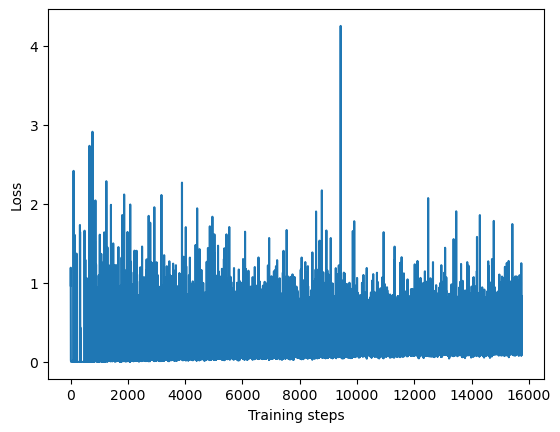

In [149]:
# Plotting the training loss curve

epochs = np.arange(0, len(training_loss), 1) #Note that this actually represents the loss over a single batch rather than an epoch average.

plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.plot(epochs, training_loss)

327628
326000


C:\Users\sedm6586\AppData\Local\anaconda3\envs\py39\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sedm6586\AppData\Local\anaconda3\envs\py39\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


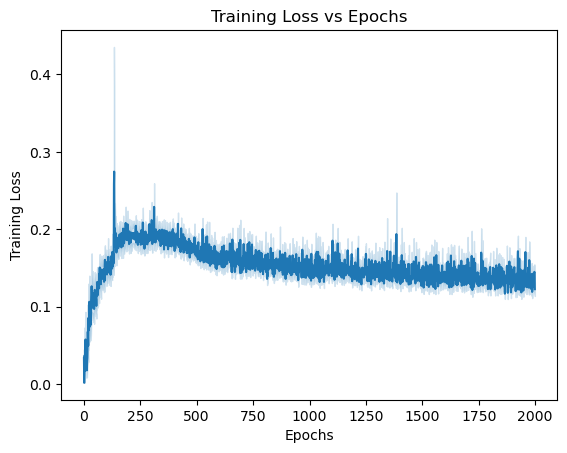

In [168]:
# Creating a Seaborn plot of training loss so that it can be seen declining more clearly

epochs = np.arange(0, num_epochs, 1) #Remember to change this if multiple training runs have been used

# Calculate the number of training_loss values per epoch
values_per_epoch = len(training_loss) // len(epochs)
#print(values_per_epoch)
#print(len(training_loss))
#print(len(epochs))

# Create a new list of epochs repeated for each corresponding training_loss value
expanded_epochs = [epoch for epoch in epochs for _ in range(values_per_epoch)]

print(len(training_loss))
print(len(expanded_epochs))
shrunk_training_loss = training_loss[:len(expanded_epochs)]

# Plot the training_loss against the expanded_epochs
sns.lineplot(x=expanded_epochs, y=shrunk_training_loss)

# Set the plot title and labels
plt.title("Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

# Display the plot
plt.show()

In [164]:
# Model evaluation

val_samples = 100000
points, labels = mandelbrot_data_generator(max_iter, resolution, val_samples)
val_loader = data_loader(points, labels, batch_size)

# Evaluate accuracy on the validation set
model.eval()
correct = 0
guess1 = 0
guess0 = 0
label1 = 0
label0 = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        guess1 += (predicted == 1).sum().item()
        guess0 += (predicted == 0).sum().item()
        label1 += (labels == 1).sum().item()
        label0 += (labels == 0).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")
print(f'Number of points labelled 1: ', label1)
print(f'Number of points labelled 0: ', label0)
print(f'Proportion of guesses equal to 0: {guess0/total:.6f}')
print(f'Proportion of guesses equal to 1: {guess1/total:.6f}')

Validation Accuracy: 81.01%
Number of points labelled 1:  137
Number of points labelled 0:  99863
Proportion of guesses equal to 0: 0.808790
Proportion of guesses equal to 1: 0.191210


In [1]:
# Plotting the decision boundary of this network. This boundary should strongly resemble the Mandelbrot set if it has trained properly

# Generate a grid of points for visualization
x_min, x_max = -10, 10
y_min, y_max = -10, 10
resolution = 0.05  # Adjust this value as needed

x_vals = torch.arange(x_min, x_max, resolution)
y_vals = torch.arange(y_min, y_max, resolution)
xx, yy = torch.meshgrid(x_vals, y_vals)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Evaluate the model on the grid points
model.eval()
with torch.no_grad():
    outputs = model(grid_points)
    _, predicted = torch.max(outputs.data, 1)

# Reshape the predictions to match the grid
predicted = predicted.reshape(xx.shape).T

# Create a color map
cmap = plt.get_cmap('viridis')

# Plot the decision boundary
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(predicted, cmap=cmap, extent=[x_min, x_max, y_min, y_max])
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.set_title('Decision Boundary')
fig.colorbar(im, ax=ax)
plt.show()

NameError: name 'torch' is not defined

100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


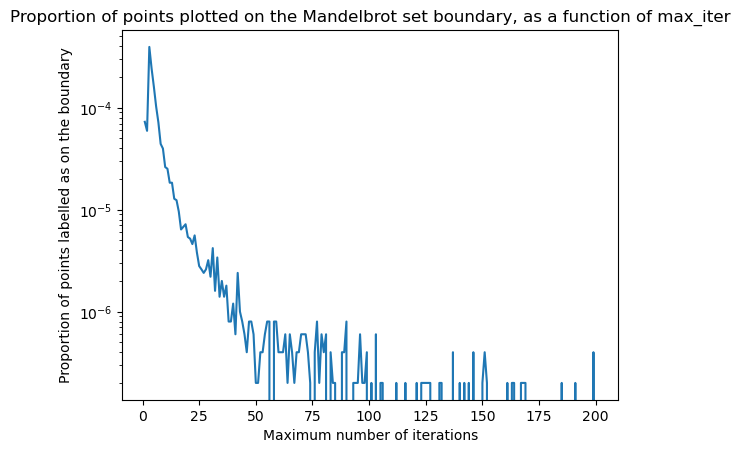

In [27]:
# Create a graph of the proportion of points samples which are 1 for different max_iter values
#import numpy as np
#import matplotlib.pyplot as plt
#from tqdm import tqdm

resolution = 0.001
num_samples = 10000
total_pixels = 5 / (resolution**2) 
#print(f'total_pixels = ', total_pixels)
max_iter_arr = np.arange(1, 201, 1)
num_list = []
for max_iter in tqdm(max_iter_arr):
    points, labels = mandelbrot_data_generator(max_iter, resolution, num_samples)
    #num_list.append(len(np.nonzero(labels)))
    num_list.append(len(np.nonzero(labels)[0]))
    #print(f"1D length = ", len(np.nonzero(labels)[0]))
    #print(f"nonzero = ", np.nonzero(labels))
#print(num_list)
prop_list = np.zeros(len(num_list))
for i in range(len(num_list)):
    prop_list[i] = num_list[i] / total_pixels
#print(prop_list)
#plt.plot(max_iter_arr, prop_list)
plt.semilogy(max_iter_arr, prop_list)
plt.xlabel('Maximum number of iterations')
plt.ylabel('Proportion of points labelled as on the boundary')
plt.title('Proportion of points plotted on the Mandelbrot set boundary, as a function of max_iter')
plt.show()

In [141]:
# Calculating the number of parameters in a model

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of model parameters: ", pytorch_total_params)

Number of model parameters:  1058818


In [84]:
def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
        else:
            for child_layer in layer.children():
                reset_weights(child_layer)

#reset_weights(model)

In [86]:
def plot_complex(points):
    # takes a list of complex values and plots them on a 2D plane
    length = len(points)
    x_values = np.zeros(length)
    y_values = np.zeros(length)

    for i in range(length):
        x_values[i] = points[i].real
        y_values[i] = points[i].imag

    plt.scatter(x_values, y_values, s=1, c='black')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.title('Boundary Points of Mandelbrot Set')
    plt.grid(True)
    plt.show()

def mandelbrot_boundary_greedy(max_iter, resolution):
    #Variables
    # max_iter = the number of iterations considered. Used to calcualte whether a point is in the set or not
    # resolution = the size of pixels being considered

    # This is the theoretical range which we need to search over
    x_min, x_max = -2, 0.5
    y_min, y_max = -1, 1

    width_vals = np.arange(x_min, x_max, resolution)
    height_vals = np.arange(y_min, y_max, resolution)
    
    # Initialising the list which will be used soon
    points = []
    
    for x in tqdm(width_vals, position=0, leave=True): # Creates the progress bar. Should probably provide the Verbose attribute
    #for x in width_vals:
        for y in height_vals:
            
            cx = x
            cy = y
            c = complex(cx, cy)

            if mandelbrot(c, max_iter) == max_iter - 1: #if the point is just slightly outside the set
                points.append(c)

    return points

100%|██████████| 25000/25000 [26:00<00:00, 16.03it/s]


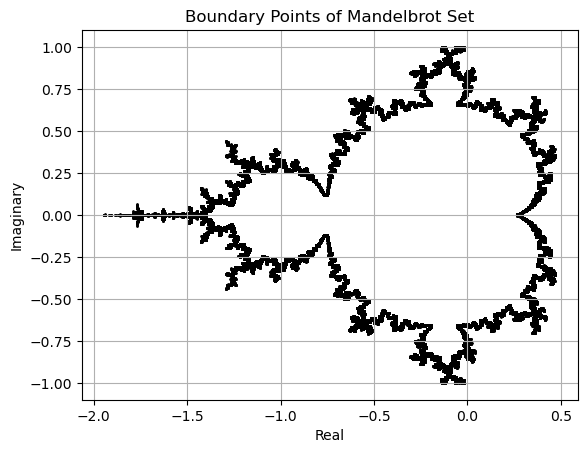

In [88]:
plot_complex(mandelbrot_boundary_greedy(25, 0.0001))

In [108]:
training_loss_copy = training_loss